In [1]:
import numpy as np
print("np: ", np.__version__)
import matplotlib
print("mpl: ", matplotlib.__version__)
import numpy as np
import scipy.stats as sst
import scipy as sp
print("sp: ", sp.__version__)
import matplotlib.pylab as plt
import scipy.spatial.distance as ssp
import pandas as pd

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.theo_variogram_fct as vario

import datetime
import helpers.kriging as kri
import helpers.variogram as variokri

np:  1.16.5
mpl:  3.1.1
sp:  1.3.1


In [2]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
#print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
#print(xyz[:3])

#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

(539, 2)


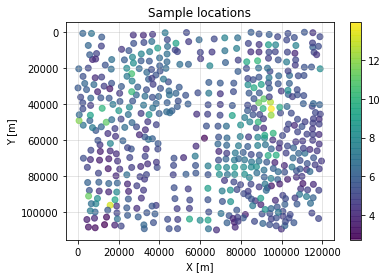

In [3]:
#Scatter plot of samples
xy = xyz[:,0:2] #the coordenate x is the second column and y the first one. 
print(xy.shape)

y = xyz[:,0] #The first coordenate is y rather than x as usual.
x = xyz[:,1]
z = xyz[:,2]


plt.scatter(x, y, c=z, alpha=0.7)
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True, alpha=0.4)

539
328


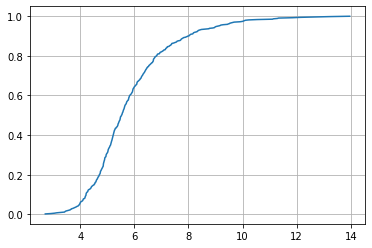

In [4]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

print(z.size)
print(values_cdf.size)

#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)

min = -2.9058541750122475 max = 2.861769176055261


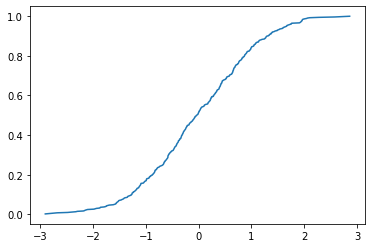

In [5]:
#Data to be transformed
np.random.seed(1000)
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)

print("min =", min(normal_data), "max =", max(normal_data))


In [6]:
#Normalization of data z
#NOTE: DUE TO ASSIGNATION OF NEW VALUES TO z variable at the end of this cell-code, from the second execution this cell-code doesnt work properly.
#      To fix it run again the cell above to reset values of "z".
z_norm = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    z_norm.append(inter(cdf[pos]))                                 #looks for the normed value with the same cumm probability

z_norm = np.array(z_norm)

print('max z normalized value =', max(z))
print('min z normalized value =', min(z))

max z normalized value = 13.96
min z normalized value = 2.71


total number of distances = 144991
max distance = 155400.2 [m]
min distance = 1419.2 [m]
dimensions of D =  (539, 539)


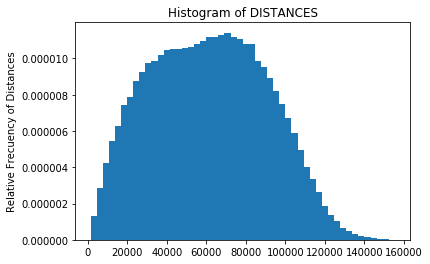

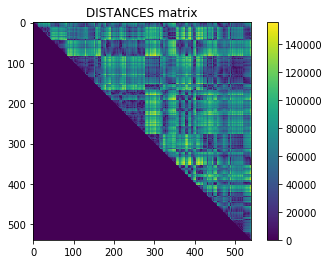

In [7]:
H = ssp.pdist(xy, metric='euclidean')
D = ssp.squareform(H)
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = 50, density='true') # bins = np.arange(0, np.round(max(H),0)+1 , delta_x)
plt.title("Histogram of DISTANCES")
plt.ylabel('Relative Frecuency of Distances')
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()

### Correlogram

In [8]:
n = np.linspace(1000,40000,40)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.
 31000. 32000. 33000. 34000. 35000. 36000. 37000. 38000. 39000. 40000.]
<class 'numpy.ndarray'>


In [9]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 26)


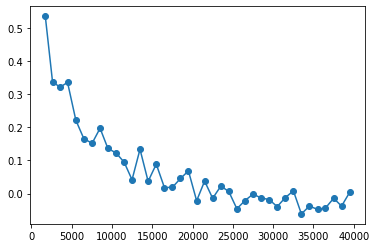

In [10]:
F = z_norm

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')

### Empiric Variogram

In [11]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

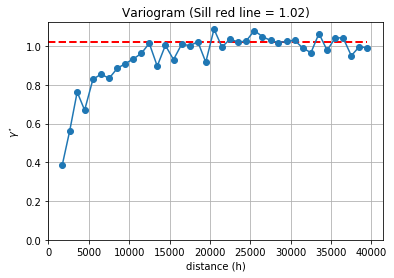

In [12]:
#Sill calculation
sill = np.var(z_norm)  #the sill is the variance of z normalized values
plt.hlines(y=sill, xmin=0, xmax=max(d_mean), colors='r', linestyles='--', lw=2) # plot sill as red dashed line.
plt.plot(d_mean, np.array(sem_vars), marker ='o')                               # plot empirical variogram
plt.grid(True)
plt.title('Variogram (Sill red line = ' + str(np.round(sill,2)) + ')')
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)
plt.show()

### Initialize grid and assignation of sample values to proper cells

In [13]:
nx = 2 + int(max(x)/delta_x)       #number of required cells in x-axis
ny = 2 + int(max(y)/delta_y)       #number of required cells in y-axis
print("x max =", max(x), ", y max =", max(y))
print("This map require", nx, "cells in x-axis and", ny,"in y-xis")

x max = 119592.0 , y max = 109987.0
This map require 121 cells in x-axis and 111 in y-xis


In [14]:
#Initialize grid
X,Y = np.mgrid[0:int(delta_y+max(y)):delta_y, 0:int(delta_x+max(x)):delta_x] #is assigned y-related to row and x-related to columns

#Initialize the entire matrix with "None" values
Z = np.zeros([X.shape[0],X.shape[1]])  #it can be with X.shape or Y.shape coz both have same dimensions.
Z[:,:]=None
print('Z dimensions =',Z.shape)

##plot
# plt.imshow(Z, aspect='auto')
# plt.colorbar()
# plt.grid(True)

Z dimensions = (111, 121)


In [15]:
Y.shape

(111, 121)

In [16]:
Y

array([[     0,   1000,   2000, ..., 118000, 119000, 120000],
       [     0,   1000,   2000, ..., 118000, 119000, 120000],
       [     0,   1000,   2000, ..., 118000, 119000, 120000],
       ...,
       [     0,   1000,   2000, ..., 118000, 119000, 120000],
       [     0,   1000,   2000, ..., 118000, 119000, 120000],
       [     0,   1000,   2000, ..., 118000, 119000, 120000]])

max_z_normal value = 2.861769176055261
min_z_normal value = -2.9058541750122475


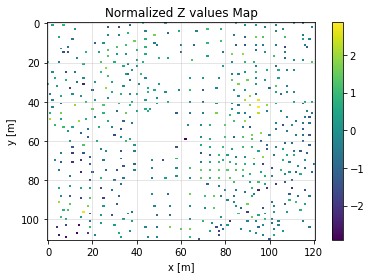

In [17]:
#Assign value of normalized samples (z) to corresponding cells in initialized matrix (Z)

i=0
observations_index = []
while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    y_i = int(np.round(y[i]/delta_y,0))
    Z[y_i,x_i] = z_norm[i]
    observations_index.append([y_i,x_i])
    i = i+1

print('max_z_normal value =', max(z_norm))
print('min_z_normal value =', min(z_norm))

plt.imshow(Z)
plt.grid(True, alpha=0.4)
plt.imshow(Z, aspect='auto')
plt.colorbar()
plt.title('Normalized Z values Map')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('sample_grid_map.png', dpi=300) #save a nice .png of this map.

In [18]:
i=0
observations_index = []
while i< x.shape[0]:
    column = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    raw = int(np.round(y[i]/delta_y,0))
 
    Z[raw][column] = z_norm[i]
    observations_index.append([raw,column])
    i = i+1

# Theoretical Variogram Models

In [19]:
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [20]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

# plotting function for multiple variogram models 
def plot_n_varmodel(Sill, Range):
    for cur_i, var_model in enumerate(var_models):
        v_model = var_model(Sill, Range, h)
        plt.plot(h,v_model, label=models_to_plot[cur_i]) # Model Variogram
        plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
        plt.xlabel('distance')
        plt.ylabel('$\\gamma$')
        plt.xlim(0.,max(h))
        plt.ylim(0.,)
        plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# plotting function for nested models   
def plot_nes_varmodel(h,mod):
    v_model = nest_vario.Variogram(h, model = mod.value)
    plt.plot(h, v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\gamma^{\star}$')
    plt.ylim(0.,sum(var_sill)*1.5)
    plt.xlim(0.,max(h))
    plt.grid(True)
    plt.show()

In [21]:
max(d_mean)

39497.25101963115

In [22]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = 2)
h = np.linspace(0, max(d_mean),  int(max(d_mean)/10.))
var_range = np.round(np.max(np.array(d_mean)),decimals = 2)
print(np.max(np.array(sem_vars)))
print(var_sill)

1.086964200299213
1.09


## Interactive Plot #1

With this interactive display, using slider bars, you can adjust the SILL and the RANGE for a Variogram Model selected from a dropdown list. The graph axes will update automatically.

In [23]:
# Trigger Interactive Plot
# recommended parameters : (sill = 0.9, range = 4740)
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/100,var_sill*1.5,0.01),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.8209000000000001, description='Sill', max=1.6350000000000002, min=0.…

<function __main__.plot_varmodel(Sill, Range, Model)>

# Interpolate (Kriging)

In [24]:
# number conditioning points
n_cond = 50

# verbose output
talk_to_me = True  # True or False

In [25]:
controls = (np.dstack([x,y]))[0] #return first array of all (x,y) location of sample points.
print(controls.shape)
# print(controls)

(539, 2)


In [26]:
if len(controls.shape)<3: #to avoid in multiple runs add more dimensions
    controls = controls[:, np.newaxis, :] #para que???
print(len(controls.shape))
print(controls.shape)

3
(539, 1, 2)


In [27]:
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)

print(f'x:  min={x_min}, max={x_max}')
print(f'y:  min={y_min}, max={y_max}')

x:  min=0.0, max=119592.0
y:  min=0.0, max=109987.0


In [28]:
# xe = np.linspace(start=0, stop=(Z.shape[0]-1)*delta_x, num=(Z.shape[0]))
# ye = np.linspace(start=0, stop=(Z.shape[1]-1)*delta_y, num=(Z.shape[1]))
# print(xe[:5],xe[-5:])
# print(ye[:5],ye[-5:])

# xes, yes = np.meshgrid(xe, ye)

# # location where to interpolate (x,y values)
# target_coords = np.vstack((yes.flatten(),xes.flatten())).T#first should be coordenate x that is given by the columns index
# targets = target_coords
# print(targets.shape)

i_index, j_index = np.meshgrid(range(Z.shape[0]), range(Z.shape[1]), indexing='ij')#meshgrid with index 
index = np.column_stack((np.concatenate(i_index), np.concatenate(j_index)))#rows and columns append in order to have a vector of all possible indexes (i,j) in the matrix 

index_to_simulate = [i for i in index.tolist() if i not in observations_index]#Delete from the matrix the 'observed data'

xe = Y[0,:][np.array(index_to_simulate)[:,1]]#Columns are coordinate x
ye = X[:,0][np.array(index_to_simulate)[:,0]]#Raws are coordinate y

targets = np.column_stack((xe, ye))

print("Number of cell in meshgrid =",targets.shape[0])

Number of cell in meshgrid = 12892


In [29]:
# measurement values
controlvalues = z_norm
# print(controlvalues.shape)
# print(controls.shape)

In [30]:
var_sample = np.var(controlvalues)
print(var_sample)

1.018511018533664


In [31]:
# Variogram Parameters
expo = variokri.ExponentialVariogram({'sill': 1.03,
                                   'range': 4344.70,
                                   'variance': var_sample})

fitted_variogram = variokri.CompositeVariogram()
fitted_variogram.addVariogram(expo)

In [32]:
ok_results = []
interpolation_kri = Z
std_kri = np.zeros((Z.shape[0],Z.shape[1]))

ok_result = kri.krige_ok(controls
                       , targets
                       , controlvalues
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(i, targets[i][0], targets[i][1], result[1]))
    # the weights are stored in results[0] but not saved here
    interpolation_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[1]
    std_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[2]
    ok_results.append([result[1], result[2]])

ID 	 x 	 y 	 est(z)
 0	0.00	0.00	0.32
 1	1000.00	0.00	0.38
 2	2000.00	0.00	0.46
 3	3000.00	0.00	0.52
 4	4000.00	0.00	0.59
 5	5000.00	0.00	0.66
 6	6000.00	0.00	0.75
 7	7000.00	0.00	0.76
 8	8000.00	0.00	0.64
 9	9000.00	0.00	0.52
10	10000.00	0.00	0.42
11	11000.00	0.00	0.35
12	12000.00	0.00	0.26
13	13000.00	0.00	0.19
14	14000.00	0.00	0.13
15	15000.00	0.00	0.10
16	16000.00	0.00	0.04
17	17000.00	0.00	-0.01
18	18000.00	0.00	-0.08
19	19000.00	0.00	-0.08
20	20000.00	0.00	-0.17
21	21000.00	0.00	-0.23
22	22000.00	0.00	-0.33
23	23000.00	0.00	-0.39
24	24000.00	0.00	-0.50
25	25000.00	0.00	-0.63
26	26000.00	0.00	-0.80
27	27000.00	0.00	-0.93
28	28000.00	0.00	-1.02
29	29000.00	0.00	-1.05
30	30000.00	0.00	-1.09
31	31000.00	0.00	-1.16
32	32000.00	0.00	-1.19
33	33000.00	0.00	-1.13
34	34000.00	0.00	-1.05
35	35000.00	0.00	-0.98
36	36000.00	0.00	-0.94
37	37000.00	0.00	-0.80
38	38000.00	0.00	-0.50
39	39000.00	0.00	-0.19
40	40000.00	0.00	0.10
41	41000.00	0.00	0.39
42	42000.00	0.00	0.71
43	44000.00	0.00	0.72
44

327	99000.00	2000.00	-0.41
328	100000.00	2000.00	-0.37
329	101000.00	2000.00	-0.36
330	102000.00	2000.00	-0.35
331	103000.00	2000.00	-0.33
332	104000.00	2000.00	-0.28
333	105000.00	2000.00	-0.22
334	106000.00	2000.00	-0.17
335	107000.00	2000.00	-0.09
336	108000.00	2000.00	-0.02
337	109000.00	2000.00	0.01
338	110000.00	2000.00	0.01
339	111000.00	2000.00	-0.07
340	112000.00	2000.00	-0.22
341	113000.00	2000.00	-0.42
342	114000.00	2000.00	-0.63
343	115000.00	2000.00	-0.78
344	116000.00	2000.00	-0.80
345	117000.00	2000.00	-0.71
346	118000.00	2000.00	-0.58
347	120000.00	2000.00	-0.37
348	0.00	3000.00	0.35
349	1000.00	3000.00	0.40
350	2000.00	3000.00	0.45
351	3000.00	3000.00	0.51
352	4000.00	3000.00	0.56
353	5000.00	3000.00	0.60
354	6000.00	3000.00	0.61
355	7000.00	3000.00	0.57
356	8000.00	3000.00	0.48
357	9000.00	3000.00	0.39
358	10000.00	3000.00	0.30
359	11000.00	3000.00	0.23
360	13000.00	3000.00	0.07
361	14000.00	3000.00	-0.00
362	15000.00	3000.00	-0.06
363	16000.00	3000.00	-0.11
364	17000

635	55000.00	5000.00	-0.73
636	56000.00	5000.00	-0.45
637	57000.00	5000.00	-0.16
638	58000.00	5000.00	0.11
639	59000.00	5000.00	0.35
640	60000.00	5000.00	0.40
641	61000.00	5000.00	0.27
642	62000.00	5000.00	0.14
643	63000.00	5000.00	0.01
644	64000.00	5000.00	-0.10
645	65000.00	5000.00	-0.19
646	66000.00	5000.00	-0.25
647	67000.00	5000.00	-0.21
648	68000.00	5000.00	-0.03
649	69000.00	5000.00	0.19
650	70000.00	5000.00	0.44
651	71000.00	5000.00	0.67
652	72000.00	5000.00	0.83
653	73000.00	5000.00	0.91
654	74000.00	5000.00	0.93
655	75000.00	5000.00	0.92
656	76000.00	5000.00	0.89
657	77000.00	5000.00	0.85
658	78000.00	5000.00	0.78
659	79000.00	5000.00	0.65
660	80000.00	5000.00	0.47
661	81000.00	5000.00	0.26
662	82000.00	5000.00	0.05
663	83000.00	5000.00	-0.16
664	84000.00	5000.00	-0.33
665	85000.00	5000.00	-0.43
666	86000.00	5000.00	-0.52
667	87000.00	5000.00	-0.57
668	88000.00	5000.00	-0.58
669	89000.00	5000.00	-0.48
670	90000.00	5000.00	-0.24
671	91000.00	5000.00	0.10
672	92000.00	5000.00	0

944	12000.00	8000.00	-0.56
945	13000.00	8000.00	-0.47
946	14000.00	8000.00	-0.41
947	15000.00	8000.00	-0.37
948	16000.00	8000.00	-0.37
949	17000.00	8000.00	-0.39
950	18000.00	8000.00	-0.47
951	19000.00	8000.00	-0.59
952	20000.00	8000.00	-0.70
953	21000.00	8000.00	-0.79
954	22000.00	8000.00	-0.75
955	23000.00	8000.00	-0.58
956	24000.00	8000.00	-0.39
957	25000.00	8000.00	-0.22
958	26000.00	8000.00	-0.06
959	27000.00	8000.00	0.06
960	28000.00	8000.00	0.14
961	29000.00	8000.00	0.20
962	30000.00	8000.00	0.24
963	31000.00	8000.00	0.28
964	32000.00	8000.00	0.35
965	33000.00	8000.00	0.47
966	34000.00	8000.00	0.63
967	35000.00	8000.00	0.81
968	36000.00	8000.00	0.99
969	37000.00	8000.00	1.13
970	38000.00	8000.00	1.27
971	39000.00	8000.00	1.35
972	40000.00	8000.00	1.23
973	41000.00	8000.00	1.04
974	42000.00	8000.00	0.88
975	43000.00	8000.00	0.79
976	45000.00	8000.00	0.63
977	46000.00	8000.00	0.56
978	47000.00	8000.00	0.53
979	48000.00	8000.00	0.50
980	49000.00	8000.00	0.39
981	50000.00	8000.00	0.

1241	76000.00	10000.00	0.81
1242	77000.00	10000.00	0.83
1243	78000.00	10000.00	0.79
1244	79000.00	10000.00	0.60
1245	80000.00	10000.00	0.35
1246	81000.00	10000.00	0.09
1247	82000.00	10000.00	-0.19
1248	83000.00	10000.00	-0.51
1249	84000.00	10000.00	-0.83
1250	85000.00	10000.00	-1.10
1251	86000.00	10000.00	-1.17
1252	87000.00	10000.00	-1.21
1253	88000.00	10000.00	-1.28
1254	89000.00	10000.00	-1.25
1255	90000.00	10000.00	-0.96
1256	91000.00	10000.00	-0.59
1257	92000.00	10000.00	-0.28
1258	93000.00	10000.00	-0.07
1259	94000.00	10000.00	0.04
1260	95000.00	10000.00	0.04
1261	96000.00	10000.00	-0.06
1262	97000.00	10000.00	-0.15
1263	98000.00	10000.00	-0.13
1264	99000.00	10000.00	-0.12
1265	100000.00	10000.00	-0.15
1266	101000.00	10000.00	-0.22
1267	102000.00	10000.00	-0.32
1268	103000.00	10000.00	-0.41
1269	104000.00	10000.00	-0.49
1270	105000.00	10000.00	-0.55
1271	106000.00	10000.00	-0.60
1272	107000.00	10000.00	-0.55
1273	108000.00	10000.00	-0.42
1274	109000.00	10000.00	-0.31
1275	110000.

1527	15000.00	13000.00	0.06
1528	16000.00	13000.00	0.17
1529	17000.00	13000.00	0.20
1530	18000.00	13000.00	0.16
1531	19000.00	13000.00	0.08
1532	20000.00	13000.00	-0.00
1533	21000.00	13000.00	-0.03
1534	22000.00	13000.00	0.01
1535	23000.00	13000.00	0.14
1536	24000.00	13000.00	0.34
1537	25000.00	13000.00	0.60
1538	26000.00	13000.00	0.86
1539	27000.00	13000.00	1.02
1540	28000.00	13000.00	1.02
1541	29000.00	13000.00	1.00
1542	30000.00	13000.00	0.99
1543	31000.00	13000.00	0.99
1544	32000.00	13000.00	0.91
1545	33000.00	13000.00	0.81
1546	34000.00	13000.00	0.75
1547	35000.00	13000.00	0.74
1548	36000.00	13000.00	0.76
1549	37000.00	13000.00	0.78
1550	38000.00	13000.00	0.81
1551	39000.00	13000.00	0.84
1552	40000.00	13000.00	0.86
1553	41000.00	13000.00	0.85
1554	42000.00	13000.00	0.84
1555	43000.00	13000.00	0.81
1556	44000.00	13000.00	0.72
1557	45000.00	13000.00	0.54
1558	46000.00	13000.00	0.33
1559	47000.00	13000.00	0.15
1560	48000.00	13000.00	0.01
1561	49000.00	13000.00	-0.06
1562	50000.00	130

1815	69000.00	15000.00	0.27
1816	70000.00	15000.00	0.33
1817	71000.00	15000.00	0.37
1818	72000.00	15000.00	0.38
1819	73000.00	15000.00	0.35
1820	74000.00	15000.00	0.27
1821	75000.00	15000.00	0.16
1822	76000.00	15000.00	0.01
1823	77000.00	15000.00	-0.18
1824	78000.00	15000.00	-0.40
1825	80000.00	15000.00	-0.03
1826	81000.00	15000.00	0.39
1827	82000.00	15000.00	0.77
1828	83000.00	15000.00	1.00
1829	84000.00	15000.00	1.01
1830	85000.00	15000.00	0.97
1831	86000.00	15000.00	1.00
1832	87000.00	15000.00	1.15
1833	88000.00	15000.00	1.28
1834	89000.00	15000.00	1.05
1835	90000.00	15000.00	0.63
1836	91000.00	15000.00	0.25
1837	92000.00	15000.00	-0.11
1838	93000.00	15000.00	-0.45
1839	94000.00	15000.00	-0.59
1840	95000.00	15000.00	-0.48
1841	96000.00	15000.00	-0.37
1842	97000.00	15000.00	-0.27
1843	99000.00	15000.00	-0.02
1844	100000.00	15000.00	0.14
1845	101000.00	15000.00	0.30
1846	102000.00	15000.00	0.38
1847	103000.00	15000.00	0.27
1848	104000.00	15000.00	-0.01
1849	105000.00	15000.00	-0.30
18

2102	4000.00	18000.00	-0.31
2103	5000.00	18000.00	-0.52
2104	6000.00	18000.00	-0.70
2105	7000.00	18000.00	-0.83
2106	8000.00	18000.00	-0.87
2107	9000.00	18000.00	-0.82
2108	10000.00	18000.00	-0.70
2109	11000.00	18000.00	-0.53
2110	12000.00	18000.00	-0.34
2111	14000.00	18000.00	0.09
2112	15000.00	18000.00	0.34
2113	16000.00	18000.00	0.54
2114	17000.00	18000.00	0.65
2115	18000.00	18000.00	0.69
2116	19000.00	18000.00	0.70
2117	20000.00	18000.00	0.70
2118	21000.00	18000.00	0.72
2119	22000.00	18000.00	0.79
2120	23000.00	18000.00	0.90
2121	24000.00	18000.00	1.03
2122	25000.00	18000.00	1.16
2123	26000.00	18000.00	1.26
2124	27000.00	18000.00	1.29
2125	28000.00	18000.00	1.14
2126	29000.00	18000.00	0.89
2127	30000.00	18000.00	0.65
2128	31000.00	18000.00	0.46
2129	32000.00	18000.00	0.33
2130	33000.00	18000.00	0.23
2131	34000.00	18000.00	0.15
2132	35000.00	18000.00	0.07
2133	36000.00	18000.00	0.05
2134	37000.00	18000.00	0.08
2135	38000.00	18000.00	0.15
2136	39000.00	18000.00	0.24
2137	40000.00	180

2393	66000.00	20000.00	0.91
2394	67000.00	20000.00	0.77
2395	68000.00	20000.00	0.66
2396	69000.00	20000.00	0.55
2397	70000.00	20000.00	0.46
2398	71000.00	20000.00	0.41
2399	72000.00	20000.00	0.35
2400	73000.00	20000.00	0.31
2401	74000.00	20000.00	0.26
2402	75000.00	20000.00	0.23
2403	76000.00	20000.00	0.18
2404	77000.00	20000.00	0.17
2405	78000.00	20000.00	0.17
2406	79000.00	20000.00	0.15
2407	80000.00	20000.00	0.11
2408	81000.00	20000.00	0.05
2409	82000.00	20000.00	-0.07
2410	84000.00	20000.00	0.18
2411	85000.00	20000.00	0.40
2412	86000.00	20000.00	0.55
2413	87000.00	20000.00	0.65
2414	88000.00	20000.00	0.72
2415	90000.00	20000.00	0.73
2416	91000.00	20000.00	0.71
2417	92000.00	20000.00	0.72
2418	94000.00	20000.00	0.37
2419	95000.00	20000.00	0.12
2420	96000.00	20000.00	0.06
2421	97000.00	20000.00	0.08
2422	98000.00	20000.00	0.11
2423	99000.00	20000.00	0.11
2424	100000.00	20000.00	0.09
2425	101000.00	20000.00	0.01
2426	102000.00	20000.00	-0.14
2427	103000.00	20000.00	-0.32
2428	104000.0

2682	3000.00	23000.00	-0.12
2683	4000.00	23000.00	-0.26
2684	5000.00	23000.00	-0.41
2685	6000.00	23000.00	-0.58
2686	7000.00	23000.00	-0.76
2687	8000.00	23000.00	-0.88
2688	9000.00	23000.00	-0.90
2689	10000.00	23000.00	-0.80
2690	11000.00	23000.00	-0.64
2691	12000.00	23000.00	-0.44
2692	13000.00	23000.00	-0.23
2693	14000.00	23000.00	-0.02
2694	15000.00	23000.00	0.17
2695	16000.00	23000.00	0.35
2696	17000.00	23000.00	0.46
2697	18000.00	23000.00	0.55
2698	19000.00	23000.00	0.62
2699	20000.00	23000.00	0.70
2700	21000.00	23000.00	0.79
2701	22000.00	23000.00	0.91
2702	23000.00	23000.00	1.06
2703	24000.00	23000.00	1.25
2704	25000.00	23000.00	1.51
2705	27000.00	23000.00	1.74
2706	28000.00	23000.00	1.43
2707	29000.00	23000.00	1.18
2708	30000.00	23000.00	0.98
2709	31000.00	23000.00	0.84
2710	32000.00	23000.00	0.75
2711	33000.00	23000.00	0.68
2712	34000.00	23000.00	0.54
2713	35000.00	23000.00	0.24
2714	36000.00	23000.00	0.00
2715	37000.00	23000.00	-0.08
2716	38000.00	23000.00	-0.02
2717	39000.00

2972	61000.00	25000.00	0.32
2973	62000.00	25000.00	0.36
2974	63000.00	25000.00	0.38
2975	64000.00	25000.00	0.42
2976	65000.00	25000.00	0.43
2977	66000.00	25000.00	0.42
2978	67000.00	25000.00	0.41
2979	68000.00	25000.00	0.40
2980	69000.00	25000.00	0.38
2981	70000.00	25000.00	0.36
2982	71000.00	25000.00	0.31
2983	72000.00	25000.00	0.26
2984	73000.00	25000.00	0.24
2985	74000.00	25000.00	0.21
2986	75000.00	25000.00	0.18
2987	76000.00	25000.00	0.17
2988	77000.00	25000.00	0.16
2989	78000.00	25000.00	0.14
2990	79000.00	25000.00	0.13
2991	80000.00	25000.00	0.07
2992	81000.00	25000.00	-0.02
2993	82000.00	25000.00	-0.15
2994	83000.00	25000.00	-0.31
2995	84000.00	25000.00	-0.35
2996	85000.00	25000.00	-0.29
2997	86000.00	25000.00	-0.22
2998	87000.00	25000.00	-0.10
2999	88000.00	25000.00	0.01
3000	90000.00	25000.00	0.32
3001	91000.00	25000.00	0.47
3002	92000.00	25000.00	0.59
3003	93000.00	25000.00	0.74
3004	95000.00	25000.00	0.62
3005	96000.00	25000.00	0.50
3006	97000.00	25000.00	0.48
3007	98000.00

3262	117000.00	27000.00	0.19
3263	118000.00	27000.00	0.22
3264	119000.00	27000.00	0.24
3265	120000.00	27000.00	0.24
3266	0.00	28000.00	0.35
3267	1000.00	28000.00	0.38
3268	2000.00	28000.00	0.44
3269	4000.00	28000.00	0.47
3270	5000.00	28000.00	0.35
3271	6000.00	28000.00	0.27
3272	7000.00	28000.00	0.22
3273	8000.00	28000.00	0.08
3274	9000.00	28000.00	-0.20
3275	10000.00	28000.00	-0.42
3276	11000.00	28000.00	-0.53
3277	12000.00	28000.00	-0.56
3278	13000.00	28000.00	-0.54
3279	14000.00	28000.00	-0.49
3280	15000.00	28000.00	-0.36
3281	17000.00	28000.00	0.02
3282	18000.00	28000.00	0.04
3283	19000.00	28000.00	0.13
3284	20000.00	28000.00	0.27
3285	21000.00	28000.00	0.42
3286	22000.00	28000.00	0.57
3287	23000.00	28000.00	0.72
3288	24000.00	28000.00	0.86
3289	25000.00	28000.00	0.97
3290	26000.00	28000.00	1.04
3291	27000.00	28000.00	1.01
3292	28000.00	28000.00	0.91
3293	29000.00	28000.00	0.76
3294	30000.00	28000.00	0.63
3295	31000.00	28000.00	0.50
3296	32000.00	28000.00	0.37
3297	33000.00	28000.0

3553	61000.00	30000.00	0.24
3554	62000.00	30000.00	0.31
3555	63000.00	30000.00	0.36
3556	64000.00	30000.00	0.38
3557	65000.00	30000.00	0.36
3558	66000.00	30000.00	0.29
3559	67000.00	30000.00	0.20
3560	68000.00	30000.00	0.12
3561	69000.00	30000.00	0.04
3562	70000.00	30000.00	-0.02
3563	71000.00	30000.00	-0.06
3564	72000.00	30000.00	-0.09
3565	73000.00	30000.00	-0.10
3566	74000.00	30000.00	-0.09
3567	75000.00	30000.00	-0.07
3568	76000.00	30000.00	-0.04
3569	77000.00	30000.00	0.03
3570	78000.00	30000.00	0.13
3571	79000.00	30000.00	0.25
3572	80000.00	30000.00	0.40
3573	81000.00	30000.00	0.58
3574	82000.00	30000.00	0.83
3575	83000.00	30000.00	1.13
3576	84000.00	30000.00	1.30
3577	85000.00	30000.00	1.36
3578	86000.00	30000.00	1.48
3579	87000.00	30000.00	1.48
3580	88000.00	30000.00	1.39
3581	89000.00	30000.00	1.38
3582	90000.00	30000.00	1.33
3583	91000.00	30000.00	1.05
3584	92000.00	30000.00	0.70
3585	93000.00	30000.00	0.41
3586	94000.00	30000.00	0.22
3587	95000.00	30000.00	0.09
3588	96000.00

3841	117000.00	32000.00	0.11
3842	118000.00	32000.00	0.09
3843	119000.00	32000.00	0.10
3844	120000.00	32000.00	0.04
3845	0.00	33000.00	0.10
3846	1000.00	33000.00	0.11
3847	2000.00	33000.00	0.15
3848	3000.00	33000.00	0.21
3849	4000.00	33000.00	0.25
3850	5000.00	33000.00	0.21
3851	6000.00	33000.00	0.06
3852	7000.00	33000.00	-0.22
3853	8000.00	33000.00	-0.66
3854	9000.00	33000.00	-1.27
3855	11000.00	33000.00	-1.32
3856	12000.00	33000.00	-1.19
3857	13000.00	33000.00	-1.22
3858	14000.00	33000.00	-1.35
3859	15000.00	33000.00	-1.52
3860	16000.00	33000.00	-1.53
3861	17000.00	33000.00	-1.34
3862	18000.00	33000.00	-1.12
3863	19000.00	33000.00	-0.95
3864	20000.00	33000.00	-0.81
3865	21000.00	33000.00	-0.52
3866	22000.00	33000.00	-0.09
3867	23000.00	33000.00	0.36
3868	24000.00	33000.00	0.79
3869	25000.00	33000.00	1.25
3870	27000.00	33000.00	1.62
3871	28000.00	33000.00	1.16
3872	29000.00	33000.00	0.82
3873	30000.00	33000.00	0.60
3874	31000.00	33000.00	0.46
3875	32000.00	33000.00	0.32
3876	33000.00	

4129	57000.00	35000.00	-0.09
4130	58000.00	35000.00	-0.13
4131	59000.00	35000.00	-0.12
4132	60000.00	35000.00	-0.01
4133	61000.00	35000.00	0.15
4134	62000.00	35000.00	0.32
4135	63000.00	35000.00	0.50
4136	64000.00	35000.00	0.60
4137	65000.00	35000.00	0.48
4138	66000.00	35000.00	0.20
4139	67000.00	35000.00	-0.11
4140	68000.00	35000.00	-0.43
4141	69000.00	35000.00	-0.74
4142	70000.00	35000.00	-0.93
4143	71000.00	35000.00	-0.85
4144	72000.00	35000.00	-0.68
4145	73000.00	35000.00	-0.54
4146	74000.00	35000.00	-0.41
4147	75000.00	35000.00	-0.32
4148	76000.00	35000.00	-0.23
4149	77000.00	35000.00	-0.14
4150	78000.00	35000.00	-0.06
4151	79000.00	35000.00	0.01
4152	80000.00	35000.00	0.07
4153	81000.00	35000.00	0.10
4154	82000.00	35000.00	0.12
4155	83000.00	35000.00	0.11
4156	84000.00	35000.00	0.12
4157	85000.00	35000.00	0.18
4158	86000.00	35000.00	0.26
4159	87000.00	35000.00	0.36
4160	88000.00	35000.00	0.46
4161	89000.00	35000.00	0.55
4162	90000.00	35000.00	0.66
4163	91000.00	35000.00	0.66
4164

4417	117000.00	37000.00	0.38
4418	118000.00	37000.00	0.32
4419	119000.00	37000.00	0.27
4420	120000.00	37000.00	0.24
4421	0.00	38000.00	-0.24
4422	1000.00	38000.00	-0.29
4423	2000.00	38000.00	-0.28
4424	3000.00	38000.00	-0.23
4425	4000.00	38000.00	-0.14
4426	5000.00	38000.00	-0.02
4427	6000.00	38000.00	0.10
4428	7000.00	38000.00	0.14
4429	8000.00	38000.00	0.16
4430	9000.00	38000.00	0.21
4431	10000.00	38000.00	0.30
4432	11000.00	38000.00	0.40
4433	12000.00	38000.00	0.47
4434	13000.00	38000.00	0.50
4435	14000.00	38000.00	0.52
4436	15000.00	38000.00	0.52
4437	16000.00	38000.00	0.47
4438	17000.00	38000.00	0.38
4439	18000.00	38000.00	0.28
4440	19000.00	38000.00	0.19
4441	20000.00	38000.00	0.11
4442	21000.00	38000.00	0.12
4443	22000.00	38000.00	0.24
4444	23000.00	38000.00	0.34
4445	24000.00	38000.00	0.39
4446	25000.00	38000.00	0.36
4447	26000.00	38000.00	0.22
4448	28000.00	38000.00	0.26
4449	29000.00	38000.00	0.41
4450	30000.00	38000.00	0.53
4451	31000.00	38000.00	0.64
4452	32000.00	38000.00	

4707	53000.00	40000.00	0.23
4708	55000.00	40000.00	0.18
4709	56000.00	40000.00	0.04
4710	57000.00	40000.00	-0.07
4711	58000.00	40000.00	-0.13
4712	59000.00	40000.00	-0.18
4713	60000.00	40000.00	-0.21
4714	61000.00	40000.00	-0.21
4715	62000.00	40000.00	-0.21
4716	63000.00	40000.00	-0.23
4717	65000.00	40000.00	-0.30
4718	66000.00	40000.00	-0.38
4719	67000.00	40000.00	-0.48
4720	68000.00	40000.00	-0.59
4721	69000.00	40000.00	-0.73
4722	71000.00	40000.00	-0.65
4723	72000.00	40000.00	-0.47
4724	73000.00	40000.00	-0.32
4725	74000.00	40000.00	-0.16
4726	75000.00	40000.00	-0.05
4727	76000.00	40000.00	0.04
4728	77000.00	40000.00	0.09
4729	78000.00	40000.00	0.11
4730	79000.00	40000.00	0.11
4731	80000.00	40000.00	0.05
4732	81000.00	40000.00	-0.01
4733	82000.00	40000.00	-0.14
4734	83000.00	40000.00	-0.25
4735	84000.00	40000.00	-0.25
4736	85000.00	40000.00	-0.13
4737	86000.00	40000.00	0.12
4738	87000.00	40000.00	0.56
4739	88000.00	40000.00	1.20
4740	89000.00	40000.00	1.77
4741	90000.00	40000.00	2.0

4996	119000.00	42000.00	0.05
4997	120000.00	42000.00	0.04
4998	0.00	43000.00	0.06
4999	1000.00	43000.00	-0.03
5000	3000.00	43000.00	-0.14
5001	4000.00	43000.00	-0.04
5002	5000.00	43000.00	0.05
5003	6000.00	43000.00	0.17
5004	7000.00	43000.00	0.36
5005	8000.00	43000.00	0.62
5006	9000.00	43000.00	0.92
5007	10000.00	43000.00	1.23
5008	11000.00	43000.00	1.57
5009	12000.00	43000.00	1.80
5010	13000.00	43000.00	1.69
5011	14000.00	43000.00	1.53
5012	15000.00	43000.00	1.39
5013	16000.00	43000.00	1.31
5014	17000.00	43000.00	1.27
5015	18000.00	43000.00	1.27
5016	19000.00	43000.00	1.35
5017	20000.00	43000.00	1.43
5018	21000.00	43000.00	1.30
5019	22000.00	43000.00	1.17
5020	23000.00	43000.00	1.12
5021	24000.00	43000.00	1.12
5022	25000.00	43000.00	1.10
5023	26000.00	43000.00	0.93
5024	27000.00	43000.00	0.67
5025	28000.00	43000.00	0.42
5026	29000.00	43000.00	0.21
5027	30000.00	43000.00	0.09
5028	31000.00	43000.00	0.11
5029	32000.00	43000.00	0.29
5030	33000.00	43000.00	0.54
5031	34000.00	43000.00	0.77

5286	55000.00	45000.00	-0.40
5287	56000.00	45000.00	-0.57
5288	57000.00	45000.00	-0.79
5289	58000.00	45000.00	-1.01
5290	59000.00	45000.00	-0.99
5291	60000.00	45000.00	-0.85
5292	61000.00	45000.00	-0.74
5293	62000.00	45000.00	-0.66
5294	63000.00	45000.00	-0.63
5295	64000.00	45000.00	-0.60
5296	65000.00	45000.00	-0.55
5297	66000.00	45000.00	-0.52
5298	67000.00	45000.00	-0.50
5299	68000.00	45000.00	-0.49
5300	69000.00	45000.00	-0.47
5301	70000.00	45000.00	-0.38
5302	71000.00	45000.00	-0.16
5303	72000.00	45000.00	0.11
5304	73000.00	45000.00	0.41
5305	74000.00	45000.00	0.72
5306	75000.00	45000.00	1.00
5307	76000.00	45000.00	1.15
5308	77000.00	45000.00	1.13
5309	78000.00	45000.00	1.02
5310	79000.00	45000.00	0.92
5311	80000.00	45000.00	0.82
5312	81000.00	45000.00	0.70
5313	82000.00	45000.00	0.59
5314	83000.00	45000.00	0.45
5315	84000.00	45000.00	0.26
5316	85000.00	45000.00	0.04
5317	86000.00	45000.00	-0.13
5318	87000.00	45000.00	-0.18
5319	88000.00	45000.00	-0.18
5320	89000.00	45000.00	-0.14

5573	116000.00	47000.00	-0.65
5574	117000.00	47000.00	-0.77
5575	118000.00	47000.00	-0.88
5576	119000.00	47000.00	-0.89
5577	120000.00	47000.00	-0.78
5578	0.00	48000.00	1.46
5579	1000.00	48000.00	1.49
5580	2000.00	48000.00	1.32
5581	3000.00	48000.00	1.13
5582	4000.00	48000.00	1.01
5583	5000.00	48000.00	0.94
5584	6000.00	48000.00	0.94
5585	7000.00	48000.00	1.01
5586	8000.00	48000.00	1.09
5587	9000.00	48000.00	1.16
5588	10000.00	48000.00	1.25
5589	11000.00	48000.00	1.36
5590	12000.00	48000.00	1.47
5591	13000.00	48000.00	1.54
5592	14000.00	48000.00	1.49
5593	15000.00	48000.00	1.28
5594	16000.00	48000.00	0.99
5595	17000.00	48000.00	0.71
5596	18000.00	48000.00	0.47
5597	19000.00	48000.00	0.22
5598	20000.00	48000.00	-0.07
5599	22000.00	48000.00	-0.15
5600	23000.00	48000.00	0.16
5601	24000.00	48000.00	0.37
5602	25000.00	48000.00	0.47
5603	26000.00	48000.00	0.46
5604	27000.00	48000.00	0.34
5605	28000.00	48000.00	0.13
5606	29000.00	48000.00	-0.11
5607	30000.00	48000.00	-0.31
5608	31000.00	48000

5861	52000.00	50000.00	-0.28
5862	53000.00	50000.00	-0.35
5863	54000.00	50000.00	-0.42
5864	55000.00	50000.00	-0.47
5865	56000.00	50000.00	-0.50
5866	57000.00	50000.00	-0.54
5867	58000.00	50000.00	-0.55
5868	59000.00	50000.00	-0.54
5869	60000.00	50000.00	-0.49
5870	61000.00	50000.00	-0.44
5871	62000.00	50000.00	-0.36
5872	63000.00	50000.00	-0.29
5873	64000.00	50000.00	-0.26
5874	65000.00	50000.00	-0.23
5875	66000.00	50000.00	-0.22
5876	67000.00	50000.00	-0.19
5877	68000.00	50000.00	-0.13
5878	69000.00	50000.00	-0.04
5879	70000.00	50000.00	0.10
5880	71000.00	50000.00	0.28
5881	72000.00	50000.00	0.49
5882	73000.00	50000.00	0.69
5883	74000.00	50000.00	0.86
5884	75000.00	50000.00	1.03
5885	76000.00	50000.00	1.14
5886	77000.00	50000.00	1.21
5887	78000.00	50000.00	1.28
5888	79000.00	50000.00	1.31
5889	80000.00	50000.00	1.30
5890	81000.00	50000.00	1.23
5891	82000.00	50000.00	1.15
5892	83000.00	50000.00	1.10
5893	85000.00	50000.00	1.06
5894	86000.00	50000.00	1.05
5895	87000.00	50000.00	1.22
58

6148	111000.00	52000.00	-0.31
6149	112000.00	52000.00	-0.47
6150	113000.00	52000.00	-0.61
6151	114000.00	52000.00	-0.73
6152	115000.00	52000.00	-0.81
6153	116000.00	52000.00	-0.83
6154	117000.00	52000.00	-0.80
6155	118000.00	52000.00	-0.73
6156	119000.00	52000.00	-0.71
6157	120000.00	52000.00	-0.73
6158	0.00	53000.00	0.80
6159	1000.00	53000.00	0.80
6160	2000.00	53000.00	0.76
6161	3000.00	53000.00	0.73
6162	4000.00	53000.00	0.72
6163	5000.00	53000.00	0.75
6164	6000.00	53000.00	0.85
6165	8000.00	53000.00	0.80
6166	9000.00	53000.00	0.61
6167	10000.00	53000.00	0.51
6168	12000.00	53000.00	0.43
6169	13000.00	53000.00	0.39
6170	14000.00	53000.00	0.29
6171	15000.00	53000.00	0.12
6172	16000.00	53000.00	-0.09
6173	17000.00	53000.00	-0.30
6174	18000.00	53000.00	-0.44
6175	19000.00	53000.00	-0.37
6176	20000.00	53000.00	-0.19
6177	21000.00	53000.00	0.07
6178	22000.00	53000.00	0.39
6179	24000.00	53000.00	0.56
6180	25000.00	53000.00	0.40
6181	26000.00	53000.00	0.23
6182	27000.00	53000.00	0.04
6183	28

6434	45000.00	55000.00	-0.20
6435	46000.00	55000.00	-0.22
6436	47000.00	55000.00	-0.24
6437	48000.00	55000.00	-0.29
6438	49000.00	55000.00	-0.35
6439	50000.00	55000.00	-0.39
6440	51000.00	55000.00	-0.41
6441	52000.00	55000.00	-0.48
6442	53000.00	55000.00	-0.53
6443	54000.00	55000.00	-0.52
6444	55000.00	55000.00	-0.54
6445	56000.00	55000.00	-0.62
6446	57000.00	55000.00	-0.68
6447	58000.00	55000.00	-0.77
6448	59000.00	55000.00	-0.85
6449	60000.00	55000.00	-0.92
6450	61000.00	55000.00	-0.95
6451	62000.00	55000.00	-0.91
6452	63000.00	55000.00	-0.83
6453	64000.00	55000.00	-0.72
6454	65000.00	55000.00	-0.58
6455	66000.00	55000.00	-0.44
6456	67000.00	55000.00	-0.29
6457	68000.00	55000.00	-0.14
6458	69000.00	55000.00	0.01
6459	70000.00	55000.00	0.16
6460	71000.00	55000.00	0.32
6461	72000.00	55000.00	0.47
6462	73000.00	55000.00	0.59
6463	74000.00	55000.00	0.69
6464	75000.00	55000.00	0.78
6465	76000.00	55000.00	0.87
6466	77000.00	55000.00	0.92
6467	78000.00	55000.00	0.96
6468	79000.00	55000.00	0

6720	94000.00	57000.00	1.19
6721	95000.00	57000.00	1.26
6722	96000.00	57000.00	1.26
6723	97000.00	57000.00	0.85
6724	98000.00	57000.00	0.42
6725	99000.00	57000.00	0.07
6726	101000.00	57000.00	-0.40
6727	102000.00	57000.00	-0.51
6728	103000.00	57000.00	-0.58
6729	104000.00	57000.00	-0.65
6730	105000.00	57000.00	-0.68
6731	106000.00	57000.00	-0.68
6732	107000.00	57000.00	-0.65
6733	108000.00	57000.00	-0.62
6734	109000.00	57000.00	-0.60
6735	110000.00	57000.00	-0.60
6736	111000.00	57000.00	-0.60
6737	113000.00	57000.00	-0.65
6738	114000.00	57000.00	-0.72
6739	116000.00	57000.00	-0.89
6740	117000.00	57000.00	-1.04
6741	119000.00	57000.00	-1.17
6742	120000.00	57000.00	-1.04
6743	0.00	58000.00	0.23
6744	1000.00	58000.00	0.23
6745	2000.00	58000.00	0.21
6746	3000.00	58000.00	0.20
6747	4000.00	58000.00	0.15
6748	5000.00	58000.00	0.13
6749	6000.00	58000.00	0.10
6750	7000.00	58000.00	0.07
6751	8000.00	58000.00	0.02
6752	9000.00	58000.00	-0.03
6753	10000.00	58000.00	-0.10
6754	11000.00	58000.00	-0

7005	32000.00	60000.00	-0.13
7006	33000.00	60000.00	0.18
7007	34000.00	60000.00	0.49
7008	36000.00	60000.00	0.45
7009	37000.00	60000.00	0.33
7010	38000.00	60000.00	0.25
7011	39000.00	60000.00	0.17
7012	40000.00	60000.00	0.07
7013	41000.00	60000.00	-0.02
7014	42000.00	60000.00	-0.07
7015	43000.00	60000.00	-0.13
7016	44000.00	60000.00	-0.19
7017	45000.00	60000.00	-0.23
7018	46000.00	60000.00	-0.27
7019	47000.00	60000.00	-0.36
7020	48000.00	60000.00	-0.40
7021	49000.00	60000.00	-0.45
7022	50000.00	60000.00	-0.50
7023	51000.00	60000.00	-0.54
7024	52000.00	60000.00	-0.60
7025	53000.00	60000.00	-0.66
7026	54000.00	60000.00	-0.76
7027	55000.00	60000.00	-0.87
7028	56000.00	60000.00	-1.00
7029	57000.00	60000.00	-1.13
7030	58000.00	60000.00	-1.32
7031	59000.00	60000.00	-1.54
7032	60000.00	60000.00	-1.80
7033	61000.00	60000.00	-2.08
7034	62000.00	60000.00	-2.22
7035	63000.00	60000.00	-1.97
7036	64000.00	60000.00	-1.52
7037	65000.00	60000.00	-1.07
7038	66000.00	60000.00	-0.66
7039	67000.00	60000.0

7291	84000.00	62000.00	0.27
7292	85000.00	62000.00	0.36
7293	86000.00	62000.00	0.55
7294	87000.00	62000.00	0.79
7295	88000.00	62000.00	1.02
7296	89000.00	62000.00	1.12
7297	90000.00	62000.00	1.10
7298	91000.00	62000.00	1.01
7299	92000.00	62000.00	0.85
7300	93000.00	62000.00	0.51
7301	94000.00	62000.00	0.09
7302	95000.00	62000.00	-0.33
7303	96000.00	62000.00	-0.66
7304	97000.00	62000.00	-0.84
7305	98000.00	62000.00	-0.94
7306	100000.00	62000.00	-0.87
7307	101000.00	62000.00	-0.74
7308	102000.00	62000.00	-0.59
7309	103000.00	62000.00	-0.48
7310	104000.00	62000.00	-0.41
7311	105000.00	62000.00	-0.42
7312	106000.00	62000.00	-0.52
7313	107000.00	62000.00	-0.66
7314	108000.00	62000.00	-0.73
7315	109000.00	62000.00	-0.78
7316	110000.00	62000.00	-0.85
7317	111000.00	62000.00	-0.92
7318	112000.00	62000.00	-0.96
7319	113000.00	62000.00	-1.00
7320	114000.00	62000.00	-1.04
7321	115000.00	62000.00	-1.07
7322	116000.00	62000.00	-1.10
7323	117000.00	62000.00	-1.12
7324	119000.00	62000.00	-1.13
7325	1

7575	18000.00	65000.00	-0.61
7576	19000.00	65000.00	-0.57
7577	20000.00	65000.00	-0.53
7578	21000.00	65000.00	-0.49
7579	22000.00	65000.00	-0.47
7580	23000.00	65000.00	-0.46
7581	24000.00	65000.00	-0.45
7582	25000.00	65000.00	-0.30
7583	27000.00	65000.00	-0.16
7584	28000.00	65000.00	-0.33
7585	29000.00	65000.00	-0.49
7586	30000.00	65000.00	-0.64
7587	31000.00	65000.00	-0.81
7588	32000.00	65000.00	-1.01
7589	34000.00	65000.00	-1.23
7590	35000.00	65000.00	-0.94
7591	36000.00	65000.00	-0.72
7592	37000.00	65000.00	-0.58
7593	38000.00	65000.00	-0.49
7594	40000.00	65000.00	-0.39
7595	41000.00	65000.00	-0.36
7596	42000.00	65000.00	-0.33
7597	43000.00	65000.00	-0.31
7598	44000.00	65000.00	-0.34
7599	45000.00	65000.00	-0.38
7600	46000.00	65000.00	-0.41
7601	47000.00	65000.00	-0.45
7602	48000.00	65000.00	-0.51
7603	49000.00	65000.00	-0.56
7604	50000.00	65000.00	-0.62
7605	51000.00	65000.00	-0.67
7606	52000.00	65000.00	-0.69
7607	53000.00	65000.00	-0.67
7608	54000.00	65000.00	-0.61
7609	55000.00	

7860	72000.00	67000.00	-0.86
7861	74000.00	67000.00	-0.33
7862	75000.00	67000.00	0.16
7863	76000.00	67000.00	0.56
7864	78000.00	67000.00	0.90
7865	79000.00	67000.00	0.76
7866	80000.00	67000.00	0.60
7867	82000.00	67000.00	0.29
7868	83000.00	67000.00	0.14
7869	84000.00	67000.00	-0.04
7870	85000.00	67000.00	-0.16
7871	86000.00	67000.00	-0.08
7872	87000.00	67000.00	0.07
7873	88000.00	67000.00	0.20
7874	89000.00	67000.00	0.35
7875	90000.00	67000.00	0.58
7876	91000.00	67000.00	0.87
7877	92000.00	67000.00	1.13
7878	93000.00	67000.00	1.33
7879	94000.00	67000.00	1.35
7880	95000.00	67000.00	1.26
7881	96000.00	67000.00	1.17
7882	97000.00	67000.00	1.05
7883	98000.00	67000.00	0.69
7884	99000.00	67000.00	0.21
7885	100000.00	67000.00	-0.17
7886	101000.00	67000.00	-0.43
7887	103000.00	67000.00	-0.37
7888	104000.00	67000.00	-0.05
7889	105000.00	67000.00	0.21
7890	106000.00	67000.00	0.38
7891	107000.00	67000.00	0.45
7892	109000.00	67000.00	0.45
7893	110000.00	67000.00	0.47
7894	112000.00	67000.00	0.38
7

8146	9000.00	70000.00	-1.69
8147	10000.00	70000.00	-1.89
8148	11000.00	70000.00	-2.02
8149	12000.00	70000.00	-2.04
8150	13000.00	70000.00	-2.04
8151	14000.00	70000.00	-2.05
8152	16000.00	70000.00	-1.88
8153	17000.00	70000.00	-1.67
8154	18000.00	70000.00	-1.48
8155	19000.00	70000.00	-1.29
8156	20000.00	70000.00	-1.12
8157	21000.00	70000.00	-0.97
8158	22000.00	70000.00	-0.86
8159	23000.00	70000.00	-0.76
8160	24000.00	70000.00	-0.68
8161	26000.00	70000.00	-0.61
8162	27000.00	70000.00	-0.64
8163	28000.00	70000.00	-0.69
8164	29000.00	70000.00	-0.75
8165	30000.00	70000.00	-0.78
8166	31000.00	70000.00	-0.79
8167	32000.00	70000.00	-0.77
8168	33000.00	70000.00	-0.75
8169	34000.00	70000.00	-0.81
8170	35000.00	70000.00	-0.85
8171	36000.00	70000.00	-0.88
8172	37000.00	70000.00	-0.87
8173	38000.00	70000.00	-0.85
8174	39000.00	70000.00	-0.81
8175	40000.00	70000.00	-0.72
8176	41000.00	70000.00	-0.65
8177	42000.00	70000.00	-0.55
8178	43000.00	70000.00	-0.48
8179	44000.00	70000.00	-0.42
8180	45000.00	7

8432	69000.00	72000.00	0.16
8433	70000.00	72000.00	0.27
8434	71000.00	72000.00	0.46
8435	72000.00	72000.00	0.66
8436	73000.00	72000.00	0.80
8437	74000.00	72000.00	0.89
8438	75000.00	72000.00	0.97
8439	76000.00	72000.00	1.06
8440	77000.00	72000.00	1.08
8441	78000.00	72000.00	1.04
8442	79000.00	72000.00	0.99
8443	80000.00	72000.00	0.99
8444	81000.00	72000.00	1.01
8445	82000.00	72000.00	1.01
8446	83000.00	72000.00	0.95
8447	84000.00	72000.00	0.90
8448	86000.00	72000.00	0.87
8449	87000.00	72000.00	0.87
8450	88000.00	72000.00	0.89
8451	90000.00	72000.00	0.78
8452	91000.00	72000.00	0.65
8453	92000.00	72000.00	0.47
8454	94000.00	72000.00	0.03
8455	95000.00	72000.00	-0.39
8456	96000.00	72000.00	-1.01
8457	98000.00	72000.00	-1.08
8458	99000.00	72000.00	-0.91
8459	100000.00	72000.00	-0.86
8460	101000.00	72000.00	-0.81
8461	102000.00	72000.00	-0.62
8462	103000.00	72000.00	-0.31
8463	104000.00	72000.00	0.04
8464	105000.00	72000.00	0.30
8465	106000.00	72000.00	0.39
8466	107000.00	72000.00	0.29
8467

8718	4000.00	75000.00	-0.51
8719	6000.00	75000.00	-0.75
8720	7000.00	75000.00	-0.86
8721	8000.00	75000.00	-1.00
8722	9000.00	75000.00	-1.13
8723	10000.00	75000.00	-1.28
8724	11000.00	75000.00	-1.44
8725	12000.00	75000.00	-1.63
8726	13000.00	75000.00	-1.83
8727	14000.00	75000.00	-2.04
8728	15000.00	75000.00	-2.13
8729	16000.00	75000.00	-1.98
8730	17000.00	75000.00	-1.77
8731	18000.00	75000.00	-1.57
8732	19000.00	75000.00	-1.39
8733	20000.00	75000.00	-1.21
8734	21000.00	75000.00	-1.02
8735	22000.00	75000.00	-0.84
8736	23000.00	75000.00	-0.71
8737	24000.00	75000.00	-0.66
8738	25000.00	75000.00	-0.70
8739	27000.00	75000.00	-0.90
8740	28000.00	75000.00	-0.97
8741	29000.00	75000.00	-1.09
8742	30000.00	75000.00	-1.26
8743	32000.00	75000.00	-1.25
8744	33000.00	75000.00	-1.15
8745	34000.00	75000.00	-1.05
8746	35000.00	75000.00	-0.95
8747	36000.00	75000.00	-0.82
8748	37000.00	75000.00	-0.69
8749	38000.00	75000.00	-0.53
8750	40000.00	75000.00	-0.43
8751	41000.00	75000.00	-0.46
8752	42000.00	75000

9004	65000.00	77000.00	0.68
9005	66000.00	77000.00	0.86
9006	67000.00	77000.00	1.07
9007	68000.00	77000.00	1.28
9008	69000.00	77000.00	1.42
9009	70000.00	77000.00	1.42
9010	71000.00	77000.00	1.34
9011	72000.00	77000.00	1.28
9012	73000.00	77000.00	1.25
9013	74000.00	77000.00	1.27
9014	75000.00	77000.00	1.32
9015	76000.00	77000.00	1.40
9016	77000.00	77000.00	1.45
9017	78000.00	77000.00	1.45
9018	79000.00	77000.00	1.42
9019	80000.00	77000.00	1.42
9020	81000.00	77000.00	1.42
9021	82000.00	77000.00	1.41
9022	83000.00	77000.00	1.37
9023	84000.00	77000.00	1.31
9024	85000.00	77000.00	1.25
9025	86000.00	77000.00	1.17
9026	87000.00	77000.00	1.09
9027	88000.00	77000.00	1.01
9028	89000.00	77000.00	0.93
9029	90000.00	77000.00	0.87
9030	92000.00	77000.00	0.78
9031	93000.00	77000.00	0.71
9032	94000.00	77000.00	0.67
9033	95000.00	77000.00	0.66
9034	96000.00	77000.00	0.63
9035	97000.00	77000.00	0.55
9036	98000.00	77000.00	0.46
9037	99000.00	77000.00	0.20
9038	100000.00	77000.00	-0.10
9039	101000.00	770

9291	6000.00	80000.00	-0.13
9292	7000.00	80000.00	-0.14
9293	8000.00	80000.00	-0.16
9294	9000.00	80000.00	-0.20
9295	10000.00	80000.00	-0.25
9296	11000.00	80000.00	-0.34
9297	12000.00	80000.00	-0.47
9298	13000.00	80000.00	-0.59
9299	14000.00	80000.00	-0.72
9300	15000.00	80000.00	-0.85
9301	16000.00	80000.00	-0.98
9302	17000.00	80000.00	-1.14
9303	18000.00	80000.00	-1.35
9304	20000.00	80000.00	-0.93
9305	21000.00	80000.00	-0.56
9306	22000.00	80000.00	-0.18
9307	23000.00	80000.00	0.19
9308	24000.00	80000.00	0.45
9309	25000.00	80000.00	0.23
9310	26000.00	80000.00	-0.08
9311	27000.00	80000.00	-0.32
9312	28000.00	80000.00	-0.50
9313	29000.00	80000.00	-0.63
9314	31000.00	80000.00	-0.75
9315	32000.00	80000.00	-0.73
9316	33000.00	80000.00	-0.66
9317	34000.00	80000.00	-0.58
9318	35000.00	80000.00	-0.58
9319	36000.00	80000.00	-0.55
9320	37000.00	80000.00	-0.52
9321	38000.00	80000.00	-0.49
9322	39000.00	80000.00	-0.47
9323	40000.00	80000.00	-0.46
9324	41000.00	80000.00	-0.46
9325	42000.00	80000.0

9577	58000.00	82000.00	0.11
9578	59000.00	82000.00	0.17
9579	60000.00	82000.00	0.25
9580	61000.00	82000.00	0.30
9581	62000.00	82000.00	0.33
9582	63000.00	82000.00	0.36
9583	64000.00	82000.00	0.41
9584	65000.00	82000.00	0.46
9585	66000.00	82000.00	0.52
9586	67000.00	82000.00	0.53
9587	68000.00	82000.00	0.51
9588	69000.00	82000.00	0.38
9589	70000.00	82000.00	0.10
9590	71000.00	82000.00	-0.30
9591	73000.00	82000.00	-0.43
9592	74000.00	82000.00	-0.18
9593	75000.00	82000.00	-0.04
9594	76000.00	82000.00	0.02
9595	77000.00	82000.00	0.10
9596	78000.00	82000.00	0.20
9597	79000.00	82000.00	0.29
9598	80000.00	82000.00	0.38
9599	81000.00	82000.00	0.46
9600	82000.00	82000.00	0.55
9601	83000.00	82000.00	0.61
9602	84000.00	82000.00	0.62
9603	85000.00	82000.00	0.53
9604	86000.00	82000.00	0.40
9605	87000.00	82000.00	0.31
9606	88000.00	82000.00	0.27
9607	89000.00	82000.00	0.30
9608	90000.00	82000.00	0.36
9609	91000.00	82000.00	0.44
9610	92000.00	82000.00	0.52
9611	93000.00	82000.00	0.59
9612	94000.00	82

9863	114000.00	84000.00	-1.44
9864	115000.00	84000.00	-1.43
9865	116000.00	84000.00	-1.35
9866	117000.00	84000.00	-1.15
9867	118000.00	84000.00	-0.99
9868	119000.00	84000.00	-0.88
9869	120000.00	84000.00	-0.81
9870	0.00	85000.00	-0.08
9871	1000.00	85000.00	0.03
9872	2000.00	85000.00	0.10
9873	3000.00	85000.00	0.18
9874	4000.00	85000.00	0.24
9875	5000.00	85000.00	0.23
9876	6000.00	85000.00	0.15
9877	7000.00	85000.00	0.07
9878	8000.00	85000.00	0.00
9879	9000.00	85000.00	-0.04
9880	10000.00	85000.00	-0.08
9881	11000.00	85000.00	-0.14
9882	12000.00	85000.00	-0.19
9883	13000.00	85000.00	-0.15
9884	14000.00	85000.00	-0.02
9885	15000.00	85000.00	0.17
9886	16000.00	85000.00	0.21
9887	17000.00	85000.00	0.24
9888	18000.00	85000.00	0.32
9889	19000.00	85000.00	0.36
9890	20000.00	85000.00	0.20
9891	21000.00	85000.00	-0.13
9892	22000.00	85000.00	-0.53
9893	23000.00	85000.00	-0.98
9894	24000.00	85000.00	-1.39
9895	25000.00	85000.00	-1.45
9896	26000.00	85000.00	-1.28
9897	27000.00	85000.00	-1.10
9898	

10143	37000.00	87000.00	-0.65
10144	38000.00	87000.00	-0.60
10145	39000.00	87000.00	-0.55
10146	40000.00	87000.00	-0.45
10147	41000.00	87000.00	-0.39
10148	42000.00	87000.00	-0.34
10149	43000.00	87000.00	-0.30
10150	44000.00	87000.00	-0.26
10151	45000.00	87000.00	-0.23
10152	46000.00	87000.00	-0.20
10153	48000.00	87000.00	-0.20
10154	49000.00	87000.00	-0.27
10155	50000.00	87000.00	-0.34
10156	51000.00	87000.00	-0.42
10157	52000.00	87000.00	-0.51
10158	53000.00	87000.00	-0.65
10159	55000.00	87000.00	-0.62
10160	56000.00	87000.00	-0.40
10161	57000.00	87000.00	-0.19
10162	58000.00	87000.00	0.00
10163	59000.00	87000.00	0.20
10164	60000.00	87000.00	0.44
10165	61000.00	87000.00	0.67
10166	62000.00	87000.00	0.96
10167	63000.00	87000.00	1.30
10168	65000.00	87000.00	1.28
10169	66000.00	87000.00	1.07
10170	67000.00	87000.00	0.91
10171	68000.00	87000.00	0.81
10172	69000.00	87000.00	0.77
10173	70000.00	87000.00	0.77
10174	71000.00	87000.00	0.80
10175	72000.00	87000.00	0.83
10176	73000.00	87000.00	

10419	89000.00	89000.00	0.21
10420	90000.00	89000.00	0.42
10421	91000.00	89000.00	0.57
10422	92000.00	89000.00	0.59
10423	93000.00	89000.00	0.28
10424	94000.00	89000.00	-0.24
10425	95000.00	89000.00	-0.69
10426	96000.00	89000.00	-0.99
10427	97000.00	89000.00	-1.15
10428	98000.00	89000.00	-1.19
10429	99000.00	89000.00	-1.15
10430	100000.00	89000.00	-1.08
10431	101000.00	89000.00	-1.00
10432	102000.00	89000.00	-0.95
10433	103000.00	89000.00	-0.90
10434	104000.00	89000.00	-0.85
10435	105000.00	89000.00	-0.77
10436	106000.00	89000.00	-0.61
10437	107000.00	89000.00	-0.39
10438	108000.00	89000.00	-0.11
10439	109000.00	89000.00	0.08
10440	110000.00	89000.00	0.05
10441	111000.00	89000.00	-0.02
10442	112000.00	89000.00	-0.09
10443	113000.00	89000.00	-0.17
10444	114000.00	89000.00	-0.23
10445	115000.00	89000.00	-0.28
10446	116000.00	89000.00	-0.33
10447	117000.00	89000.00	-0.38
10448	118000.00	89000.00	-0.41
10449	119000.00	89000.00	-0.44
10450	120000.00	89000.00	-0.45
10451	0.00	90000.00	0.15
1

10696	9000.00	92000.00	1.14
10697	11000.00	92000.00	0.66
10698	12000.00	92000.00	0.45
10699	13000.00	92000.00	0.36
10700	14000.00	92000.00	0.38
10701	15000.00	92000.00	0.51
10702	16000.00	92000.00	0.75
10703	17000.00	92000.00	1.04
10704	18000.00	92000.00	1.23
10705	19000.00	92000.00	1.15
10706	20000.00	92000.00	0.88
10707	21000.00	92000.00	0.58
10708	22000.00	92000.00	0.32
10709	23000.00	92000.00	0.13
10710	24000.00	92000.00	0.01
10711	25000.00	92000.00	-0.15
10712	26000.00	92000.00	-0.42
10713	27000.00	92000.00	-0.64
10714	28000.00	92000.00	-0.81
10715	29000.00	92000.00	-0.95
10716	30000.00	92000.00	-1.06
10717	32000.00	92000.00	-1.05
10718	33000.00	92000.00	-0.93
10719	34000.00	92000.00	-0.81
10720	35000.00	92000.00	-0.72
10721	36000.00	92000.00	-0.66
10722	37000.00	92000.00	-0.60
10723	38000.00	92000.00	-0.58
10724	39000.00	92000.00	-0.52
10725	40000.00	92000.00	-0.48
10726	41000.00	92000.00	-0.43
10727	42000.00	92000.00	-0.40
10728	43000.00	92000.00	-0.36
10729	44000.00	92000.00	-0

10974	57000.00	94000.00	-0.29
10975	58000.00	94000.00	-0.22
10976	59000.00	94000.00	-0.15
10977	60000.00	94000.00	-0.09
10978	61000.00	94000.00	-0.07
10979	62000.00	94000.00	-0.05
10980	63000.00	94000.00	-0.05
10981	64000.00	94000.00	-0.03
10982	65000.00	94000.00	0.03
10983	66000.00	94000.00	0.09
10984	67000.00	94000.00	0.13
10985	68000.00	94000.00	0.15
10986	69000.00	94000.00	0.14
10987	70000.00	94000.00	0.08
10988	72000.00	94000.00	0.41
10989	73000.00	94000.00	0.78
10990	74000.00	94000.00	1.14
10991	76000.00	94000.00	1.18
10992	77000.00	94000.00	0.91
10993	78000.00	94000.00	0.68
10994	79000.00	94000.00	0.47
10995	80000.00	94000.00	0.31
10996	81000.00	94000.00	0.21
10997	82000.00	94000.00	0.17
10998	83000.00	94000.00	0.15
10999	84000.00	94000.00	0.14
11000	85000.00	94000.00	0.01
11001	86000.00	94000.00	-0.39
11002	88000.00	94000.00	-0.72
11003	89000.00	94000.00	-0.34
11004	90000.00	94000.00	-0.09
11005	91000.00	94000.00	0.02
11006	92000.00	94000.00	0.02
11007	93000.00	94000.00	-0.06
1

11251	103000.00	96000.00	0.13
11252	104000.00	96000.00	0.01
11253	105000.00	96000.00	-0.04
11254	106000.00	96000.00	0.00
11255	107000.00	96000.00	0.11
11256	109000.00	96000.00	0.24
11257	110000.00	96000.00	0.31
11258	111000.00	96000.00	0.36
11259	112000.00	96000.00	0.43
11260	113000.00	96000.00	0.49
11261	114000.00	96000.00	0.51
11262	115000.00	96000.00	0.41
11263	116000.00	96000.00	0.24
11264	117000.00	96000.00	0.10
11265	118000.00	96000.00	-0.03
11266	119000.00	96000.00	-0.15
11267	120000.00	96000.00	-0.23
11268	0.00	97000.00	-0.11
11269	1000.00	97000.00	0.02
11270	2000.00	97000.00	0.19
11271	3000.00	97000.00	0.37
11272	4000.00	97000.00	0.55
11273	5000.00	97000.00	0.72
11274	6000.00	97000.00	0.85
11275	7000.00	97000.00	0.92
11276	8000.00	97000.00	0.97
11277	9000.00	97000.00	0.96
11278	10000.00	97000.00	0.92
11279	11000.00	97000.00	0.90
11280	12000.00	97000.00	0.95
11281	13000.00	97000.00	1.10
11282	14000.00	97000.00	1.38
11283	15000.00	97000.00	1.75
11284	16000.00	97000.00	1.74
11285

11528	29000.00	99000.00	-0.94
11529	30000.00	99000.00	-0.83
11530	31000.00	99000.00	-0.63
11531	32000.00	99000.00	-0.43
11532	33000.00	99000.00	-0.27
11533	34000.00	99000.00	-0.13
11534	35000.00	99000.00	-0.03
11535	36000.00	99000.00	0.02
11536	37000.00	99000.00	-0.01
11537	38000.00	99000.00	-0.10
11538	39000.00	99000.00	-0.20
11539	40000.00	99000.00	-0.26
11540	41000.00	99000.00	-0.30
11541	42000.00	99000.00	-0.34
11542	43000.00	99000.00	-0.39
11543	44000.00	99000.00	-0.43
11544	45000.00	99000.00	-0.50
11545	46000.00	99000.00	-0.56
11546	47000.00	99000.00	-0.64
11547	48000.00	99000.00	-0.71
11548	49000.00	99000.00	-0.72
11549	50000.00	99000.00	-0.65
11550	51000.00	99000.00	-0.57
11551	52000.00	99000.00	-0.50
11552	53000.00	99000.00	-0.47
11553	54000.00	99000.00	-0.48
11554	55000.00	99000.00	-0.43
11555	56000.00	99000.00	-0.26
11556	57000.00	99000.00	-0.10
11557	58000.00	99000.00	0.01
11558	59000.00	99000.00	0.07
11559	60000.00	99000.00	0.08
11560	61000.00	99000.00	0.05
11561	62000.00	

11798	66000.00	101000.00	0.30
11799	67000.00	101000.00	0.42
11800	68000.00	101000.00	0.53
11801	69000.00	101000.00	0.66
11802	71000.00	101000.00	0.71
11803	72000.00	101000.00	0.52
11804	73000.00	101000.00	0.33
11805	74000.00	101000.00	0.14
11806	75000.00	101000.00	-0.08
11807	76000.00	101000.00	-0.26
11808	77000.00	101000.00	-0.36
11809	78000.00	101000.00	-0.41
11810	79000.00	101000.00	-0.51
11811	80000.00	101000.00	-0.73
11812	81000.00	101000.00	-1.16
11813	83000.00	101000.00	-1.54
11814	84000.00	101000.00	-1.08
11815	85000.00	101000.00	-0.75
11816	86000.00	101000.00	-0.52
11817	87000.00	101000.00	-0.40
11818	88000.00	101000.00	-0.33
11819	89000.00	101000.00	-0.28
11820	91000.00	101000.00	-0.10
11821	92000.00	101000.00	0.06
11822	93000.00	101000.00	-0.02
11823	95000.00	101000.00	-0.16
11824	96000.00	101000.00	0.08
11825	97000.00	101000.00	0.32
11826	98000.00	101000.00	0.49
11827	99000.00	101000.00	0.25
11828	100000.00	101000.00	-0.24
11829	101000.00	101000.00	-0.53
11830	102000.00	101

12065	107000.00	103000.00	-0.15
12066	108000.00	103000.00	-0.14
12067	109000.00	103000.00	-0.16
12068	110000.00	103000.00	-0.20
12069	111000.00	103000.00	-0.25
12070	112000.00	103000.00	-0.32
12071	113000.00	103000.00	-0.39
12072	114000.00	103000.00	-0.45
12073	115000.00	103000.00	-0.50
12074	116000.00	103000.00	-0.53
12075	117000.00	103000.00	-0.54
12076	118000.00	103000.00	-0.53
12077	119000.00	103000.00	-0.52
12078	120000.00	103000.00	-0.52
12079	0.00	104000.00	-1.03
12080	1000.00	104000.00	-1.17
12081	2000.00	104000.00	-1.36
12082	3000.00	104000.00	-1.61
12083	5000.00	104000.00	-1.92
12084	6000.00	104000.00	-1.80
12085	7000.00	104000.00	-1.79
12086	8000.00	104000.00	-1.85
12087	9000.00	104000.00	-1.87
12088	10000.00	104000.00	-1.94
12089	11000.00	104000.00	-2.10
12090	12000.00	104000.00	-2.31
12091	13000.00	104000.00	-2.52
12092	14000.00	104000.00	-2.55
12093	15000.00	104000.00	-2.20
12094	16000.00	104000.00	-1.65
12095	17000.00	104000.00	-1.03
12096	18000.00	104000.00	-0.33
12097	

12332	24000.00	106000.00	0.03
12333	25000.00	106000.00	0.06
12334	26000.00	106000.00	0.10
12335	27000.00	106000.00	0.14
12336	28000.00	106000.00	0.21
12337	29000.00	106000.00	0.28
12338	30000.00	106000.00	0.35
12339	31000.00	106000.00	0.42
12340	32000.00	106000.00	0.46
12341	33000.00	106000.00	0.42
12342	34000.00	106000.00	0.30
12343	35000.00	106000.00	0.17
12344	36000.00	106000.00	0.04
12345	38000.00	106000.00	-0.11
12346	39000.00	106000.00	-0.13
12347	40000.00	106000.00	-0.13
12348	41000.00	106000.00	-0.15
12349	42000.00	106000.00	-0.18
12350	43000.00	106000.00	-0.19
12351	44000.00	106000.00	-0.23
12352	45000.00	106000.00	-0.30
12353	46000.00	106000.00	-0.38
12354	47000.00	106000.00	-0.44
12355	48000.00	106000.00	-0.47
12356	49000.00	106000.00	-0.41
12357	50000.00	106000.00	-0.25
12358	51000.00	106000.00	0.02
12359	52000.00	106000.00	0.33
12360	53000.00	106000.00	0.63
12361	54000.00	106000.00	0.90
12362	55000.00	106000.00	1.07
12363	56000.00	106000.00	1.12
12364	57000.00	106000.00	1.

12600	61000.00	108000.00	0.98
12601	62000.00	108000.00	1.01
12602	63000.00	108000.00	1.00
12603	64000.00	108000.00	0.90
12604	65000.00	108000.00	0.64
12605	66000.00	108000.00	0.29
12606	67000.00	108000.00	-0.05
12607	68000.00	108000.00	-0.28
12608	69000.00	108000.00	-0.35
12609	70000.00	108000.00	-0.31
12610	71000.00	108000.00	-0.23
12611	72000.00	108000.00	-0.20
12612	73000.00	108000.00	-0.28
12613	74000.00	108000.00	-0.51
12614	75000.00	108000.00	-0.87
12615	76000.00	108000.00	-1.24
12616	78000.00	108000.00	-1.36
12617	79000.00	108000.00	-1.08
12618	80000.00	108000.00	-0.81
12619	81000.00	108000.00	-0.60
12620	82000.00	108000.00	-0.48
12621	83000.00	108000.00	-0.39
12622	84000.00	108000.00	-0.31
12623	85000.00	108000.00	-0.28
12624	86000.00	108000.00	-0.21
12625	87000.00	108000.00	-0.18
12626	88000.00	108000.00	-0.07
12627	89000.00	108000.00	0.06
12628	90000.00	108000.00	0.17
12629	91000.00	108000.00	0.19
12630	92000.00	108000.00	0.12
12631	93000.00	108000.00	-0.01
12632	94000.00	108

12866	94000.00	110000.00	-0.24
12867	95000.00	110000.00	-0.30
12868	96000.00	110000.00	-0.42
12869	97000.00	110000.00	-0.56
12870	98000.00	110000.00	-0.76
12871	99000.00	110000.00	-1.00
12872	101000.00	110000.00	-0.75
12873	102000.00	110000.00	-0.44
12874	103000.00	110000.00	-0.28
12875	104000.00	110000.00	-0.22
12876	105000.00	110000.00	-0.19
12877	106000.00	110000.00	-0.22
12878	107000.00	110000.00	-0.24
12879	108000.00	110000.00	-0.25
12880	109000.00	110000.00	-0.28
12881	110000.00	110000.00	-0.32
12882	111000.00	110000.00	-0.36
12883	112000.00	110000.00	-0.39
12884	113000.00	110000.00	-0.41
12885	114000.00	110000.00	-0.31
12886	115000.00	110000.00	-0.32
12887	116000.00	110000.00	-0.34
12888	117000.00	110000.00	-0.35
12889	118000.00	110000.00	-0.44
12890	119000.00	110000.00	-0.47
12891	120000.00	110000.00	-0.42


In [33]:
# ok_results = np.array(ok_results)
# print(ok_results)

In [34]:
# interpol = ok_results[:,0].reshape((Z.shape[1],Z.shape[0]))
# eststd = ok_results[:,1].reshape((Z.shape[1],Z.shape[0]))

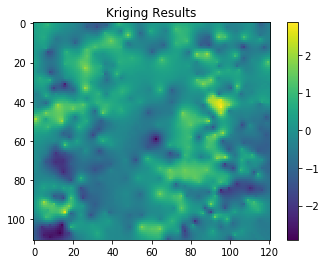

C:\Users\saryz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


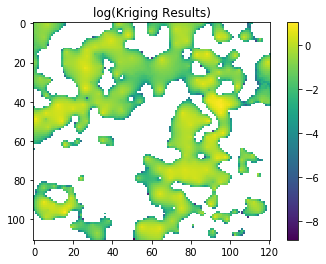

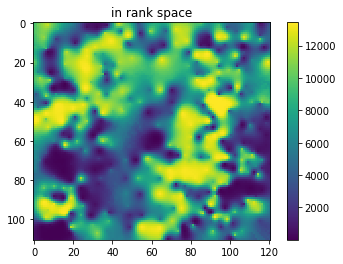

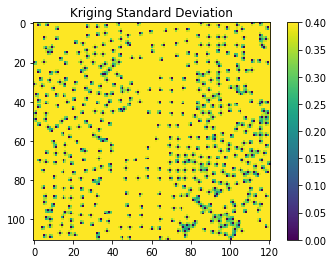

In [35]:
plt.title('Kriging Results')
plt.imshow(interpolation_kri,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('log(Kriging Results)')
plt.imshow(np.log(interpolation_kri),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('in rank space')
plt.imshow(sst.rankdata(interpolation_kri.flatten()).reshape(Z.shape[0], Z.shape[1]),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(std_kri,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Kriging standar deviation map.png', dpi=300) #save a nice .png of this map.
plt.show()

### Random path function

In [40]:
#Montecarlo random path
# i_index, j_index = np.meshgrid(range(Z.shape[0]), range(Z.shape[1]), indexing='ij')#meshgrid with index 
# index = np.column_stack((np.concatenate(i_index), np.concatenate(j_index)))#rows and columns append in order to have a vector of all possible indexes (i,j) in the matrix 

# index_to_simulate = [i for i in index.tolist() if i not in observations_index]#Delete from the matrix the 'observed data'

def random_path(seed, index_to_simulate): 
    #This function gives a matrix of the length of the indexes in the matrix without the observed data. it gives 
    np.random.seed(seed)
    path = np.random.choice(len(index_to_simulate),size=len(index_to_simulate), replace=False)#gives random values to change the order of the indexes according to this list
    return np.array(index_to_simulate)[path]
    
coord_order = random_path(300,index_to_simulate)#Indexes random // 10 is the seed


# SGS

In [41]:
interpolation_sgs = Z
std_sgs = np.zeros((Z.shape[0],Z.shape[1]))
n_cond = 50
controls_sgs = controls
controlvalues_sgs = controlvalues
l =0


for n in coord_order:
    print (n)
    targets_sgs =  np.array([[Y[0,n[1]], X[n[0],0]]])#Select cell to calculate. It looks for the value of coordinates
    print(targets_sgs)
    ok_result = kri.krige_ok(controls_sgs
                       , targets_sgs
                       , controlvalues_sgs
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
    print ('ID \t x \t y \t est(z)')    
    for i, result in enumerate(ok_result):
        print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(l, targets_sgs[i][0], targets_sgs[i][1], result[1]))
        # the weights are stored in results[0] but not saved here
        interpolation_sgs[n[0], n[1]] = result[1]#Calculate kriging
        std_sgs[n[0], n[1]] = result[2]
        controlvalues_sgs = np.append(controlvalues_sgs,result[1])#Add cell to control values
    controls_sgs = np.append(controls_sgs, [targets_sgs], axis =0)#Add cell to control coordinates
    l = l+1
    #Add cell to n_cond NOT SURE



[18 37]
[[37000 18000]]
ID 	 x 	 y 	 est(z)
 0	37000.00	18000.00	0.08
[ 8 27]
[[27000  8000]]
ID 	 x 	 y 	 est(z)
 1	27000.00	8000.00	0.07
[ 9 31]
[[31000  9000]]
ID 	 x 	 y 	 est(z)
 2	31000.00	9000.00	0.53
[15 47]
[[47000 15000]]
ID 	 x 	 y 	 est(z)
 3	47000.00	15000.00	0.40
[57 69]
[[69000 57000]]
ID 	 x 	 y 	 est(z)
 4	69000.00	57000.00	-0.02
[44 69]
[[69000 44000]]
ID 	 x 	 y 	 est(z)
 5	69000.00	44000.00	-0.48
[12 72]
[[72000 12000]]
ID 	 x 	 y 	 est(z)
 6	72000.00	12000.00	0.58
[44 76]
[[76000 44000]]
ID 	 x 	 y 	 est(z)
 7	76000.00	44000.00	0.83
[77 95]
[[95000 77000]]
ID 	 x 	 y 	 est(z)
 8	95000.00	77000.00	0.66
[60 45]
[[45000 60000]]
ID 	 x 	 y 	 est(z)
 9	45000.00	60000.00	-0.23
[37 11]
[[11000 37000]]
ID 	 x 	 y 	 est(z)
10	11000.00	37000.00	0.16
[52 25]
[[25000 52000]]
ID 	 x 	 y 	 est(z)
11	25000.00	52000.00	0.49
[95 80]
[[80000 95000]]
ID 	 x 	 y 	 est(z)
12	80000.00	95000.00	0.29
[24 33]
[[33000 24000]]
ID 	 x 	 y 	 est(z)
13	33000.00	24000.00	0.63
[ 9 49]
[[49000  90

116	101000.00	103000.00	-0.71
[105  69]
[[ 69000 105000]]
ID 	 x 	 y 	 est(z)
117	69000.00	105000.00	0.39
[28 71]
[[71000 28000]]
ID 	 x 	 y 	 est(z)
118	71000.00	28000.00	0.17
[ 77 102]
[[102000  77000]]
ID 	 x 	 y 	 est(z)
119	102000.00	77000.00	-0.31
[69 69]
[[69000 69000]]
ID 	 x 	 y 	 est(z)
120	69000.00	69000.00	-0.71
[15 46]
[[46000 15000]]
ID 	 x 	 y 	 est(z)
121	46000.00	15000.00	0.48
[79 65]
[[65000 79000]]
ID 	 x 	 y 	 est(z)
122	65000.00	79000.00	0.32
[75 50]
[[50000 75000]]
ID 	 x 	 y 	 est(z)
123	50000.00	75000.00	-0.36
[ 86 102]
[[102000  86000]]
ID 	 x 	 y 	 est(z)
124	102000.00	86000.00	-1.45
[101  15]
[[ 15000 101000]]
ID 	 x 	 y 	 est(z)
125	15000.00	101000.00	-1.09
[60 97]
[[97000 60000]]
ID 	 x 	 y 	 est(z)
126	97000.00	60000.00	-0.83
[107  91]
[[ 91000 107000]]
ID 	 x 	 y 	 est(z)
127	91000.00	107000.00	0.36
[ 86 115]
[[115000  86000]]
ID 	 x 	 y 	 est(z)
128	115000.00	86000.00	-1.21
[90 59]
[[59000 90000]]
ID 	 x 	 y 	 est(z)
129	59000.00	90000.00	0.09
[63 69]
[[

231	77000.00	16000.00	-0.22
[109  57]
[[ 57000 109000]]
ID 	 x 	 y 	 est(z)
232	57000.00	109000.00	0.71
[72 99]
[[99000 72000]]
ID 	 x 	 y 	 est(z)
233	99000.00	72000.00	-0.92
[ 6 85]
[[85000  6000]]
ID 	 x 	 y 	 est(z)
234	85000.00	6000.00	-0.62
[43 83]
[[83000 43000]]
ID 	 x 	 y 	 est(z)
235	83000.00	43000.00	0.14
[10 53]
[[53000 10000]]
ID 	 x 	 y 	 est(z)
236	53000.00	10000.00	-0.24
[57 72]
[[72000 57000]]
ID 	 x 	 y 	 est(z)
237	72000.00	57000.00	0.46
[19 86]
[[86000 19000]]
ID 	 x 	 y 	 est(z)
238	86000.00	19000.00	0.83
[ 9 16]
[[16000  9000]]
ID 	 x 	 y 	 est(z)
239	16000.00	9000.00	-0.34
[62 57]
[[57000 62000]]
ID 	 x 	 y 	 est(z)
240	57000.00	62000.00	-1.21
[46 40]
[[40000 46000]]
ID 	 x 	 y 	 est(z)
241	40000.00	46000.00	0.34
[63 83]
[[83000 63000]]
ID 	 x 	 y 	 est(z)
242	83000.00	63000.00	0.37
[89 70]
[[70000 89000]]
ID 	 x 	 y 	 est(z)
243	70000.00	89000.00	0.93
[ 68 103]
[[103000  68000]]
ID 	 x 	 y 	 est(z)
244	103000.00	68000.00	-0.27
[69 51]
[[51000 69000]]
ID 	 x 	 y 

346	51000.00	57000.00	-0.49
[18 95]
[[95000 18000]]
ID 	 x 	 y 	 est(z)
347	95000.00	18000.00	0.10
[110  88]
[[ 88000 110000]]
ID 	 x 	 y 	 est(z)
348	88000.00	110000.00	-0.10
[31 81]
[[81000 31000]]
ID 	 x 	 y 	 est(z)
349	81000.00	31000.00	0.53
[27 79]
[[79000 27000]]
ID 	 x 	 y 	 est(z)
350	79000.00	27000.00	0.18
[93 73]
[[73000 93000]]
ID 	 x 	 y 	 est(z)
351	73000.00	93000.00	0.83
[60 41]
[[41000 60000]]
ID 	 x 	 y 	 est(z)
352	41000.00	60000.00	0.01
[93 80]
[[80000 93000]]
ID 	 x 	 y 	 est(z)
353	80000.00	93000.00	0.28
[52 29]
[[29000 52000]]
ID 	 x 	 y 	 est(z)
354	29000.00	52000.00	-0.28
[78 46]
[[46000 78000]]
ID 	 x 	 y 	 est(z)
355	46000.00	78000.00	-0.54
[94 27]
[[27000 94000]]
ID 	 x 	 y 	 est(z)
356	27000.00	94000.00	-0.49
[63 64]
[[64000 63000]]
ID 	 x 	 y 	 est(z)
357	64000.00	63000.00	-0.91
[12 84]
[[84000 12000]]
ID 	 x 	 y 	 est(z)
358	84000.00	12000.00	-0.41
[ 52 114]
[[114000  52000]]
ID 	 x 	 y 	 est(z)
359	114000.00	52000.00	-0.73
[68 80]
[[80000 68000]]
ID 	 x 	

460	119000.00	12000.00	-0.66
[ 16 112]
[[112000  16000]]
ID 	 x 	 y 	 est(z)
461	112000.00	16000.00	-0.36
[96 47]
[[47000 96000]]
ID 	 x 	 y 	 est(z)
462	47000.00	96000.00	-0.52
[ 32 115]
[[115000  32000]]
ID 	 x 	 y 	 est(z)
463	115000.00	32000.00	0.05
[64 18]
[[18000 64000]]
ID 	 x 	 y 	 est(z)
464	18000.00	64000.00	-0.24
[82 37]
[[37000 82000]]
ID 	 x 	 y 	 est(z)
465	37000.00	82000.00	-0.58
[43 79]
[[79000 43000]]
ID 	 x 	 y 	 est(z)
466	79000.00	43000.00	0.53
[58 65]
[[65000 58000]]
ID 	 x 	 y 	 est(z)
467	65000.00	58000.00	-1.11
[24  9]
[[ 9000 24000]]
ID 	 x 	 y 	 est(z)
468	9000.00	24000.00	-1.11
[ 49 100]
[[100000  49000]]
ID 	 x 	 y 	 est(z)
469	100000.00	49000.00	0.03
[28  0]
[[    0 28000]]
ID 	 x 	 y 	 est(z)
470	0.00	28000.00	0.28
[100  32]
[[ 32000 100000]]
ID 	 x 	 y 	 est(z)
471	32000.00	100000.00	-0.26
[59 46]
[[46000 59000]]
ID 	 x 	 y 	 est(z)
472	46000.00	59000.00	-0.30
[31 65]
[[65000 31000]]
ID 	 x 	 y 	 est(z)
473	65000.00	31000.00	0.40
[54 77]
[[77000 54000]]
I

574	26000.00	43000.00	0.94
[ 14 103]
[[103000  14000]]
ID 	 x 	 y 	 est(z)
575	103000.00	14000.00	-0.07
[70 10]
[[10000 70000]]
ID 	 x 	 y 	 est(z)
576	10000.00	70000.00	-1.91
[31 63]
[[63000 31000]]
ID 	 x 	 y 	 est(z)
577	63000.00	31000.00	0.42
[ 76 108]
[[108000  76000]]
ID 	 x 	 y 	 est(z)
578	108000.00	76000.00	0.22
[110  80]
[[ 80000 110000]]
ID 	 x 	 y 	 est(z)
579	80000.00	110000.00	-0.73
[76 54]
[[54000 76000]]
ID 	 x 	 y 	 est(z)
580	54000.00	76000.00	-0.03
[101  51]
[[ 51000 101000]]
ID 	 x 	 y 	 est(z)
581	51000.00	101000.00	-0.32
[68 49]
[[49000 68000]]
ID 	 x 	 y 	 est(z)
582	49000.00	68000.00	-0.68
[12 76]
[[76000 12000]]
ID 	 x 	 y 	 est(z)
583	76000.00	12000.00	0.46
[51 30]
[[30000 51000]]
ID 	 x 	 y 	 est(z)
584	30000.00	51000.00	-0.42
[ 0 50]
[[50000     0]]
ID 	 x 	 y 	 est(z)
585	50000.00	0.00	0.06
[ 67 114]
[[114000  67000]]
ID 	 x 	 y 	 est(z)
586	114000.00	67000.00	-0.42
[78  3]
[[ 3000 78000]]
ID 	 x 	 y 	 est(z)
587	3000.00	78000.00	-0.25
[ 58 101]
[[101000  5

688	34000.00	38000.00	0.61
[77 49]
[[49000 77000]]
ID 	 x 	 y 	 est(z)
689	49000.00	77000.00	-0.33
[104  86]
[[ 86000 104000]]
ID 	 x 	 y 	 est(z)
690	86000.00	104000.00	-0.47
[ 7 92]
[[92000  7000]]
ID 	 x 	 y 	 est(z)
691	92000.00	7000.00	0.53
[26  2]
[[ 2000 26000]]
ID 	 x 	 y 	 est(z)
692	2000.00	26000.00	0.13
[90  7]
[[ 7000 90000]]
ID 	 x 	 y 	 est(z)
693	7000.00	90000.00	0.78
[68 78]
[[78000 68000]]
ID 	 x 	 y 	 est(z)
694	78000.00	68000.00	0.83
[14 67]
[[67000 14000]]
ID 	 x 	 y 	 est(z)
695	67000.00	14000.00	-0.06
[ 93 105]
[[105000  93000]]
ID 	 x 	 y 	 est(z)
696	105000.00	93000.00	-0.52
[18 41]
[[41000 18000]]
ID 	 x 	 y 	 est(z)
697	41000.00	18000.00	0.45
[58 44]
[[44000 58000]]
ID 	 x 	 y 	 est(z)
698	44000.00	58000.00	-0.21
[43 20]
[[20000 43000]]
ID 	 x 	 y 	 est(z)
699	20000.00	43000.00	1.43
[77 55]
[[55000 77000]]
ID 	 x 	 y 	 est(z)
700	55000.00	77000.00	0.08
[15 53]
[[53000 15000]]
ID 	 x 	 y 	 est(z)
701	53000.00	15000.00	0.18
[19 33]
[[33000 19000]]
ID 	 x 	 y 	 e

803	64000.00	36000.00	0.32
[ 50 110]
[[110000  50000]]
ID 	 x 	 y 	 est(z)
804	110000.00	50000.00	-0.50
[37 79]
[[79000 37000]]
ID 	 x 	 y 	 est(z)
805	79000.00	37000.00	-0.02
[23 46]
[[46000 23000]]
ID 	 x 	 y 	 est(z)
806	46000.00	23000.00	0.48
[68 31]
[[31000 68000]]
ID 	 x 	 y 	 est(z)
807	31000.00	68000.00	-0.71
[99 23]
[[23000 99000]]
ID 	 x 	 y 	 est(z)
808	23000.00	99000.00	0.00
[89 44]
[[44000 89000]]
ID 	 x 	 y 	 est(z)
809	44000.00	89000.00	-0.34
[ 3 60]
[[60000  3000]]
ID 	 x 	 y 	 est(z)
810	60000.00	3000.00	0.42
[37  3]
[[ 3000 37000]]
ID 	 x 	 y 	 est(z)
811	3000.00	37000.00	-0.16
[92 78]
[[78000 92000]]
ID 	 x 	 y 	 est(z)
812	78000.00	92000.00	0.55
[66 48]
[[48000 66000]]
ID 	 x 	 y 	 est(z)
813	48000.00	66000.00	-0.55
[ 58 116]
[[116000  58000]]
ID 	 x 	 y 	 est(z)
814	116000.00	58000.00	-0.92
[ 90 114]
[[114000  90000]]
ID 	 x 	 y 	 est(z)
815	114000.00	90000.00	0.17
[60 57]
[[57000 60000]]
ID 	 x 	 y 	 est(z)
816	57000.00	60000.00	-1.22
[23 38]
[[38000 23000]]
ID 	 

918	86000.00	20000.00	0.55
[42 32]
[[32000 42000]]
ID 	 x 	 y 	 est(z)
919	32000.00	42000.00	0.54
[60 90]
[[90000 60000]]
ID 	 x 	 y 	 est(z)
920	90000.00	60000.00	1.23
[50 86]
[[86000 50000]]
ID 	 x 	 y 	 est(z)
921	86000.00	50000.00	1.07
[31 55]
[[55000 31000]]
ID 	 x 	 y 	 est(z)
922	55000.00	31000.00	0.07
[42 50]
[[50000 42000]]
ID 	 x 	 y 	 est(z)
923	50000.00	42000.00	0.19
[52 54]
[[54000 52000]]
ID 	 x 	 y 	 est(z)
924	54000.00	52000.00	-0.49
[80  2]
[[ 2000 80000]]
ID 	 x 	 y 	 est(z)
925	2000.00	80000.00	-0.11
[108  99]
[[ 99000 108000]]
ID 	 x 	 y 	 est(z)
926	99000.00	108000.00	-0.56
[90 18]
[[18000 90000]]
ID 	 x 	 y 	 est(z)
927	18000.00	90000.00	0.77
[31 85]
[[85000 31000]]
ID 	 x 	 y 	 est(z)
928	85000.00	31000.00	1.32
[100  86]
[[ 86000 100000]]
ID 	 x 	 y 	 est(z)
929	86000.00	100000.00	-0.38
[10 26]
[[26000 10000]]
ID 	 x 	 y 	 est(z)
930	26000.00	10000.00	0.22
[14 64]
[[64000 14000]]
ID 	 x 	 y 	 est(z)
931	64000.00	14000.00	-0.36
[66 24]
[[24000 66000]]
ID 	 x 	 y 	

1031	9000.00	54000.00	0.36
[ 49 111]
[[111000  49000]]
ID 	 x 	 y 	 est(z)
1032	111000.00	49000.00	-0.55
[64 94]
[[94000 64000]]
ID 	 x 	 y 	 est(z)
1033	94000.00	64000.00	0.44
[ 7 14]
[[14000  7000]]
ID 	 x 	 y 	 est(z)
1034	14000.00	7000.00	-0.36
[ 72 107]
[[107000  72000]]
ID 	 x 	 y 	 est(z)
1035	107000.00	72000.00	0.30
[13  1]
[[ 1000 13000]]
ID 	 x 	 y 	 est(z)
1036	1000.00	13000.00	0.18
[70 76]
[[76000 70000]]
ID 	 x 	 y 	 est(z)
1037	76000.00	70000.00	0.75
[ 2 25]
[[25000  2000]]
ID 	 x 	 y 	 est(z)
1038	25000.00	2000.00	-0.74
[ 9 58]
[[58000  9000]]
ID 	 x 	 y 	 est(z)
1039	58000.00	9000.00	-0.31
[ 65 118]
[[118000  65000]]
ID 	 x 	 y 	 est(z)
1040	118000.00	65000.00	-1.08
[20 52]
[[52000 20000]]
ID 	 x 	 y 	 est(z)
1041	52000.00	20000.00	0.53
[66  7]
[[ 7000 66000]]
ID 	 x 	 y 	 est(z)
1042	7000.00	66000.00	-0.73
[80 56]
[[56000 80000]]
ID 	 x 	 y 	 est(z)
1043	56000.00	80000.00	0.12
[12 96]
[[96000 12000]]
ID 	 x 	 y 	 est(z)
1044	96000.00	12000.00	-0.52
[38  1]
[[ 1000 3800

1143	88000.00	50000.00	1.64
[97 79]
[[79000 97000]]
ID 	 x 	 y 	 est(z)
1144	79000.00	97000.00	0.21
[96 33]
[[33000 96000]]
ID 	 x 	 y 	 est(z)
1145	33000.00	96000.00	-0.59
[56 87]
[[87000 56000]]
ID 	 x 	 y 	 est(z)
1146	87000.00	56000.00	0.09
[23 37]
[[37000 23000]]
ID 	 x 	 y 	 est(z)
1147	37000.00	23000.00	-0.07
[ 4 95]
[[95000  4000]]
ID 	 x 	 y 	 est(z)
1148	95000.00	4000.00	0.62
[21 30]
[[30000 21000]]
ID 	 x 	 y 	 est(z)
1149	30000.00	21000.00	0.80
[59 70]
[[70000 59000]]
ID 	 x 	 y 	 est(z)
1150	70000.00	59000.00	0.25
[83 75]
[[75000 83000]]
ID 	 x 	 y 	 est(z)
1151	75000.00	83000.00	-0.21
[13 25]
[[25000 13000]]
ID 	 x 	 y 	 est(z)
1152	25000.00	13000.00	0.61
[68 72]
[[72000 68000]]
ID 	 x 	 y 	 est(z)
1153	72000.00	68000.00	-0.71
[49 70]
[[70000 49000]]
ID 	 x 	 y 	 est(z)
1154	70000.00	49000.00	0.02
[19 37]
[[37000 19000]]
ID 	 x 	 y 	 est(z)
1155	37000.00	19000.00	-0.01
[  8 110]
[[110000   8000]]
ID 	 x 	 y 	 est(z)
1156	110000.00	8000.00	0.16
[35  8]
[[ 8000 35000]]
ID 	

1254	93000.00	71000.00	0.61
[ 94 120]
[[120000  94000]]
ID 	 x 	 y 	 est(z)
1255	120000.00	94000.00	-0.19
[97 63]
[[63000 97000]]
ID 	 x 	 y 	 est(z)
1256	63000.00	97000.00	-0.11
[ 25 117]
[[117000  25000]]
ID 	 x 	 y 	 est(z)
1257	117000.00	25000.00	0.32
[14 68]
[[68000 14000]]
ID 	 x 	 y 	 est(z)
1258	68000.00	14000.00	0.06
[ 4 81]
[[81000  4000]]
ID 	 x 	 y 	 est(z)
1259	81000.00	4000.00	0.34
[46 79]
[[79000 46000]]
ID 	 x 	 y 	 est(z)
1260	79000.00	46000.00	1.06
[ 59 102]
[[102000  59000]]
ID 	 x 	 y 	 est(z)
1261	102000.00	59000.00	-0.59
[55 33]
[[33000 55000]]
ID 	 x 	 y 	 est(z)
1262	33000.00	55000.00	-1.12
[57 62]
[[62000 57000]]
ID 	 x 	 y 	 est(z)
1263	62000.00	57000.00	-1.73
[35 61]
[[61000 35000]]
ID 	 x 	 y 	 est(z)
1264	61000.00	35000.00	0.14
[55 60]
[[60000 55000]]
ID 	 x 	 y 	 est(z)
1265	60000.00	55000.00	-0.99
[67  9]
[[ 9000 67000]]
ID 	 x 	 y 	 est(z)
1266	9000.00	67000.00	-1.46
[28 91]
[[91000 28000]]
ID 	 x 	 y 	 est(z)
1267	91000.00	28000.00	0.97
[55 20]
[[20000 

1367	0.00	37000.00	-0.25
[62  7]
[[ 7000 62000]]
ID 	 x 	 y 	 est(z)
1368	7000.00	62000.00	-0.35
[20 79]
[[79000 20000]]
ID 	 x 	 y 	 est(z)
1369	79000.00	20000.00	0.15
[55 45]
[[45000 55000]]
ID 	 x 	 y 	 est(z)
1370	45000.00	55000.00	-0.24
[95 75]
[[75000 95000]]
ID 	 x 	 y 	 est(z)
1371	75000.00	95000.00	1.19
[61  4]
[[ 4000 61000]]
ID 	 x 	 y 	 est(z)
1372	4000.00	61000.00	-0.06
[ 64 116]
[[116000  64000]]
ID 	 x 	 y 	 est(z)
1373	116000.00	64000.00	-1.16
[92  8]
[[ 8000 92000]]
ID 	 x 	 y 	 est(z)
1374	8000.00	92000.00	1.21
[75 74]
[[74000 75000]]
ID 	 x 	 y 	 est(z)
1375	74000.00	75000.00	1.28
[40 99]
[[99000 40000]]
ID 	 x 	 y 	 est(z)
1376	99000.00	40000.00	1.53
[24 31]
[[31000 24000]]
ID 	 x 	 y 	 est(z)
1377	31000.00	24000.00	0.86
[59 63]
[[63000 59000]]
ID 	 x 	 y 	 est(z)
1378	63000.00	59000.00	-2.21
[ 80 118]
[[118000  80000]]
ID 	 x 	 y 	 est(z)
1379	118000.00	80000.00	-0.65
[65  2]
[[ 2000 65000]]
ID 	 x 	 y 	 est(z)
1380	2000.00	65000.00	-0.19
[ 66 120]
[[120000  66000]

[91 16]
[[16000 91000]]
ID 	 x 	 y 	 est(z)
1480	16000.00	91000.00	0.24
[53 59]
[[59000 53000]]
ID 	 x 	 y 	 est(z)
1481	59000.00	53000.00	-0.67
[63 60]
[[60000 63000]]
ID 	 x 	 y 	 est(z)
1482	60000.00	63000.00	-1.28
[48  4]
[[ 4000 48000]]
ID 	 x 	 y 	 est(z)
1483	4000.00	48000.00	1.01
[37 20]
[[20000 37000]]
ID 	 x 	 y 	 est(z)
1484	20000.00	37000.00	-0.11
[33 48]
[[48000 33000]]
ID 	 x 	 y 	 est(z)
1485	48000.00	33000.00	0.50
[85 24]
[[24000 85000]]
ID 	 x 	 y 	 est(z)
1486	24000.00	85000.00	-1.39
[99 68]
[[68000 99000]]
ID 	 x 	 y 	 est(z)
1487	68000.00	99000.00	0.33
[ 73 102]
[[102000  73000]]
ID 	 x 	 y 	 est(z)
1488	102000.00	73000.00	-0.88
[85 94]
[[94000 85000]]
ID 	 x 	 y 	 est(z)
1489	94000.00	85000.00	-1.02
[ 29 102]
[[102000  29000]]
ID 	 x 	 y 	 est(z)
1490	102000.00	29000.00	0.40
[27 81]
[[81000 27000]]
ID 	 x 	 y 	 est(z)
1491	81000.00	27000.00	0.23
[97 52]
[[52000 97000]]
ID 	 x 	 y 	 est(z)
1492	52000.00	97000.00	-0.62
[17 71]
[[71000 17000]]
ID 	 x 	 y 	 est(z)
1493

1592	22000.00	103000.00	0.28
[43 49]
[[49000 43000]]
ID 	 x 	 y 	 est(z)
1593	49000.00	43000.00	0.23
[33  6]
[[ 6000 33000]]
ID 	 x 	 y 	 est(z)
1594	6000.00	33000.00	0.04
[93 59]
[[59000 93000]]
ID 	 x 	 y 	 est(z)
1595	59000.00	93000.00	-0.09
[ 7 74]
[[74000  7000]]
ID 	 x 	 y 	 est(z)
1596	74000.00	7000.00	0.87
[65 49]
[[49000 65000]]
ID 	 x 	 y 	 est(z)
1597	49000.00	65000.00	-0.59
[38 46]
[[46000 38000]]
ID 	 x 	 y 	 est(z)
1598	46000.00	38000.00	0.34
[73 84]
[[84000 73000]]
ID 	 x 	 y 	 est(z)
1599	84000.00	73000.00	1.08
[79  6]
[[ 6000 79000]]
ID 	 x 	 y 	 est(z)
1600	6000.00	79000.00	-0.24
[50 67]
[[67000 50000]]
ID 	 x 	 y 	 est(z)
1601	67000.00	50000.00	-0.20
[29 48]
[[48000 29000]]
ID 	 x 	 y 	 est(z)
1602	48000.00	29000.00	0.21
[76 87]
[[87000 76000]]
ID 	 x 	 y 	 est(z)
1603	87000.00	76000.00	1.26
[ 58 110]
[[110000  58000]]
ID 	 x 	 y 	 est(z)
1604	110000.00	58000.00	-0.73
[62 67]
[[67000 62000]]
ID 	 x 	 y 	 est(z)
1605	67000.00	62000.00	-0.15
[10 28]
[[28000 10000]]
ID 

1705	50000.00	41000.00	0.16
[32 82]
[[82000 32000]]
ID 	 x 	 y 	 est(z)
1706	82000.00	32000.00	0.57
[69 11]
[[11000 69000]]
ID 	 x 	 y 	 est(z)
1707	11000.00	69000.00	-1.95
[62 19]
[[19000 62000]]
ID 	 x 	 y 	 est(z)
1708	19000.00	62000.00	0.10
[49 47]
[[47000 49000]]
ID 	 x 	 y 	 est(z)
1709	47000.00	49000.00	0.02
[56 12]
[[12000 56000]]
ID 	 x 	 y 	 est(z)
1710	12000.00	56000.00	-0.27
[55  7]
[[ 7000 55000]]
ID 	 x 	 y 	 est(z)
1711	7000.00	55000.00	0.47
[99 33]
[[33000 99000]]
ID 	 x 	 y 	 est(z)
1712	33000.00	99000.00	-0.27
[ 83 105]
[[105000  83000]]
ID 	 x 	 y 	 est(z)
1713	105000.00	83000.00	-1.62
[98 11]
[[11000 98000]]
ID 	 x 	 y 	 est(z)
1714	11000.00	98000.00	0.63
[68 44]
[[44000 68000]]
ID 	 x 	 y 	 est(z)
1715	44000.00	68000.00	-0.42
[26 43]
[[43000 26000]]
ID 	 x 	 y 	 est(z)
1716	43000.00	26000.00	0.60
[88 18]
[[18000 88000]]
ID 	 x 	 y 	 est(z)
1717	18000.00	88000.00	0.49
[55 69]
[[69000 55000]]
ID 	 x 	 y 	 est(z)
1718	69000.00	55000.00	-0.00
[1 8]
[[8000 1000]]
ID 	 x

1817	74000.00	39000.00	-0.24
[ 2 52]
[[52000  2000]]
ID 	 x 	 y 	 est(z)
1818	52000.00	2000.00	-0.18
[96 68]
[[68000 96000]]
ID 	 x 	 y 	 est(z)
1819	68000.00	96000.00	0.12
[ 9 45]
[[45000  9000]]
ID 	 x 	 y 	 est(z)
1820	45000.00	9000.00	0.55
[ 79 110]
[[110000  79000]]
ID 	 x 	 y 	 est(z)
1821	110000.00	79000.00	-0.73
[100  80]
[[ 80000 100000]]
ID 	 x 	 y 	 est(z)
1822	80000.00	100000.00	-0.62
[43 77]
[[77000 43000]]
ID 	 x 	 y 	 est(z)
1823	77000.00	43000.00	0.60
[32  9]
[[ 9000 32000]]
ID 	 x 	 y 	 est(z)
1824	9000.00	32000.00	-0.95
[54  4]
[[ 4000 54000]]
ID 	 x 	 y 	 est(z)
1825	4000.00	54000.00	0.64
[14 43]
[[43000 14000]]
ID 	 x 	 y 	 est(z)
1826	43000.00	14000.00	0.74
[19 42]
[[42000 19000]]
ID 	 x 	 y 	 est(z)
1827	42000.00	19000.00	0.53
[16 33]
[[33000 16000]]
ID 	 x 	 y 	 est(z)
1828	33000.00	16000.00	0.28
[53 33]
[[33000 53000]]
ID 	 x 	 y 	 est(z)
1829	33000.00	53000.00	-1.16
[ 18 118]
[[118000  18000]]
ID 	 x 	 y 	 est(z)
1830	118000.00	18000.00	0.40
[95 93]
[[93000 950

1929	103000.00	100000.00	-0.37
[62 33]
[[33000 62000]]
ID 	 x 	 y 	 est(z)
1930	33000.00	62000.00	-0.32
[107  37]
[[ 37000 107000]]
ID 	 x 	 y 	 est(z)
1931	37000.00	107000.00	-0.04
[ 4 50]
[[50000  4000]]
ID 	 x 	 y 	 est(z)
1932	50000.00	4000.00	0.45
[20 70]
[[70000 20000]]
ID 	 x 	 y 	 est(z)
1933	70000.00	20000.00	0.48
[90 47]
[[47000 90000]]
ID 	 x 	 y 	 est(z)
1934	47000.00	90000.00	-0.26
[50 54]
[[54000 50000]]
ID 	 x 	 y 	 est(z)
1935	54000.00	50000.00	-0.46
[ 35 110]
[[110000  35000]]
ID 	 x 	 y 	 est(z)
1936	110000.00	35000.00	-0.22
[97 82]
[[82000 97000]]
ID 	 x 	 y 	 est(z)
1937	82000.00	97000.00	-0.04
[33 39]
[[39000 33000]]
ID 	 x 	 y 	 est(z)
1938	39000.00	33000.00	0.04
[18 97]
[[97000 18000]]
ID 	 x 	 y 	 est(z)
1939	97000.00	18000.00	0.04
[43 92]
[[92000 43000]]
ID 	 x 	 y 	 est(z)
1940	92000.00	43000.00	1.98
[10 63]
[[63000 10000]]
ID 	 x 	 y 	 est(z)
1941	63000.00	10000.00	-0.58
[14  7]
[[ 7000 14000]]
ID 	 x 	 y 	 est(z)
1942	7000.00	14000.00	-0.88
[ 54 113]
[[11300

2041	18000.00	10000.00	-0.38
[34  3]
[[ 3000 34000]]
ID 	 x 	 y 	 est(z)
2042	3000.00	34000.00	0.09
[53 13]
[[13000 53000]]
ID 	 x 	 y 	 est(z)
2043	13000.00	53000.00	0.42
[77 12]
[[12000 77000]]
ID 	 x 	 y 	 est(z)
2044	12000.00	77000.00	-1.24
[104  37]
[[ 37000 104000]]
ID 	 x 	 y 	 est(z)
2045	37000.00	104000.00	0.06
[98 72]
[[72000 98000]]
ID 	 x 	 y 	 est(z)
2046	72000.00	98000.00	0.48
[100  70]
[[ 70000 100000]]
ID 	 x 	 y 	 est(z)
2047	70000.00	100000.00	0.69
[43 47]
[[47000 43000]]
ID 	 x 	 y 	 est(z)
2048	47000.00	43000.00	0.34
[32 97]
[[97000 32000]]
ID 	 x 	 y 	 est(z)
2049	97000.00	32000.00	-0.33
[103  47]
[[ 47000 103000]]
ID 	 x 	 y 	 est(z)
2050	47000.00	103000.00	-0.58
[106  61]
[[ 61000 106000]]
ID 	 x 	 y 	 est(z)
2051	61000.00	106000.00	1.26
[75 78]
[[78000 75000]]
ID 	 x 	 y 	 est(z)
2052	78000.00	75000.00	1.46
[68  4]
[[ 4000 68000]]
ID 	 x 	 y 	 est(z)
2053	4000.00	68000.00	-0.48
[102 109]
[[109000 102000]]
ID 	 x 	 y 	 est(z)
2054	109000.00	102000.00	-0.17
[23 52

2152	109000.00	4000.00	0.14
[79 19]
[[19000 79000]]
ID 	 x 	 y 	 est(z)
2153	19000.00	79000.00	-1.40
[38 53]
[[53000 38000]]
ID 	 x 	 y 	 est(z)
2154	53000.00	38000.00	0.13
[78 91]
[[91000 78000]]
ID 	 x 	 y 	 est(z)
2155	91000.00	78000.00	0.73
[43 44]
[[44000 43000]]
ID 	 x 	 y 	 est(z)
2156	44000.00	43000.00	0.57
[18 89]
[[89000 18000]]
ID 	 x 	 y 	 est(z)
2157	89000.00	18000.00	1.16
[74  2]
[[ 2000 74000]]
ID 	 x 	 y 	 est(z)
2158	2000.00	74000.00	-0.36
[84 97]
[[97000 84000]]
ID 	 x 	 y 	 est(z)
2159	97000.00	84000.00	-1.08
[100  50]
[[ 50000 100000]]
ID 	 x 	 y 	 est(z)
2160	50000.00	100000.00	-0.56
[46 22]
[[22000 46000]]
ID 	 x 	 y 	 est(z)
2161	22000.00	46000.00	0.56
[34 83]
[[83000 34000]]
ID 	 x 	 y 	 est(z)
2162	83000.00	34000.00	0.24
[29 71]
[[71000 29000]]
ID 	 x 	 y 	 est(z)
2163	71000.00	29000.00	0.07
[63 81]
[[81000 63000]]
ID 	 x 	 y 	 est(z)
2164	81000.00	63000.00	0.62
[89 29]
[[29000 89000]]
ID 	 x 	 y 	 est(z)
2165	29000.00	89000.00	-1.05
[ 7 57]
[[57000  7000]]
ID 

2264	117000.00	88000.00	-0.60
[ 20 105]
[[105000  20000]]
ID 	 x 	 y 	 est(z)
2265	105000.00	20000.00	-0.53
[48 81]
[[81000 48000]]
ID 	 x 	 y 	 est(z)
2266	81000.00	48000.00	1.12
[ 94 106]
[[106000  94000]]
ID 	 x 	 y 	 est(z)
2267	106000.00	94000.00	-0.32
[53 31]
[[31000 53000]]
ID 	 x 	 y 	 est(z)
2268	31000.00	53000.00	-0.91
[84 85]
[[85000 84000]]
ID 	 x 	 y 	 est(z)
2269	85000.00	84000.00	-0.25
[100  37]
[[ 37000 100000]]
ID 	 x 	 y 	 est(z)
2270	37000.00	100000.00	0.12
[ 34 120]
[[120000  34000]]
ID 	 x 	 y 	 est(z)
2271	120000.00	34000.00	0.16
[39 88]
[[88000 39000]]
ID 	 x 	 y 	 est(z)
2272	88000.00	39000.00	1.39
[78 15]
[[15000 78000]]
ID 	 x 	 y 	 est(z)
2273	15000.00	78000.00	-1.52
[101  67]
[[ 67000 101000]]
ID 	 x 	 y 	 est(z)
2274	67000.00	101000.00	0.42
[ 88 107]
[[107000  88000]]
ID 	 x 	 y 	 est(z)
2275	107000.00	88000.00	-0.70
[72 60]
[[60000 72000]]
ID 	 x 	 y 	 est(z)
2276	60000.00	72000.00	0.41
[53 42]
[[42000 53000]]
ID 	 x 	 y 	 est(z)
2277	42000.00	53000.00	-0.

2377	112000.00	99000.00	-0.07
[ 5 61]
[[61000  5000]]
ID 	 x 	 y 	 est(z)
2378	61000.00	5000.00	0.27
[91 36]
[[36000 91000]]
ID 	 x 	 y 	 est(z)
2379	36000.00	91000.00	-0.69
[15 10]
[[10000 15000]]
ID 	 x 	 y 	 est(z)
2380	10000.00	15000.00	-0.91
[42 20]
[[20000 42000]]
ID 	 x 	 y 	 est(z)
2381	20000.00	42000.00	1.20
[95 37]
[[37000 95000]]
ID 	 x 	 y 	 est(z)
2382	37000.00	95000.00	-0.49
[77 40]
[[40000 77000]]
ID 	 x 	 y 	 est(z)
2383	40000.00	77000.00	-0.41
[ 52 109]
[[109000  52000]]
ID 	 x 	 y 	 est(z)
2384	109000.00	52000.00	-0.45
[70 23]
[[23000 70000]]
ID 	 x 	 y 	 est(z)
2385	23000.00	70000.00	-0.78
[52 28]
[[28000 52000]]
ID 	 x 	 y 	 est(z)
2386	28000.00	52000.00	-0.02
[ 1 68]
[[68000  1000]]
ID 	 x 	 y 	 est(z)
2387	68000.00	1000.00	0.19
[ 6 51]
[[51000  6000]]
ID 	 x 	 y 	 est(z)
2388	51000.00	6000.00	0.23
[33 22]
[[22000 33000]]
ID 	 x 	 y 	 est(z)
2389	22000.00	33000.00	-0.08
[110  15]
[[ 15000 110000]]
ID 	 x 	 y 	 est(z)
2390	15000.00	110000.00	-1.93
[19 92]
[[92000 19

2488	49000.00	37000.00	0.06
[62 79]
[[79000 62000]]
ID 	 x 	 y 	 est(z)
2489	79000.00	62000.00	0.92
[100 107]
[[107000 100000]]
ID 	 x 	 y 	 est(z)
2490	107000.00	100000.00	-0.13
[102  67]
[[ 67000 102000]]
ID 	 x 	 y 	 est(z)
2491	67000.00	102000.00	0.55
[9 1]
[[1000 9000]]
ID 	 x 	 y 	 est(z)
2492	1000.00	9000.00	0.33
[37 59]
[[59000 37000]]
ID 	 x 	 y 	 est(z)
2493	59000.00	37000.00	-0.08
[38 62]
[[62000 38000]]
ID 	 x 	 y 	 est(z)
2494	62000.00	38000.00	-0.04
[ 73 111]
[[111000  73000]]
ID 	 x 	 y 	 est(z)
2495	111000.00	73000.00	-0.15
[ 3 49]
[[49000  3000]]
ID 	 x 	 y 	 est(z)
2496	49000.00	3000.00	0.48
[ 68 101]
[[101000  68000]]
ID 	 x 	 y 	 est(z)
2497	101000.00	68000.00	-0.28
[92 57]
[[57000 92000]]
ID 	 x 	 y 	 est(z)
2498	57000.00	92000.00	-0.22
[63  6]
[[ 6000 63000]]
ID 	 x 	 y 	 est(z)
2499	6000.00	63000.00	-0.34
[62 54]
[[54000 62000]]
ID 	 x 	 y 	 est(z)
2500	54000.00	62000.00	-0.83
[81  8]
[[ 8000 81000]]
ID 	 x 	 y 	 est(z)
2501	8000.00	81000.00	-0.01
[32 51]
[[51000

2600	113000.00	39000.00	0.17
[46  0]
[[    0 46000]]
ID 	 x 	 y 	 est(z)
2601	0.00	46000.00	0.76
[70 18]
[[18000 70000]]
ID 	 x 	 y 	 est(z)
2602	18000.00	70000.00	-1.49
[29 45]
[[45000 29000]]
ID 	 x 	 y 	 est(z)
2603	45000.00	29000.00	0.03
[30 41]
[[41000 30000]]
ID 	 x 	 y 	 est(z)
2604	41000.00	30000.00	0.02
[107  60]
[[ 60000 107000]]
ID 	 x 	 y 	 est(z)
2605	60000.00	107000.00	1.10
[110  67]
[[ 67000 110000]]
ID 	 x 	 y 	 est(z)
2606	67000.00	110000.00	-0.66
[28 19]
[[19000 28000]]
ID 	 x 	 y 	 est(z)
2607	19000.00	28000.00	0.13
[89 18]
[[18000 89000]]
ID 	 x 	 y 	 est(z)
2608	18000.00	89000.00	0.68
[78 14]
[[14000 78000]]
ID 	 x 	 y 	 est(z)
2609	14000.00	78000.00	-1.38
[18 43]
[[43000 18000]]
ID 	 x 	 y 	 est(z)
2610	43000.00	18000.00	0.63
[29 32]
[[32000 29000]]
ID 	 x 	 y 	 est(z)
2611	32000.00	29000.00	0.26
[ 37 119]
[[119000  37000]]
ID 	 x 	 y 	 est(z)
2612	119000.00	37000.00	0.29
[76 46]
[[46000 76000]]
ID 	 x 	 y 	 est(z)
2613	46000.00	76000.00	-0.44
[ 91 108]
[[108000  

2712	24000.00	42000.00	1.17
[46 17]
[[17000 46000]]
ID 	 x 	 y 	 est(z)
2713	17000.00	46000.00	1.01
[98 90]
[[90000 98000]]
ID 	 x 	 y 	 est(z)
2714	90000.00	98000.00	-0.17
[51 78]
[[78000 51000]]
ID 	 x 	 y 	 est(z)
2715	78000.00	51000.00	1.26
[64 33]
[[33000 64000]]
ID 	 x 	 y 	 est(z)
2716	33000.00	64000.00	-0.99
[ 2 53]
[[53000  2000]]
ID 	 x 	 y 	 est(z)
2717	53000.00	2000.00	-0.33
[89 77]
[[77000 89000]]
ID 	 x 	 y 	 est(z)
2718	77000.00	89000.00	0.44
[  6 116]
[[116000   6000]]
ID 	 x 	 y 	 est(z)
2719	116000.00	6000.00	-0.50
[ 1 90]
[[90000  1000]]
ID 	 x 	 y 	 est(z)
2720	90000.00	1000.00	0.01
[97 21]
[[21000 97000]]
ID 	 x 	 y 	 est(z)
2721	21000.00	97000.00	-0.47
[82 95]
[[95000 82000]]
ID 	 x 	 y 	 est(z)
2722	95000.00	82000.00	0.65
[ 91 111]
[[111000  91000]]
ID 	 x 	 y 	 est(z)
2723	111000.00	91000.00	0.79
[86 15]
[[15000 86000]]
ID 	 x 	 y 	 est(z)
2724	15000.00	86000.00	-0.24
[79 87]
[[87000 79000]]
ID 	 x 	 y 	 est(z)
2725	87000.00	79000.00	0.81
[102  10]
[[ 10000 1020

2826	60000.00	36000.00	-0.02
[ 4 43]
[[43000  4000]]
ID 	 x 	 y 	 est(z)
2827	43000.00	4000.00	-0.07
[83 20]
[[20000 83000]]
ID 	 x 	 y 	 est(z)
2828	20000.00	83000.00	-0.05
[24 83]
[[83000 24000]]
ID 	 x 	 y 	 est(z)
2829	83000.00	24000.00	-0.25
[64 28]
[[28000 64000]]
ID 	 x 	 y 	 est(z)
2830	28000.00	64000.00	-0.32
[89 59]
[[59000 89000]]
ID 	 x 	 y 	 est(z)
2831	59000.00	89000.00	0.14
[53 96]
[[96000 53000]]
ID 	 x 	 y 	 est(z)
2832	96000.00	53000.00	0.64
[78 79]
[[79000 78000]]
ID 	 x 	 y 	 est(z)
2833	79000.00	78000.00	1.36
[91 15]
[[15000 91000]]
ID 	 x 	 y 	 est(z)
2834	15000.00	91000.00	-0.06
[19 38]
[[38000 19000]]
ID 	 x 	 y 	 est(z)
2835	38000.00	19000.00	0.05
[60 78]
[[78000 60000]]
ID 	 x 	 y 	 est(z)
2836	78000.00	60000.00	0.92
[15 37]
[[37000 15000]]
ID 	 x 	 y 	 est(z)
2837	37000.00	15000.00	0.45
[77 65]
[[65000 77000]]
ID 	 x 	 y 	 est(z)
2838	65000.00	77000.00	0.69
[79 13]
[[13000 79000]]
ID 	 x 	 y 	 est(z)
2839	13000.00	79000.00	-0.91
[92 60]
[[60000 92000]]
ID 	 x

[ 80 104]
[[104000  80000]]
ID 	 x 	 y 	 est(z)
2938	104000.00	80000.00	-1.11
[56 46]
[[46000 56000]]
ID 	 x 	 y 	 est(z)
2939	46000.00	56000.00	-0.27
[101  91]
[[ 91000 101000]]
ID 	 x 	 y 	 est(z)
2940	91000.00	101000.00	-0.10
[27  5]
[[ 5000 27000]]
ID 	 x 	 y 	 est(z)
2941	5000.00	27000.00	0.09
[71  9]
[[ 9000 71000]]
ID 	 x 	 y 	 est(z)
2942	9000.00	71000.00	-1.74
[110  85]
[[ 85000 110000]]
ID 	 x 	 y 	 est(z)
2943	85000.00	110000.00	-0.31
[17 75]
[[75000 17000]]
ID 	 x 	 y 	 est(z)
2944	75000.00	17000.00	0.14
[31  2]
[[ 2000 31000]]
ID 	 x 	 y 	 est(z)
2945	2000.00	31000.00	0.35
[ 3 19]
[[19000  3000]]
ID 	 x 	 y 	 est(z)
2946	19000.00	3000.00	-0.27
[29 56]
[[56000 29000]]
ID 	 x 	 y 	 est(z)
2947	56000.00	29000.00	0.14
[51 16]
[[16000 51000]]
ID 	 x 	 y 	 est(z)
2948	16000.00	51000.00	0.65
[ 1 50]
[[50000  1000]]
ID 	 x 	 y 	 est(z)
2949	50000.00	1000.00	0.11
[ 76 103]
[[103000  76000]]
ID 	 x 	 y 	 est(z)
2950	103000.00	76000.00	-0.25
[ 46 105]
[[105000  46000]]
ID 	 x 	 y 	 e

3049	74000.00	73000.00	1.06
[ 59 115]
[[115000  59000]]
ID 	 x 	 y 	 est(z)
3050	115000.00	59000.00	-0.88
[44 74]
[[74000 44000]]
ID 	 x 	 y 	 est(z)
3051	74000.00	44000.00	0.50
[98 53]
[[53000 98000]]
ID 	 x 	 y 	 est(z)
3052	53000.00	98000.00	-0.62
[58 34]
[[34000 58000]]
ID 	 x 	 y 	 est(z)
3053	34000.00	58000.00	0.21
[47  6]
[[ 6000 47000]]
ID 	 x 	 y 	 est(z)
3054	6000.00	47000.00	1.34
[ 7 69]
[[69000  7000]]
ID 	 x 	 y 	 est(z)
3055	69000.00	7000.00	0.15
[82 60]
[[60000 82000]]
ID 	 x 	 y 	 est(z)
3056	60000.00	82000.00	0.22
[24 28]
[[28000 24000]]
ID 	 x 	 y 	 est(z)
3057	28000.00	24000.00	1.39
[44 87]
[[87000 44000]]
ID 	 x 	 y 	 est(z)
3058	87000.00	44000.00	-0.23
[ 35 115]
[[115000  35000]]
ID 	 x 	 y 	 est(z)
3059	115000.00	35000.00	0.15
[36  9]
[[ 9000 36000]]
ID 	 x 	 y 	 est(z)
3060	9000.00	36000.00	-0.18
[78 52]
[[52000 78000]]
ID 	 x 	 y 	 est(z)
3061	52000.00	78000.00	0.08
[85 42]
[[42000 85000]]
ID 	 x 	 y 	 est(z)
3062	42000.00	85000.00	-0.45
[106  93]
[[ 93000 10600

3162	91000.00	71000.00	0.71
[105 114]
[[114000 105000]]
ID 	 x 	 y 	 est(z)
3163	114000.00	105000.00	-0.45
[70 59]
[[59000 70000]]
ID 	 x 	 y 	 est(z)
3164	59000.00	70000.00	0.58
[55 64]
[[64000 55000]]
ID 	 x 	 y 	 est(z)
3165	64000.00	55000.00	-0.75
[80 13]
[[13000 80000]]
ID 	 x 	 y 	 est(z)
3166	13000.00	80000.00	-0.62
[81 58]
[[58000 81000]]
ID 	 x 	 y 	 est(z)
3167	58000.00	81000.00	0.11
[17 16]
[[16000 17000]]
ID 	 x 	 y 	 est(z)
3168	16000.00	17000.00	0.56
[ 4 80]
[[80000  4000]]
ID 	 x 	 y 	 est(z)
3169	80000.00	4000.00	0.52
[90 32]
[[32000 90000]]
ID 	 x 	 y 	 est(z)
3170	32000.00	90000.00	-0.98
[72 45]
[[45000 72000]]
ID 	 x 	 y 	 est(z)
3171	45000.00	72000.00	-0.37
[107   4]
[[  4000 107000]]
ID 	 x 	 y 	 est(z)
3172	4000.00	107000.00	-2.11
[48 93]
[[93000 48000]]
ID 	 x 	 y 	 est(z)
3173	93000.00	48000.00	0.34
[56 31]
[[31000 56000]]
ID 	 x 	 y 	 est(z)
3174	31000.00	56000.00	-1.22
[109  30]
[[ 30000 109000]]
ID 	 x 	 y 	 est(z)
3175	30000.00	109000.00	0.19
[40 62]
[[62000

3274	35000.00	4000.00	-0.11
[46 45]
[[45000 46000]]
ID 	 x 	 y 	 est(z)
3275	45000.00	46000.00	0.48
[30 84]
[[84000 30000]]
ID 	 x 	 y 	 est(z)
3276	84000.00	30000.00	1.30
[ 5 66]
[[66000  5000]]
ID 	 x 	 y 	 est(z)
3277	66000.00	5000.00	-0.25
[67  6]
[[ 6000 67000]]
ID 	 x 	 y 	 est(z)
3278	6000.00	67000.00	-0.69
[40 88]
[[88000 40000]]
ID 	 x 	 y 	 est(z)
3279	88000.00	40000.00	1.21
[93 45]
[[45000 93000]]
ID 	 x 	 y 	 est(z)
3280	45000.00	93000.00	-0.35
[16 57]
[[57000 16000]]
ID 	 x 	 y 	 est(z)
3281	57000.00	16000.00	-0.17
[47 17]
[[17000 47000]]
ID 	 x 	 y 	 est(z)
3282	17000.00	47000.00	0.86
[ 8 91]
[[91000  8000]]
ID 	 x 	 y 	 est(z)
3283	91000.00	8000.00	-0.22
[60 92]
[[92000 60000]]
ID 	 x 	 y 	 est(z)
3284	92000.00	60000.00	0.95
[33 81]
[[81000 33000]]
ID 	 x 	 y 	 est(z)
3285	81000.00	33000.00	0.30
[ 13 107]
[[107000  13000]]
ID 	 x 	 y 	 est(z)
3286	107000.00	13000.00	-1.13
[110  38]
[[ 38000 110000]]
ID 	 x 	 y 	 est(z)
3287	38000.00	110000.00	-0.02
[18 17]
[[17000 18000]

3386	100000.00	90000.00	-0.89
[69 16]
[[16000 69000]]
ID 	 x 	 y 	 est(z)
3387	16000.00	69000.00	-1.79
[97 45]
[[45000 97000]]
ID 	 x 	 y 	 est(z)
3388	45000.00	97000.00	-0.50
[71 42]
[[42000 71000]]
ID 	 x 	 y 	 est(z)
3389	42000.00	71000.00	-0.55
[ 1 36]
[[36000  1000]]
ID 	 x 	 y 	 est(z)
3390	36000.00	1000.00	-1.06
[110  87]
[[ 87000 110000]]
ID 	 x 	 y 	 est(z)
3391	87000.00	110000.00	-0.18
[69  6]
[[ 6000 69000]]
ID 	 x 	 y 	 est(z)
3392	6000.00	69000.00	-1.02
[42  8]
[[ 8000 42000]]
ID 	 x 	 y 	 est(z)
3393	8000.00	42000.00	0.32
[27 58]
[[58000 27000]]
ID 	 x 	 y 	 est(z)
3394	58000.00	27000.00	0.23
[71 23]
[[23000 71000]]
ID 	 x 	 y 	 est(z)
3395	23000.00	71000.00	-0.82
[62 15]
[[15000 62000]]
ID 	 x 	 y 	 est(z)
3396	15000.00	62000.00	0.62
[86 30]
[[30000 86000]]
ID 	 x 	 y 	 est(z)
3397	30000.00	86000.00	-0.85
[76 72]
[[72000 76000]]
ID 	 x 	 y 	 est(z)
3398	72000.00	76000.00	1.30
[ 23 114]
[[114000  23000]]
ID 	 x 	 y 	 est(z)
3399	114000.00	23000.00	0.12
[104  23]
[[ 23000 

3498	26000.00	48000.00	0.46
[97  1]
[[ 1000 97000]]
ID 	 x 	 y 	 est(z)
3499	1000.00	97000.00	0.07
[92 29]
[[29000 92000]]
ID 	 x 	 y 	 est(z)
3500	29000.00	92000.00	-0.94
[ 7 21]
[[21000  7000]]
ID 	 x 	 y 	 est(z)
3501	21000.00	7000.00	-0.64
[22 24]
[[24000 22000]]
ID 	 x 	 y 	 est(z)
3502	24000.00	22000.00	1.33
[66 83]
[[83000 66000]]
ID 	 x 	 y 	 est(z)
3503	83000.00	66000.00	0.21
[ 9 98]
[[98000  9000]]
ID 	 x 	 y 	 est(z)
3504	98000.00	9000.00	0.22
[45 71]
[[71000 45000]]
ID 	 x 	 y 	 est(z)
3505	71000.00	45000.00	-0.16
[26 41]
[[41000 26000]]
ID 	 x 	 y 	 est(z)
3506	41000.00	26000.00	0.60
[45 46]
[[46000 45000]]
ID 	 x 	 y 	 est(z)
3507	46000.00	45000.00	0.49
[42 71]
[[71000 42000]]
ID 	 x 	 y 	 est(z)
3508	71000.00	42000.00	-0.42
[73 29]
[[29000 73000]]
ID 	 x 	 y 	 est(z)
3509	29000.00	73000.00	-1.05
[ 57 103]
[[103000  57000]]
ID 	 x 	 y 	 est(z)
3510	103000.00	57000.00	-0.61
[26 40]
[[40000 26000]]
ID 	 x 	 y 	 est(z)
3511	40000.00	26000.00	0.26
[38 56]
[[56000 38000]]
ID 	

3611	60000.00	73000.00	0.38
[109  96]
[[ 96000 109000]]
ID 	 x 	 y 	 est(z)
3612	96000.00	109000.00	-0.37
[51 75]
[[75000 51000]]
ID 	 x 	 y 	 est(z)
3613	75000.00	51000.00	0.98
[61  1]
[[ 1000 61000]]
ID 	 x 	 y 	 est(z)
3614	1000.00	61000.00	0.01
[95 16]
[[16000 95000]]
ID 	 x 	 y 	 est(z)
3615	16000.00	95000.00	1.96
[12 57]
[[57000 12000]]
ID 	 x 	 y 	 est(z)
3616	57000.00	12000.00	-0.39
[24 45]
[[45000 24000]]
ID 	 x 	 y 	 est(z)
3617	45000.00	24000.00	0.46
[51 62]
[[62000 51000]]
ID 	 x 	 y 	 est(z)
3618	62000.00	51000.00	-0.31
[76 98]
[[98000 76000]]
ID 	 x 	 y 	 est(z)
3619	98000.00	76000.00	-0.00
[24 61]
[[61000 24000]]
ID 	 x 	 y 	 est(z)
3620	61000.00	24000.00	0.37
[99 62]
[[62000 99000]]
ID 	 x 	 y 	 est(z)
3621	62000.00	99000.00	0.00
[65 37]
[[37000 65000]]
ID 	 x 	 y 	 est(z)
3622	37000.00	65000.00	-0.59
[54 83]
[[83000 54000]]
ID 	 x 	 y 	 est(z)
3623	83000.00	54000.00	0.46
[ 58 103]
[[103000  58000]]
ID 	 x 	 y 	 est(z)
3624	103000.00	58000.00	-0.62
[92 64]
[[64000 92000

3723	61000.00	95000.00	-0.08
[  2 108]
[[108000   2000]]
ID 	 x 	 y 	 est(z)
3724	108000.00	2000.00	-0.04
[102  88]
[[ 88000 102000]]
ID 	 x 	 y 	 est(z)
3725	88000.00	102000.00	-0.35
[47 48]
[[48000 47000]]
ID 	 x 	 y 	 est(z)
3726	48000.00	47000.00	0.11
[81 94]
[[94000 81000]]
ID 	 x 	 y 	 est(z)
3727	94000.00	81000.00	0.91
[59 78]
[[78000 59000]]
ID 	 x 	 y 	 est(z)
3728	78000.00	59000.00	0.96
[ 58 112]
[[112000  58000]]
ID 	 x 	 y 	 est(z)
3729	112000.00	58000.00	-0.72
[59 33]
[[33000 59000]]
ID 	 x 	 y 	 est(z)
3730	33000.00	59000.00	0.24
[44 70]
[[70000 44000]]
ID 	 x 	 y 	 est(z)
3731	70000.00	44000.00	-0.39
[52 23]
[[23000 52000]]
ID 	 x 	 y 	 est(z)
3732	23000.00	52000.00	0.54
[63 90]
[[90000 63000]]
ID 	 x 	 y 	 est(z)
3733	90000.00	63000.00	1.04
[36 21]
[[21000 36000]]
ID 	 x 	 y 	 est(z)
3734	21000.00	36000.00	-0.26
[102  63]
[[ 63000 102000]]
ID 	 x 	 y 	 est(z)
3735	63000.00	102000.00	0.65
[67 95]
[[95000 67000]]
ID 	 x 	 y 	 est(z)
3736	95000.00	67000.00	1.26
[101  37]
[

3834	113000.00	78000.00	-0.11
[42 85]
[[85000 42000]]
ID 	 x 	 y 	 est(z)
3835	85000.00	42000.00	-0.34
[41 16]
[[16000 41000]]
ID 	 x 	 y 	 est(z)
3836	16000.00	41000.00	1.14
[101  50]
[[ 50000 101000]]
ID 	 x 	 y 	 est(z)
3837	50000.00	101000.00	-0.48
[50 36]
[[36000 50000]]
ID 	 x 	 y 	 est(z)
3838	36000.00	50000.00	-0.63
[53 45]
[[45000 53000]]
ID 	 x 	 y 	 est(z)
3839	45000.00	53000.00	-0.19
[ 5 17]
[[17000  5000]]
ID 	 x 	 y 	 est(z)
3840	17000.00	5000.00	-0.29
[78 86]
[[86000 78000]]
ID 	 x 	 y 	 est(z)
3841	86000.00	78000.00	1.07
[ 9 37]
[[37000  9000]]
ID 	 x 	 y 	 est(z)
3842	37000.00	9000.00	1.20
[84 18]
[[18000 84000]]
ID 	 x 	 y 	 est(z)
3843	18000.00	84000.00	0.27
[38 79]
[[79000 38000]]
ID 	 x 	 y 	 est(z)
3844	79000.00	38000.00	-0.00
[72 41]
[[41000 72000]]
ID 	 x 	 y 	 est(z)
3845	41000.00	72000.00	-0.63
[101  23]
[[ 23000 101000]]
ID 	 x 	 y 	 est(z)
3846	23000.00	101000.00	0.11
[41 65]
[[65000 41000]]
ID 	 x 	 y 	 est(z)
3847	65000.00	41000.00	-0.39
[20 50]
[[50000 20

3947	49000.00	106000.00	-0.41
[ 1 51]
[[51000  1000]]
ID 	 x 	 y 	 est(z)
3948	51000.00	1000.00	-0.05
[101  39]
[[ 39000 101000]]
ID 	 x 	 y 	 est(z)
3949	39000.00	101000.00	0.07
[28 99]
[[99000 28000]]
ID 	 x 	 y 	 est(z)
3950	99000.00	28000.00	0.23
[96 88]
[[88000 96000]]
ID 	 x 	 y 	 est(z)
3951	88000.00	96000.00	-0.69
[51 35]
[[35000 51000]]
ID 	 x 	 y 	 est(z)
3952	35000.00	51000.00	-0.96
[76  0]
[[    0 76000]]
ID 	 x 	 y 	 est(z)
3953	0.00	76000.00	-0.29
[44  2]
[[ 2000 44000]]
ID 	 x 	 y 	 est(z)
3954	2000.00	44000.00	0.18
[57 73]
[[73000 57000]]
ID 	 x 	 y 	 est(z)
3955	73000.00	57000.00	0.59
[ 69 120]
[[120000  69000]]
ID 	 x 	 y 	 est(z)
3956	120000.00	69000.00	-0.89
[63 59]
[[59000 63000]]
ID 	 x 	 y 	 est(z)
3957	59000.00	63000.00	-1.32
[ 83 108]
[[108000  83000]]
ID 	 x 	 y 	 est(z)
3958	108000.00	83000.00	-1.62
[103  68]
[[ 68000 103000]]
ID 	 x 	 y 	 est(z)
3959	68000.00	103000.00	0.61
[74 93]
[[93000 74000]]
ID 	 x 	 y 	 est(z)
3960	93000.00	74000.00	0.29
[97 64]
[[640

4058	73000.00	53000.00	0.72
[56 94]
[[94000 56000]]
ID 	 x 	 y 	 est(z)
4059	94000.00	56000.00	1.19
[104  52]
[[ 52000 104000]]
ID 	 x 	 y 	 est(z)
4060	52000.00	104000.00	0.32
[ 40 100]
[[100000  40000]]
ID 	 x 	 y 	 est(z)
4061	100000.00	40000.00	1.26
[21 28]
[[28000 21000]]
ID 	 x 	 y 	 est(z)
4062	28000.00	21000.00	1.26
[52 27]
[[27000 52000]]
ID 	 x 	 y 	 est(z)
4063	27000.00	52000.00	0.21
[ 9 81]
[[81000  9000]]
ID 	 x 	 y 	 est(z)
4064	81000.00	9000.00	0.12
[98 13]
[[13000 98000]]
ID 	 x 	 y 	 est(z)
4065	13000.00	98000.00	0.68
[58 55]
[[55000 58000]]
ID 	 x 	 y 	 est(z)
4066	55000.00	58000.00	-0.85
[16 29]
[[29000 16000]]
ID 	 x 	 y 	 est(z)
4067	29000.00	16000.00	0.89
[102  73]
[[ 73000 102000]]
ID 	 x 	 y 	 est(z)
4068	73000.00	102000.00	0.23
[18 14]
[[14000 18000]]
ID 	 x 	 y 	 est(z)
4069	14000.00	18000.00	0.09
[24 59]
[[59000 24000]]
ID 	 x 	 y 	 est(z)
4070	59000.00	24000.00	0.31
[28 15]
[[15000 28000]]
ID 	 x 	 y 	 est(z)
4071	15000.00	28000.00	-0.37
[25 71]
[[71000 2500

4170	40000.00	47000.00	0.24
[26 25]
[[25000 26000]]
ID 	 x 	 y 	 est(z)
4171	25000.00	26000.00	1.08
[38 13]
[[13000 38000]]
ID 	 x 	 y 	 est(z)
4172	13000.00	38000.00	0.50
[100  24]
[[ 24000 100000]]
ID 	 x 	 y 	 est(z)
4173	24000.00	100000.00	0.07
[ 92 104]
[[104000  92000]]
ID 	 x 	 y 	 est(z)
4174	104000.00	92000.00	-0.54
[15 12]
[[12000 15000]]
ID 	 x 	 y 	 est(z)
4175	12000.00	15000.00	-0.41
[40 55]
[[55000 40000]]
ID 	 x 	 y 	 est(z)
4176	55000.00	40000.00	0.17
[ 17 111]
[[111000  17000]]
ID 	 x 	 y 	 est(z)
4177	111000.00	17000.00	-0.36
[41  2]
[[ 2000 41000]]
ID 	 x 	 y 	 est(z)
4178	2000.00	41000.00	-0.30
[57 44]
[[44000 57000]]
ID 	 x 	 y 	 est(z)
4179	44000.00	57000.00	-0.22
[97 53]
[[53000 97000]]
ID 	 x 	 y 	 est(z)
4180	53000.00	97000.00	-0.65
[98  3]
[[ 3000 98000]]
ID 	 x 	 y 	 est(z)
4181	3000.00	98000.00	0.27
[69 88]
[[88000 69000]]
ID 	 x 	 y 	 est(z)
4182	88000.00	69000.00	0.19
[19  6]
[[ 6000 19000]]
ID 	 x 	 y 	 est(z)
4183	6000.00	19000.00	-0.62
[ 87 100]
[[10000

4281	4000.00	39000.00	-0.31
[ 82 110]
[[110000  82000]]
ID 	 x 	 y 	 est(z)
4282	110000.00	82000.00	-1.50
[82 23]
[[23000 82000]]
ID 	 x 	 y 	 est(z)
4283	23000.00	82000.00	-0.39
[110  97]
[[ 97000 110000]]
ID 	 x 	 y 	 est(z)
4284	97000.00	110000.00	-0.57
[44 81]
[[81000 44000]]
ID 	 x 	 y 	 est(z)
4285	81000.00	44000.00	0.53
[19 52]
[[52000 19000]]
ID 	 x 	 y 	 est(z)
4286	52000.00	19000.00	0.57
[53 28]
[[28000 53000]]
ID 	 x 	 y 	 est(z)
4287	28000.00	53000.00	-0.20
[55 44]
[[44000 55000]]
ID 	 x 	 y 	 est(z)
4288	44000.00	55000.00	-0.22
[107 119]
[[119000 107000]]
ID 	 x 	 y 	 est(z)
4289	119000.00	107000.00	-0.47
[72  8]
[[ 8000 72000]]
ID 	 x 	 y 	 est(z)
4290	8000.00	72000.00	-1.48
[93 21]
[[21000 93000]]
ID 	 x 	 y 	 est(z)
4291	21000.00	93000.00	0.53
[96 56]
[[56000 96000]]
ID 	 x 	 y 	 est(z)
4292	56000.00	96000.00	-0.48
[53 32]
[[32000 53000]]
ID 	 x 	 y 	 est(z)
4293	32000.00	53000.00	-1.08
[91 24]
[[24000 91000]]
ID 	 x 	 y 	 est(z)
4294	24000.00	91000.00	-0.33
[48 79]
[[7

4393	64000.00	37000.00	0.11
[87 41]
[[41000 87000]]
ID 	 x 	 y 	 est(z)
4394	41000.00	87000.00	-0.47
[ 43 116]
[[116000  43000]]
ID 	 x 	 y 	 est(z)
4395	116000.00	43000.00	-0.36
[21 69]
[[69000 21000]]
ID 	 x 	 y 	 est(z)
4396	69000.00	21000.00	0.53
[ 61 100]
[[100000  61000]]
ID 	 x 	 y 	 est(z)
4397	100000.00	61000.00	-0.78
[107 106]
[[106000 107000]]
ID 	 x 	 y 	 est(z)
4398	106000.00	107000.00	0.08
[15 58]
[[58000 15000]]
ID 	 x 	 y 	 est(z)
4399	58000.00	15000.00	-0.47
[67 69]
[[69000 67000]]
ID 	 x 	 y 	 est(z)
4400	69000.00	67000.00	-1.29
[97 22]
[[22000 97000]]
ID 	 x 	 y 	 est(z)
4401	22000.00	97000.00	-0.19
[41 33]
[[33000 41000]]
ID 	 x 	 y 	 est(z)
4402	33000.00	41000.00	0.81
[74 94]
[[94000 74000]]
ID 	 x 	 y 	 est(z)
4403	94000.00	74000.00	0.03
[61 17]
[[17000 61000]]
ID 	 x 	 y 	 est(z)
4404	17000.00	61000.00	0.49
[70 97]
[[97000 70000]]
ID 	 x 	 y 	 est(z)
4405	97000.00	70000.00	0.52
[17 34]
[[34000 17000]]
ID 	 x 	 y 	 est(z)
4406	34000.00	17000.00	0.16
[19 61]
[[6100

4506	115000.00	91000.00	0.32
[78 30]
[[30000 78000]]
ID 	 x 	 y 	 est(z)
4507	30000.00	78000.00	-0.81
[55 38]
[[38000 55000]]
ID 	 x 	 y 	 est(z)
4508	38000.00	55000.00	-0.34
[52 71]
[[71000 52000]]
ID 	 x 	 y 	 est(z)
4509	71000.00	52000.00	0.35
[51 64]
[[64000 51000]]
ID 	 x 	 y 	 est(z)
4510	64000.00	51000.00	-0.19
[37 50]
[[50000 37000]]
ID 	 x 	 y 	 est(z)
4511	50000.00	37000.00	0.02
[82 76]
[[76000 82000]]
ID 	 x 	 y 	 est(z)
4512	76000.00	82000.00	0.03
[35 46]
[[46000 35000]]
ID 	 x 	 y 	 est(z)
4513	46000.00	35000.00	0.69
[17  0]
[[    0 17000]]
ID 	 x 	 y 	 est(z)
4514	0.00	17000.00	0.17
[107  74]
[[ 74000 107000]]
ID 	 x 	 y 	 est(z)
4515	74000.00	107000.00	-0.33
[95 15]
[[15000 95000]]
ID 	 x 	 y 	 est(z)
4516	15000.00	95000.00	1.93
[16 54]
[[54000 16000]]
ID 	 x 	 y 	 est(z)
4517	54000.00	16000.00	0.23
[13 84]
[[84000 13000]]
ID 	 x 	 y 	 est(z)
4518	84000.00	13000.00	0.05
[13 99]
[[99000 13000]]
ID 	 x 	 y 	 est(z)
4519	99000.00	13000.00	-0.24
[62 94]
[[94000 62000]]
ID 	 

4619	60000.00	43000.00	-0.60
[29 92]
[[92000 29000]]
ID 	 x 	 y 	 est(z)
4620	92000.00	29000.00	0.70
[ 54 112]
[[112000  54000]]
ID 	 x 	 y 	 est(z)
4621	112000.00	54000.00	-0.49
[97 83]
[[83000 97000]]
ID 	 x 	 y 	 est(z)
4622	83000.00	97000.00	0.06
[57 22]
[[22000 57000]]
ID 	 x 	 y 	 est(z)
4623	22000.00	57000.00	-0.12
[83 72]
[[72000 83000]]
ID 	 x 	 y 	 est(z)
4624	72000.00	83000.00	-0.73
[84 43]
[[43000 84000]]
ID 	 x 	 y 	 est(z)
4625	43000.00	84000.00	-0.43
[17 37]
[[37000 17000]]
ID 	 x 	 y 	 est(z)
4626	37000.00	17000.00	0.19
[ 36 119]
[[119000  36000]]
ID 	 x 	 y 	 est(z)
4627	119000.00	36000.00	0.25
[74 11]
[[11000 74000]]
ID 	 x 	 y 	 est(z)
4628	11000.00	74000.00	-1.64
[11 52]
[[52000 11000]]
ID 	 x 	 y 	 est(z)
4629	52000.00	11000.00	-0.21
[59 28]
[[28000 59000]]
ID 	 x 	 y 	 est(z)
4630	28000.00	59000.00	-0.66
[36 28]
[[28000 36000]]
ID 	 x 	 y 	 est(z)
4631	28000.00	36000.00	0.55
[106  14]
[[ 14000 106000]]
ID 	 x 	 y 	 est(z)
4632	14000.00	106000.00	-2.57
[ 3 71]
[[71

4732	59000.00	30000.00	0.13
[61 92]
[[92000 61000]]
ID 	 x 	 y 	 est(z)
4733	92000.00	61000.00	0.84
[ 53 113]
[[113000  53000]]
ID 	 x 	 y 	 est(z)
4734	113000.00	53000.00	-0.63
[105  13]
[[ 13000 105000]]
ID 	 x 	 y 	 est(z)
4735	13000.00	105000.00	-2.60
[71  7]
[[ 7000 71000]]
ID 	 x 	 y 	 est(z)
4736	7000.00	71000.00	-1.41
[14 83]
[[83000 14000]]
ID 	 x 	 y 	 est(z)
4737	83000.00	14000.00	0.55
[94 25]
[[25000 94000]]
ID 	 x 	 y 	 est(z)
4738	25000.00	94000.00	0.02
[ 34 108]
[[108000  34000]]
ID 	 x 	 y 	 est(z)
4739	108000.00	34000.00	-0.20
[66 22]
[[22000 66000]]
ID 	 x 	 y 	 est(z)
4740	22000.00	66000.00	-0.62
[  4 106]
[[106000   4000]]
ID 	 x 	 y 	 est(z)
4741	106000.00	4000.00	0.04
[98 84]
[[84000 98000]]
ID 	 x 	 y 	 est(z)
4742	84000.00	98000.00	-0.04
[54 44]
[[44000 54000]]
ID 	 x 	 y 	 est(z)
4743	44000.00	54000.00	-0.21
[7 2]
[[2000 7000]]
ID 	 x 	 y 	 est(z)
4744	2000.00	7000.00	0.42
[75 83]
[[83000 75000]]
ID 	 x 	 y 	 est(z)
4745	83000.00	75000.00	1.31
[87 12]
[[12000 8

4845	30000.00	47000.00	-0.39
[23 90]
[[90000 23000]]
ID 	 x 	 y 	 est(z)
4846	90000.00	23000.00	0.34
[47 26]
[[26000 47000]]
ID 	 x 	 y 	 est(z)
4847	26000.00	47000.00	0.50
[103  72]
[[ 72000 103000]]
ID 	 x 	 y 	 est(z)
4848	72000.00	103000.00	0.36
[41 95]
[[95000 41000]]
ID 	 x 	 y 	 est(z)
4849	95000.00	41000.00	2.64
[71 29]
[[29000 71000]]
ID 	 x 	 y 	 est(z)
4850	29000.00	71000.00	-0.84
[93 29]
[[29000 93000]]
ID 	 x 	 y 	 est(z)
4851	29000.00	93000.00	-0.90
[25 70]
[[70000 25000]]
ID 	 x 	 y 	 est(z)
4852	70000.00	25000.00	0.33
[ 5 35]
[[35000  5000]]
ID 	 x 	 y 	 est(z)
4853	35000.00	5000.00	0.27
[38 73]
[[73000 38000]]
ID 	 x 	 y 	 est(z)
4854	73000.00	38000.00	-0.43
[12 55]
[[55000 12000]]
ID 	 x 	 y 	 est(z)
4855	55000.00	12000.00	-0.24
[ 14 102]
[[102000  14000]]
ID 	 x 	 y 	 est(z)
4856	102000.00	14000.00	0.05
[65 45]
[[45000 65000]]
ID 	 x 	 y 	 est(z)
4857	45000.00	65000.00	-0.39
[49 86]
[[86000 49000]]
ID 	 x 	 y 	 est(z)
4858	86000.00	49000.00	1.00
[ 70 117]
[[117000  7

4958	21000.00	28000.00	0.41
[62 26]
[[26000 62000]]
ID 	 x 	 y 	 est(z)
4959	26000.00	62000.00	-0.26
[ 3 91]
[[91000  3000]]
ID 	 x 	 y 	 est(z)
4960	91000.00	3000.00	0.12
[ 83 100]
[[100000  83000]]
ID 	 x 	 y 	 est(z)
4961	100000.00	83000.00	-1.17
[55 66]
[[66000 55000]]
ID 	 x 	 y 	 est(z)
4962	66000.00	55000.00	-0.46
[61 31]
[[31000 61000]]
ID 	 x 	 y 	 est(z)
4963	31000.00	61000.00	-0.41
[57 97]
[[97000 57000]]
ID 	 x 	 y 	 est(z)
4964	97000.00	57000.00	0.85
[101  34]
[[ 34000 101000]]
ID 	 x 	 y 	 est(z)
4965	34000.00	101000.00	0.07
[ 1 55]
[[55000  1000]]
ID 	 x 	 y 	 est(z)
4966	55000.00	1000.00	-0.31
[70 26]
[[26000 70000]]
ID 	 x 	 y 	 est(z)
4967	26000.00	70000.00	-0.61
[92 28]
[[28000 92000]]
ID 	 x 	 y 	 est(z)
4968	28000.00	92000.00	-0.81
[63 23]
[[23000 63000]]
ID 	 x 	 y 	 est(z)
4969	23000.00	63000.00	-0.21
[58 10]
[[10000 58000]]
ID 	 x 	 y 	 est(z)
4970	10000.00	58000.00	-0.10
[12 78]
[[78000 12000]]
ID 	 x 	 y 	 est(z)
4971	78000.00	12000.00	0.31
[70 27]
[[27000 700

5071	52000.00	91000.00	-0.44
[53 99]
[[99000 53000]]
ID 	 x 	 y 	 est(z)
5072	99000.00	53000.00	0.27
[101  21]
[[ 21000 101000]]
ID 	 x 	 y 	 est(z)
5073	21000.00	101000.00	-0.08
[42 28]
[[28000 42000]]
ID 	 x 	 y 	 est(z)
5074	28000.00	42000.00	0.52
[85 67]
[[67000 85000]]
ID 	 x 	 y 	 est(z)
5075	67000.00	85000.00	0.75
[94  7]
[[ 7000 94000]]
ID 	 x 	 y 	 est(z)
5076	7000.00	94000.00	1.18
[58 24]
[[24000 58000]]
ID 	 x 	 y 	 est(z)
5077	24000.00	58000.00	-0.06
[54 81]
[[81000 54000]]
ID 	 x 	 y 	 est(z)
5078	81000.00	54000.00	0.82
[12 83]
[[83000 12000]]
ID 	 x 	 y 	 est(z)
5079	83000.00	12000.00	-0.19
[81 48]
[[48000 81000]]
ID 	 x 	 y 	 est(z)
5080	48000.00	81000.00	-0.41
[ 45 112]
[[112000  45000]]
ID 	 x 	 y 	 est(z)
5081	112000.00	45000.00	-0.35
[77 89]
[[89000 77000]]
ID 	 x 	 y 	 est(z)
5082	89000.00	77000.00	0.93
[78 22]
[[22000 78000]]
ID 	 x 	 y 	 est(z)
5083	22000.00	78000.00	-0.39
[28 37]
[[37000 28000]]
ID 	 x 	 y 	 est(z)
5084	37000.00	28000.00	-0.64
[83 23]
[[23000 830

5183	14000.00	67000.00	-1.68
[84 25]
[[25000 84000]]
ID 	 x 	 y 	 est(z)
5184	25000.00	84000.00	-1.30
[ 5 82]
[[82000  5000]]
ID 	 x 	 y 	 est(z)
5185	82000.00	5000.00	0.05
[57 93]
[[93000 57000]]
ID 	 x 	 y 	 est(z)
5186	93000.00	57000.00	1.28
[14 91]
[[91000 14000]]
ID 	 x 	 y 	 est(z)
5187	91000.00	14000.00	-0.08
[ 53 119]
[[119000  53000]]
ID 	 x 	 y 	 est(z)
5188	119000.00	53000.00	-0.84
[97 12]
[[12000 97000]]
ID 	 x 	 y 	 est(z)
5189	12000.00	97000.00	0.96
[ 78 110]
[[110000  78000]]
ID 	 x 	 y 	 est(z)
5190	110000.00	78000.00	-0.54
[73 12]
[[12000 73000]]
ID 	 x 	 y 	 est(z)
5191	12000.00	73000.00	-1.90
[57 98]
[[98000 57000]]
ID 	 x 	 y 	 est(z)
5192	98000.00	57000.00	0.42
[110  99]
[[ 99000 110000]]
ID 	 x 	 y 	 est(z)
5193	99000.00	110000.00	-0.98
[60  1]
[[ 1000 60000]]
ID 	 x 	 y 	 est(z)
5194	1000.00	60000.00	0.08
[83  7]
[[ 7000 83000]]
ID 	 x 	 y 	 est(z)
5195	7000.00	83000.00	0.19
[37 18]
[[18000 37000]]
ID 	 x 	 y 	 est(z)
5196	18000.00	37000.00	-0.02
[ 6 65]
[[65000 

5294	89000.00	56000.00	0.37
[ 98 106]
[[106000  98000]]
ID 	 x 	 y 	 est(z)
5295	106000.00	98000.00	-0.05
[74 44]
[[44000 74000]]
ID 	 x 	 y 	 est(z)
5296	44000.00	74000.00	-0.42
[47 72]
[[72000 47000]]
ID 	 x 	 y 	 est(z)
5297	72000.00	47000.00	0.29
[59 19]
[[19000 59000]]
ID 	 x 	 y 	 est(z)
5298	19000.00	59000.00	-0.52
[34 34]
[[34000 34000]]
ID 	 x 	 y 	 est(z)
5299	34000.00	34000.00	0.23
[19 18]
[[18000 19000]]
ID 	 x 	 y 	 est(z)
5300	18000.00	19000.00	0.71
[17 92]
[[92000 17000]]
ID 	 x 	 y 	 est(z)
5301	92000.00	17000.00	0.41
[71 80]
[[80000 71000]]
ID 	 x 	 y 	 est(z)
5302	80000.00	71000.00	0.82
[21 50]
[[50000 21000]]
ID 	 x 	 y 	 est(z)
5303	50000.00	21000.00	0.54
[ 61 102]
[[102000  61000]]
ID 	 x 	 y 	 est(z)
5304	102000.00	61000.00	-0.62
[58 25]
[[25000 58000]]
ID 	 x 	 y 	 est(z)
5305	25000.00	58000.00	-0.18
[54 84]
[[84000 54000]]
ID 	 x 	 y 	 est(z)
5306	84000.00	54000.00	0.29
[ 70 103]
[[103000  70000]]
ID 	 x 	 y 	 est(z)
5307	103000.00	70000.00	-0.11
[107  41]
[[ 41

5406	66000.00	17000.00	0.61
[22 62]
[[62000 22000]]
ID 	 x 	 y 	 est(z)
5407	62000.00	22000.00	0.49
[43 13]
[[13000 43000]]
ID 	 x 	 y 	 est(z)
5408	13000.00	43000.00	1.68
[ 0 83]
[[83000     0]]
ID 	 x 	 y 	 est(z)
5409	83000.00	0.00	0.38
[ 71 112]
[[112000  71000]]
ID 	 x 	 y 	 est(z)
5410	112000.00	71000.00	0.06
[ 72 110]
[[110000  72000]]
ID 	 x 	 y 	 est(z)
5411	110000.00	72000.00	-0.15
[65 91]
[[91000 65000]]
ID 	 x 	 y 	 est(z)
5412	91000.00	65000.00	0.88
[78 61]
[[61000 78000]]
ID 	 x 	 y 	 est(z)
5413	61000.00	78000.00	0.19
[92 36]
[[36000 92000]]
ID 	 x 	 y 	 est(z)
5414	36000.00	92000.00	-0.67
[18  9]
[[ 9000 18000]]
ID 	 x 	 y 	 est(z)
5415	9000.00	18000.00	-0.83
[31 23]
[[23000 31000]]
ID 	 x 	 y 	 est(z)
5416	23000.00	31000.00	0.56
[29 67]
[[67000 29000]]
ID 	 x 	 y 	 est(z)
5417	67000.00	29000.00	0.24
[37 75]
[[75000 37000]]
ID 	 x 	 y 	 est(z)
5418	75000.00	37000.00	-0.26
[ 88 112]
[[112000  88000]]
ID 	 x 	 y 	 est(z)
5419	112000.00	88000.00	-0.63
[32 66]
[[66000 32000

5518	36000.00	75000.00	-0.83
[52 57]
[[57000 52000]]
ID 	 x 	 y 	 est(z)
5519	57000.00	52000.00	-0.60
[63 19]
[[19000 63000]]
ID 	 x 	 y 	 est(z)
5520	19000.00	63000.00	-0.04
[68 36]
[[36000 68000]]
ID 	 x 	 y 	 est(z)
5521	36000.00	68000.00	-0.82
[33 71]
[[71000 33000]]
ID 	 x 	 y 	 est(z)
5522	71000.00	33000.00	-0.66
[ 87 104]
[[104000  87000]]
ID 	 x 	 y 	 est(z)
5523	104000.00	87000.00	-1.16
[ 82 115]
[[115000  82000]]
ID 	 x 	 y 	 est(z)
5524	115000.00	82000.00	-1.00
[63 76]
[[76000 63000]]
ID 	 x 	 y 	 est(z)
5525	76000.00	63000.00	0.77
[34 87]
[[87000 34000]]
ID 	 x 	 y 	 est(z)
5526	87000.00	34000.00	0.51
[ 4 14]
[[14000  4000]]
ID 	 x 	 y 	 est(z)
5527	14000.00	4000.00	-0.10
[ 65 100]
[[100000  65000]]
ID 	 x 	 y 	 est(z)
5528	100000.00	65000.00	-0.80
[26 76]
[[76000 26000]]
ID 	 x 	 y 	 est(z)
5529	76000.00	26000.00	0.14
[107  98]
[[ 98000 107000]]
ID 	 x 	 y 	 est(z)
5530	98000.00	107000.00	-0.38
[20  4]
[[ 4000 20000]]
ID 	 x 	 y 	 est(z)
5531	4000.00	20000.00	-0.25
[72 68]

5630	114000.00	75000.00	-0.41
[110  18]
[[ 18000 110000]]
ID 	 x 	 y 	 est(z)
5631	18000.00	110000.00	-1.49
[29 88]
[[88000 29000]]
ID 	 x 	 y 	 est(z)
5632	88000.00	29000.00	1.25
[  1 109]
[[109000   1000]]
ID 	 x 	 y 	 est(z)
5633	109000.00	1000.00	-0.02
[ 94 104]
[[104000  94000]]
ID 	 x 	 y 	 est(z)
5634	104000.00	94000.00	-0.23
[43 99]
[[99000 43000]]
ID 	 x 	 y 	 est(z)
5635	99000.00	43000.00	1.18
[86 82]
[[82000 86000]]
ID 	 x 	 y 	 est(z)
5636	82000.00	86000.00	-0.50
[75 20]
[[20000 75000]]
ID 	 x 	 y 	 est(z)
5637	20000.00	75000.00	-1.22
[104  56]
[[ 56000 104000]]
ID 	 x 	 y 	 est(z)
5638	56000.00	104000.00	1.40
[32 77]
[[77000 32000]]
ID 	 x 	 y 	 est(z)
5639	77000.00	32000.00	-0.10
[52 62]
[[62000 52000]]
ID 	 x 	 y 	 est(z)
5640	62000.00	52000.00	-0.29
[ 39 119]
[[119000  39000]]
ID 	 x 	 y 	 est(z)
5641	119000.00	39000.00	0.38
[96 39]
[[39000 96000]]
ID 	 x 	 y 	 est(z)
5642	39000.00	96000.00	-0.79
[107  78]
[[ 78000 107000]]
ID 	 x 	 y 	 est(z)
5643	78000.00	107000.00	-1

5743	43000.00	99000.00	-0.41
[33 15]
[[15000 33000]]
ID 	 x 	 y 	 est(z)
5744	15000.00	33000.00	-1.52
[ 97 114]
[[114000  97000]]
ID 	 x 	 y 	 est(z)
5745	114000.00	97000.00	0.25
[52 40]
[[40000 52000]]
ID 	 x 	 y 	 est(z)
5746	40000.00	52000.00	-0.38
[ 6 26]
[[26000  6000]]
ID 	 x 	 y 	 est(z)
5747	26000.00	6000.00	-0.29
[24 26]
[[26000 24000]]
ID 	 x 	 y 	 est(z)
5748	26000.00	24000.00	1.60
[58 86]
[[86000 58000]]
ID 	 x 	 y 	 est(z)
5749	86000.00	58000.00	0.08
[77 80]
[[80000 77000]]
ID 	 x 	 y 	 est(z)
5750	80000.00	77000.00	1.42
[51 23]
[[23000 51000]]
ID 	 x 	 y 	 est(z)
5751	23000.00	51000.00	0.36
[23 67]
[[67000 23000]]
ID 	 x 	 y 	 est(z)
5752	67000.00	23000.00	0.54
[76 36]
[[36000 76000]]
ID 	 x 	 y 	 est(z)
5753	36000.00	76000.00	-0.72
[38 25]
[[25000 38000]]
ID 	 x 	 y 	 est(z)
5754	25000.00	38000.00	0.37
[104  29]
[[ 29000 104000]]
ID 	 x 	 y 	 est(z)
5755	29000.00	104000.00	0.30
[109 109]
[[109000 109000]]
ID 	 x 	 y 	 est(z)
5756	109000.00	109000.00	-0.22
[86 32]
[[32000

5857	3000.00	88000.00	0.34
[20 99]
[[99000 20000]]
ID 	 x 	 y 	 est(z)
5858	99000.00	20000.00	0.12
[75 67]
[[67000 75000]]
ID 	 x 	 y 	 est(z)
5859	67000.00	75000.00	1.11
[26 54]
[[54000 26000]]
ID 	 x 	 y 	 est(z)
5860	54000.00	26000.00	0.26
[28 83]
[[83000 28000]]
ID 	 x 	 y 	 est(z)
5861	83000.00	28000.00	0.67
[107  46]
[[ 46000 107000]]
ID 	 x 	 y 	 est(z)
5862	46000.00	107000.00	-0.32
[23 10]
[[10000 23000]]
ID 	 x 	 y 	 est(z)
5863	10000.00	23000.00	-0.82
[39 65]
[[65000 39000]]
ID 	 x 	 y 	 est(z)
5864	65000.00	39000.00	-0.23
[44 66]
[[66000 44000]]
ID 	 x 	 y 	 est(z)
5865	66000.00	44000.00	-0.52
[16 74]
[[74000 16000]]
ID 	 x 	 y 	 est(z)
5866	74000.00	16000.00	0.26
[51 18]
[[18000 51000]]
ID 	 x 	 y 	 est(z)
5867	18000.00	51000.00	0.08
[ 18 116]
[[116000  18000]]
ID 	 x 	 y 	 est(z)
5868	116000.00	18000.00	0.11
[68 90]
[[90000 68000]]
ID 	 x 	 y 	 est(z)
5869	90000.00	68000.00	0.49
[45 33]
[[33000 45000]]
ID 	 x 	 y 	 est(z)
5870	33000.00	45000.00	0.31
[79 22]
[[22000 79000]]

5969	22000.00	82000.00	-0.36
[79 11]
[[11000 79000]]
ID 	 x 	 y 	 est(z)
5970	11000.00	79000.00	-0.58
[46 48]
[[48000 46000]]
ID 	 x 	 y 	 est(z)
5971	48000.00	46000.00	0.18
[97 81]
[[81000 97000]]
ID 	 x 	 y 	 est(z)
5972	81000.00	97000.00	-0.03
[39  0]
[[    0 39000]]
ID 	 x 	 y 	 est(z)
5973	0.00	39000.00	-0.17
[61 12]
[[12000 61000]]
ID 	 x 	 y 	 est(z)
5974	12000.00	61000.00	-0.39
[53 97]
[[97000 53000]]
ID 	 x 	 y 	 est(z)
5975	97000.00	53000.00	0.61
[110  59]
[[ 59000 110000]]
ID 	 x 	 y 	 est(z)
5976	59000.00	110000.00	0.68
[88 68]
[[68000 88000]]
ID 	 x 	 y 	 est(z)
5977	68000.00	88000.00	0.85
[67 37]
[[37000 67000]]
ID 	 x 	 y 	 est(z)
5978	37000.00	67000.00	-0.74
[109  88]
[[ 88000 109000]]
ID 	 x 	 y 	 est(z)
5979	88000.00	109000.00	-0.07
[43  9]
[[ 9000 43000]]
ID 	 x 	 y 	 est(z)
5980	9000.00	43000.00	0.93
[58 66]
[[66000 58000]]
ID 	 x 	 y 	 est(z)
5981	66000.00	58000.00	-0.76
[ 9 79]
[[79000  9000]]
ID 	 x 	 y 	 est(z)
5982	79000.00	9000.00	0.72
[20 17]
[[17000 20000]]


6081	28000.00	67000.00	-0.45
[21 46]
[[46000 21000]]
ID 	 x 	 y 	 est(z)
6082	46000.00	21000.00	0.60
[39  1]
[[ 1000 39000]]
ID 	 x 	 y 	 est(z)
6083	1000.00	39000.00	-0.23
[47  4]
[[ 4000 47000]]
ID 	 x 	 y 	 est(z)
6084	4000.00	47000.00	1.05
[105  90]
[[ 90000 105000]]
ID 	 x 	 y 	 est(z)
6085	90000.00	105000.00	0.08
[93 43]
[[43000 93000]]
ID 	 x 	 y 	 est(z)
6086	43000.00	93000.00	-0.43
[ 18 100]
[[100000  18000]]
ID 	 x 	 y 	 est(z)
6087	100000.00	18000.00	0.27
[84 88]
[[88000 84000]]
ID 	 x 	 y 	 est(z)
6088	88000.00	84000.00	-0.20
[97  6]
[[ 6000 97000]]
ID 	 x 	 y 	 est(z)
6089	6000.00	97000.00	0.85
[42  0]
[[    0 42000]]
ID 	 x 	 y 	 est(z)
6090	0.00	42000.00	0.02
[58 70]
[[70000 58000]]
ID 	 x 	 y 	 est(z)
6091	70000.00	58000.00	0.18
[110 116]
[[116000 110000]]
ID 	 x 	 y 	 est(z)
6092	116000.00	110000.00	-0.41
[25 79]
[[79000 25000]]
ID 	 x 	 y 	 est(z)
6093	79000.00	25000.00	0.14
[19 88]
[[88000 19000]]
ID 	 x 	 y 	 est(z)
6094	88000.00	19000.00	0.97
[55 71]
[[71000 55000]

6193	54000.00	46000.00	-0.39
[46 67]
[[67000 46000]]
ID 	 x 	 y 	 est(z)
6194	67000.00	46000.00	-0.48
[37 67]
[[67000 37000]]
ID 	 x 	 y 	 est(z)
6195	67000.00	37000.00	-0.30
[10 43]
[[43000 10000]]
ID 	 x 	 y 	 est(z)
6196	43000.00	10000.00	0.87
[58 76]
[[76000 58000]]
ID 	 x 	 y 	 est(z)
6197	76000.00	58000.00	0.86
[86 79]
[[79000 86000]]
ID 	 x 	 y 	 est(z)
6198	79000.00	86000.00	-0.47
[80 58]
[[58000 80000]]
ID 	 x 	 y 	 est(z)
6199	58000.00	80000.00	0.11
[ 39 101]
[[101000  39000]]
ID 	 x 	 y 	 est(z)
6200	101000.00	39000.00	0.80
[ 95 111]
[[111000  95000]]
ID 	 x 	 y 	 est(z)
6201	111000.00	95000.00	0.49
[49 54]
[[54000 49000]]
ID 	 x 	 y 	 est(z)
6202	54000.00	49000.00	-0.45
[57 59]
[[59000 57000]]
ID 	 x 	 y 	 est(z)
6203	59000.00	57000.00	-1.35
[96 85]
[[85000 96000]]
ID 	 x 	 y 	 est(z)
6204	85000.00	96000.00	0.57
[ 0 46]
[[46000     0]]
ID 	 x 	 y 	 est(z)
6205	46000.00	0.00	0.45
[77 53]
[[53000 77000]]
ID 	 x 	 y 	 est(z)
6206	53000.00	77000.00	0.05
[15 77]
[[77000 15000]]


6305	60000.00	68000.00	0.17
[71 61]
[[61000 71000]]
ID 	 x 	 y 	 est(z)
6306	61000.00	71000.00	0.40
[48 59]
[[59000 48000]]
ID 	 x 	 y 	 est(z)
6307	59000.00	48000.00	-0.80
[97 24]
[[24000 97000]]
ID 	 x 	 y 	 est(z)
6308	24000.00	97000.00	0.11
[85 15]
[[15000 85000]]
ID 	 x 	 y 	 est(z)
6309	15000.00	85000.00	0.18
[21 81]
[[81000 21000]]
ID 	 x 	 y 	 est(z)
6310	81000.00	21000.00	-0.02
[105 103]
[[103000 105000]]
ID 	 x 	 y 	 est(z)
6311	103000.00	105000.00	-0.25
[103  94]
[[ 94000 103000]]
ID 	 x 	 y 	 est(z)
6312	94000.00	103000.00	-0.50
[ 21 118]
[[118000  21000]]
ID 	 x 	 y 	 est(z)
6313	118000.00	21000.00	0.95
[30  1]
[[ 1000 30000]]
ID 	 x 	 y 	 est(z)
6314	1000.00	30000.00	0.34
[82 48]
[[48000 82000]]
ID 	 x 	 y 	 est(z)
6315	48000.00	82000.00	-0.37
[100  66]
[[ 66000 100000]]
ID 	 x 	 y 	 est(z)
6316	66000.00	100000.00	0.13
[103  56]
[[ 56000 103000]]
ID 	 x 	 y 	 est(z)
6317	56000.00	103000.00	1.18
[ 30 118]
[[118000  30000]]
ID 	 x 	 y 	 est(z)
6318	118000.00	30000.00	0.15
[

6417	85000.00	90000.00	-0.35
[100  52]
[[ 52000 100000]]
ID 	 x 	 y 	 est(z)
6418	52000.00	100000.00	-0.33
[12 70]
[[70000 12000]]
ID 	 x 	 y 	 est(z)
6419	70000.00	12000.00	0.27
[92 39]
[[39000 92000]]
ID 	 x 	 y 	 est(z)
6420	39000.00	92000.00	-0.58
[32 42]
[[42000 32000]]
ID 	 x 	 y 	 est(z)
6421	42000.00	32000.00	0.27
[ 8 30]
[[30000  8000]]
ID 	 x 	 y 	 est(z)
6422	30000.00	8000.00	0.24
[65 64]
[[64000 65000]]
ID 	 x 	 y 	 est(z)
6423	64000.00	65000.00	-0.66
[20 97]
[[97000 20000]]
ID 	 x 	 y 	 est(z)
6424	97000.00	20000.00	0.08
[ 8 17]
[[17000  8000]]
ID 	 x 	 y 	 est(z)
6425	17000.00	8000.00	-0.40
[103  64]
[[ 64000 103000]]
ID 	 x 	 y 	 est(z)
6426	64000.00	103000.00	1.01
[ 87 120]
[[120000  87000]]
ID 	 x 	 y 	 est(z)
6427	120000.00	87000.00	-0.62
[ 9 29]
[[29000  9000]]
ID 	 x 	 y 	 est(z)
6428	29000.00	9000.00	0.40
[101  92]
[[ 92000 101000]]
ID 	 x 	 y 	 est(z)
6429	92000.00	101000.00	0.06
[32 61]
[[61000 32000]]
ID 	 x 	 y 	 est(z)
6430	61000.00	32000.00	0.22
[75 29]
[[290

6530	46000.00	6000.00	0.75
[103  41]
[[ 41000 103000]]
ID 	 x 	 y 	 est(z)
6531	41000.00	103000.00	-0.11
[62 62]
[[62000 62000]]
ID 	 x 	 y 	 est(z)
6532	62000.00	62000.00	-1.47
[39 78]
[[78000 39000]]
ID 	 x 	 y 	 est(z)
6533	78000.00	39000.00	0.04
[ 71 118]
[[118000  71000]]
ID 	 x 	 y 	 est(z)
6534	118000.00	71000.00	-0.72
[ 7 72]
[[72000  7000]]
ID 	 x 	 y 	 est(z)
6535	72000.00	7000.00	0.71
[106  85]
[[ 85000 106000]]
ID 	 x 	 y 	 est(z)
6536	85000.00	106000.00	-0.35
[ 7 44]
[[44000  7000]]
ID 	 x 	 y 	 est(z)
6537	44000.00	7000.00	0.60
[ 33 110]
[[110000  33000]]
ID 	 x 	 y 	 est(z)
6538	110000.00	33000.00	-0.21
[104  64]
[[ 64000 104000]]
ID 	 x 	 y 	 est(z)
6539	64000.00	104000.00	1.44
[103  34]
[[ 34000 103000]]
ID 	 x 	 y 	 est(z)
6540	34000.00	103000.00	0.17
[56 29]
[[29000 56000]]
ID 	 x 	 y 	 est(z)
6541	29000.00	56000.00	-1.06
[68 24]
[[24000 68000]]
ID 	 x 	 y 	 est(z)
6542	24000.00	68000.00	-0.59
[ 76 111]
[[111000  76000]]
ID 	 x 	 y 	 est(z)
6543	111000.00	76000.00	-0

6644	93000.00	0.00	0.19
[22 41]
[[41000 22000]]
ID 	 x 	 y 	 est(z)
6645	41000.00	22000.00	0.13
[74 89]
[[89000 74000]]
ID 	 x 	 y 	 est(z)
6646	89000.00	74000.00	1.09
[ 72 109]
[[109000  72000]]
ID 	 x 	 y 	 est(z)
6647	109000.00	72000.00	-0.15
[12 39]
[[39000 12000]]
ID 	 x 	 y 	 est(z)
6648	39000.00	12000.00	1.00
[66 49]
[[49000 66000]]
ID 	 x 	 y 	 est(z)
6649	49000.00	66000.00	-0.63
[43 46]
[[46000 43000]]
ID 	 x 	 y 	 est(z)
6650	46000.00	43000.00	0.42
[ 8 36]
[[36000  8000]]
ID 	 x 	 y 	 est(z)
6651	36000.00	8000.00	0.98
[102  65]
[[ 65000 102000]]
ID 	 x 	 y 	 est(z)
6652	65000.00	102000.00	0.55
[44 73]
[[73000 44000]]
ID 	 x 	 y 	 est(z)
6653	73000.00	44000.00	0.26
[85 73]
[[73000 85000]]
ID 	 x 	 y 	 est(z)
6654	73000.00	85000.00	0.14
[91 56]
[[56000 91000]]
ID 	 x 	 y 	 est(z)
6655	56000.00	91000.00	-0.30
[ 6 61]
[[61000  6000]]
ID 	 x 	 y 	 est(z)
6656	61000.00	6000.00	0.12
[ 12 100]
[[100000  12000]]
ID 	 x 	 y 	 est(z)
6657	100000.00	12000.00	-0.25
[27 99]
[[99000 27000]]

6757	91000.00	9000.00	-0.42
[64 86]
[[86000 64000]]
ID 	 x 	 y 	 est(z)
6758	86000.00	64000.00	0.48
[88 26]
[[26000 88000]]
ID 	 x 	 y 	 est(z)
6759	26000.00	88000.00	-1.49
[100  16]
[[ 16000 100000]]
ID 	 x 	 y 	 est(z)
6760	16000.00	100000.00	-0.42
[78 11]
[[11000 78000]]
ID 	 x 	 y 	 est(z)
6761	11000.00	78000.00	-0.81
[19 21]
[[21000 19000]]
ID 	 x 	 y 	 est(z)
6762	21000.00	19000.00	0.82
[95 99]
[[99000 95000]]
ID 	 x 	 y 	 est(z)
6763	99000.00	95000.00	-0.35
[107 103]
[[103000 107000]]
ID 	 x 	 y 	 est(z)
6764	103000.00	107000.00	0.16
[26 67]
[[67000 26000]]
ID 	 x 	 y 	 est(z)
6765	67000.00	26000.00	0.37
[47 71]
[[71000 47000]]
ID 	 x 	 y 	 est(z)
6766	71000.00	47000.00	-0.01
[34 43]
[[43000 34000]]
ID 	 x 	 y 	 est(z)
6767	43000.00	34000.00	0.60
[89 89]
[[89000 89000]]
ID 	 x 	 y 	 est(z)
6768	89000.00	89000.00	0.20
[ 3 82]
[[82000  3000]]
ID 	 x 	 y 	 est(z)
6769	82000.00	3000.00	0.25
[  5 103]
[[103000   5000]]
ID 	 x 	 y 	 est(z)
6770	103000.00	5000.00	-0.22
[ 86 118]
[[1180

6869	5000.00	48000.00	0.94
[4 0]
[[   0 4000]]
ID 	 x 	 y 	 est(z)
6870	0.00	4000.00	0.33
[95 34]
[[34000 95000]]
ID 	 x 	 y 	 est(z)
6871	34000.00	95000.00	-0.55
[93 96]
[[96000 93000]]
ID 	 x 	 y 	 est(z)
6872	96000.00	93000.00	-1.00
[94 26]
[[26000 94000]]
ID 	 x 	 y 	 est(z)
6873	26000.00	94000.00	-0.23
[53 17]
[[17000 53000]]
ID 	 x 	 y 	 est(z)
6874	17000.00	53000.00	-0.28
[103  70]
[[ 70000 103000]]
ID 	 x 	 y 	 est(z)
6875	70000.00	103000.00	0.57
[109  72]
[[ 72000 109000]]
ID 	 x 	 y 	 est(z)
6876	72000.00	109000.00	-0.43
[34 88]
[[88000 34000]]
ID 	 x 	 y 	 est(z)
6877	88000.00	34000.00	0.44
[ 84 103]
[[103000  84000]]
ID 	 x 	 y 	 est(z)
6878	103000.00	84000.00	-1.65
[41 38]
[[38000 41000]]
ID 	 x 	 y 	 est(z)
6879	38000.00	41000.00	0.73
[46 19]
[[19000 46000]]
ID 	 x 	 y 	 est(z)
6880	19000.00	46000.00	0.77
[11 42]
[[42000 11000]]
ID 	 x 	 y 	 est(z)
6881	42000.00	11000.00	0.98
[76  3]
[[ 3000 76000]]
ID 	 x 	 y 	 est(z)
6882	3000.00	76000.00	-0.37
[82 56]
[[56000 82000]]
I

6981	71000.00	12000.00	0.46
[ 47 117]
[[117000  47000]]
ID 	 x 	 y 	 est(z)
6982	117000.00	47000.00	-0.77
[33  3]
[[ 3000 33000]]
ID 	 x 	 y 	 est(z)
6983	3000.00	33000.00	0.20
[10 57]
[[57000 10000]]
ID 	 x 	 y 	 est(z)
6984	57000.00	10000.00	-0.36
[ 4 76]
[[76000  4000]]
ID 	 x 	 y 	 est(z)
6985	76000.00	4000.00	0.87
[89  3]
[[ 3000 89000]]
ID 	 x 	 y 	 est(z)
6986	3000.00	89000.00	0.57
[ 8 74]
[[74000  8000]]
ID 	 x 	 y 	 est(z)
6987	74000.00	8000.00	0.87
[14 21]
[[21000 14000]]
ID 	 x 	 y 	 est(z)
6988	21000.00	14000.00	0.16
[89 98]
[[98000 89000]]
ID 	 x 	 y 	 est(z)
6989	98000.00	89000.00	-1.19
[49 30]
[[30000 49000]]
ID 	 x 	 y 	 est(z)
6990	30000.00	49000.00	-0.30
[104  96]
[[ 96000 104000]]
ID 	 x 	 y 	 est(z)
6991	96000.00	104000.00	-0.54
[91 47]
[[47000 91000]]
ID 	 x 	 y 	 est(z)
6992	47000.00	91000.00	-0.26
[ 4 85]
[[85000  4000]]
ID 	 x 	 y 	 est(z)
6993	85000.00	4000.00	-0.24
[39 27]
[[27000 39000]]
ID 	 x 	 y 	 est(z)
6994	27000.00	39000.00	0.22
[85 30]
[[30000 85000]]


7093	47000.00	54000.00	-0.26
[88 82]
[[82000 88000]]
ID 	 x 	 y 	 est(z)
7094	82000.00	88000.00	-0.58
[109 104]
[[104000 109000]]
ID 	 x 	 y 	 est(z)
7095	104000.00	109000.00	-0.03
[19 73]
[[73000 19000]]
ID 	 x 	 y 	 est(z)
7096	73000.00	19000.00	0.33
[46 52]
[[52000 46000]]
ID 	 x 	 y 	 est(z)
7097	52000.00	46000.00	-0.17
[32 37]
[[37000 32000]]
ID 	 x 	 y 	 est(z)
7098	37000.00	32000.00	-0.23
[93 10]
[[10000 93000]]
ID 	 x 	 y 	 est(z)
7099	10000.00	93000.00	1.26
[107  86]
[[ 86000 107000]]
ID 	 x 	 y 	 est(z)
7100	86000.00	107000.00	-0.26
[71 83]
[[83000 71000]]
ID 	 x 	 y 	 est(z)
7101	83000.00	71000.00	0.77
[ 6 15]
[[15000  6000]]
ID 	 x 	 y 	 est(z)
7102	15000.00	6000.00	-0.29
[ 29 114]
[[114000  29000]]
ID 	 x 	 y 	 est(z)
7103	114000.00	29000.00	0.03
[ 19 120]
[[120000  19000]]
ID 	 x 	 y 	 est(z)
7104	120000.00	19000.00	0.76
[110  56]
[[ 56000 110000]]
ID 	 x 	 y 	 est(z)
7105	56000.00	110000.00	0.55
[ 73 120]
[[120000  73000]]
ID 	 x 	 y 	 est(z)
7106	120000.00	73000.00	-0.9

7205	85000.00	9000.00	-0.98
[10 65]
[[65000 10000]]
ID 	 x 	 y 	 est(z)
7206	65000.00	10000.00	-0.76
[79 36]
[[36000 79000]]
ID 	 x 	 y 	 est(z)
7207	36000.00	79000.00	-0.55
[ 8 70]
[[70000  8000]]
ID 	 x 	 y 	 est(z)
7208	70000.00	8000.00	0.35
[9 8]
[[8000 9000]]
ID 	 x 	 y 	 est(z)
7209	8000.00	9000.00	-0.03
[90 65]
[[65000 90000]]
ID 	 x 	 y 	 est(z)
7210	65000.00	90000.00	0.70
[64 52]
[[52000 64000]]
ID 	 x 	 y 	 est(z)
7211	52000.00	64000.00	-0.70
[52 26]
[[26000 52000]]
ID 	 x 	 y 	 est(z)
7212	26000.00	52000.00	0.38
[35 48]
[[48000 35000]]
ID 	 x 	 y 	 est(z)
7213	48000.00	35000.00	0.46
[49 96]
[[96000 49000]]
ID 	 x 	 y 	 est(z)
7214	96000.00	49000.00	0.68
[ 9 36]
[[36000  9000]]
ID 	 x 	 y 	 est(z)
7215	36000.00	9000.00	1.06
[ 29 117]
[[117000  29000]]
ID 	 x 	 y 	 est(z)
7216	117000.00	29000.00	0.14
[84 13]
[[13000 84000]]
ID 	 x 	 y 	 est(z)
7217	13000.00	84000.00	0.06
[13 83]
[[83000 13000]]
ID 	 x 	 y 	 est(z)
7218	83000.00	13000.00	0.15
[ 6 96]
[[96000  6000]]
ID 	 x 	 y 

7317	109000.00	44000.00	-0.16
[45 15]
[[15000 45000]]
ID 	 x 	 y 	 est(z)
7318	15000.00	45000.00	1.35
[108  59]
[[ 59000 108000]]
ID 	 x 	 y 	 est(z)
7319	59000.00	108000.00	0.93
[39 46]
[[46000 39000]]
ID 	 x 	 y 	 est(z)
7320	46000.00	39000.00	0.29
[52 92]
[[92000 52000]]
ID 	 x 	 y 	 est(z)
7321	92000.00	52000.00	-0.51
[70 84]
[[84000 70000]]
ID 	 x 	 y 	 est(z)
7322	84000.00	70000.00	0.40
[21  8]
[[ 8000 21000]]
ID 	 x 	 y 	 est(z)
7323	8000.00	21000.00	-0.72
[ 5 71]
[[71000  5000]]
ID 	 x 	 y 	 est(z)
7324	71000.00	5000.00	0.66
[37 73]
[[73000 37000]]
ID 	 x 	 y 	 est(z)
7325	73000.00	37000.00	-0.49
[  4 116]
[[116000   4000]]
ID 	 x 	 y 	 est(z)
7326	116000.00	4000.00	-0.63
[40 29]
[[29000 40000]]
ID 	 x 	 y 	 est(z)
7327	29000.00	40000.00	0.47
[54 80]
[[80000 54000]]
ID 	 x 	 y 	 est(z)
7328	80000.00	54000.00	0.96
[73 94]
[[94000 73000]]
ID 	 x 	 y 	 est(z)
7329	94000.00	73000.00	-0.09
[74 50]
[[50000 74000]]
ID 	 x 	 y 	 est(z)
7330	50000.00	74000.00	-0.44
[19 24]
[[24000 19000

7429	100000.00	55000.00	0.01
[46 72]
[[72000 46000]]
ID 	 x 	 y 	 est(z)
7430	72000.00	46000.00	0.20
[110 107]
[[107000 110000]]
ID 	 x 	 y 	 est(z)
7431	107000.00	110000.00	-0.20
[53 34]
[[34000 53000]]
ID 	 x 	 y 	 est(z)
7432	34000.00	53000.00	-1.10
[ 90 104]
[[104000  90000]]
ID 	 x 	 y 	 est(z)
7433	104000.00	90000.00	-0.73
[ 75 119]
[[119000  75000]]
ID 	 x 	 y 	 est(z)
7434	119000.00	75000.00	-0.96
[89 83]
[[83000 89000]]
ID 	 x 	 y 	 est(z)
7435	83000.00	89000.00	-0.61
[18  0]
[[    0 18000]]
ID 	 x 	 y 	 est(z)
7436	0.00	18000.00	0.22
[64 51]
[[51000 64000]]
ID 	 x 	 y 	 est(z)
7437	51000.00	64000.00	-0.66
[73 99]
[[99000 73000]]
ID 	 x 	 y 	 est(z)
7438	99000.00	73000.00	-1.12
[86 93]
[[93000 86000]]
ID 	 x 	 y 	 est(z)
7439	93000.00	86000.00	-0.46
[38 71]
[[71000 38000]]
ID 	 x 	 y 	 est(z)
7440	71000.00	38000.00	-0.66
[74 85]
[[85000 74000]]
ID 	 x 	 y 	 est(z)
7441	85000.00	74000.00	1.21
[65 13]
[[13000 65000]]
ID 	 x 	 y 	 est(z)
7442	13000.00	65000.00	-1.25
[110  70]
[[ 

7541	43000.00	15000.00	0.69
[33 88]
[[88000 33000]]
ID 	 x 	 y 	 est(z)
7542	88000.00	33000.00	0.66
[82  2]
[[ 2000 82000]]
ID 	 x 	 y 	 est(z)
7543	2000.00	82000.00	0.03
[78 64]
[[64000 78000]]
ID 	 x 	 y 	 est(z)
7544	64000.00	78000.00	0.29
[21 61]
[[61000 21000]]
ID 	 x 	 y 	 est(z)
7545	61000.00	21000.00	0.40
[46 51]
[[51000 46000]]
ID 	 x 	 y 	 est(z)
7546	51000.00	46000.00	-0.08
[42 49]
[[49000 42000]]
ID 	 x 	 y 	 est(z)
7547	49000.00	42000.00	0.26
[81 77]
[[77000 81000]]
ID 	 x 	 y 	 est(z)
7548	77000.00	81000.00	0.51
[ 61 112]
[[112000  61000]]
ID 	 x 	 y 	 est(z)
7549	112000.00	61000.00	-0.96
[64 23]
[[23000 64000]]
ID 	 x 	 y 	 est(z)
7550	23000.00	64000.00	-0.38
[106  62]
[[ 62000 106000]]
ID 	 x 	 y 	 est(z)
7551	62000.00	106000.00	1.30
[87 69]
[[69000 87000]]
ID 	 x 	 y 	 est(z)
7552	69000.00	87000.00	0.78
[ 3 66]
[[66000  3000]]
ID 	 x 	 y 	 est(z)
7553	66000.00	3000.00	-0.19
[46 61]
[[61000 46000]]
ID 	 x 	 y 	 est(z)
7554	61000.00	46000.00	-0.77
[41  9]
[[ 9000 41000]]

7653	96000.00	87000.00	-1.61
[92 79]
[[79000 92000]]
ID 	 x 	 y 	 est(z)
7654	79000.00	92000.00	0.35
[30 97]
[[97000 30000]]
ID 	 x 	 y 	 est(z)
7655	97000.00	30000.00	-0.07
[69 61]
[[61000 69000]]
ID 	 x 	 y 	 est(z)
7656	61000.00	69000.00	0.21
[27 77]
[[77000 27000]]
ID 	 x 	 y 	 est(z)
7657	77000.00	27000.00	0.12
[64  5]
[[ 5000 64000]]
ID 	 x 	 y 	 est(z)
7658	5000.00	64000.00	-0.30
[  6 102]
[[102000   6000]]
ID 	 x 	 y 	 est(z)
7659	102000.00	6000.00	-0.13
[44 59]
[[59000 44000]]
ID 	 x 	 y 	 est(z)
7660	59000.00	44000.00	-0.80
[82  7]
[[ 7000 82000]]
ID 	 x 	 y 	 est(z)
7661	7000.00	82000.00	0.13
[40 75]
[[75000 40000]]
ID 	 x 	 y 	 est(z)
7662	75000.00	40000.00	-0.04
[91 23]
[[23000 91000]]
ID 	 x 	 y 	 est(z)
7663	23000.00	91000.00	-0.07
[68 67]
[[67000 68000]]
ID 	 x 	 y 	 est(z)
7664	67000.00	68000.00	-0.69
[  2 106]
[[106000   2000]]
ID 	 x 	 y 	 est(z)
7665	106000.00	2000.00	-0.18
[ 12 103]
[[103000  12000]]
ID 	 x 	 y 	 est(z)
7666	103000.00	12000.00	-0.51
[77 48]
[[48000

7766	116000.00	80000.00	-0.50
[24  7]
[[ 7000 24000]]
ID 	 x 	 y 	 est(z)
7767	7000.00	24000.00	-0.87
[101  42]
[[ 42000 101000]]
ID 	 x 	 y 	 est(z)
7768	42000.00	101000.00	-0.25
[102  18]
[[ 18000 102000]]
ID 	 x 	 y 	 est(z)
7769	18000.00	102000.00	-0.42
[71 54]
[[54000 71000]]
ID 	 x 	 y 	 est(z)
7770	54000.00	71000.00	-0.49
[ 8 32]
[[32000  8000]]
ID 	 x 	 y 	 est(z)
7771	32000.00	8000.00	0.36
[104  42]
[[ 42000 104000]]
ID 	 x 	 y 	 est(z)
7772	42000.00	104000.00	-0.16
[34 81]
[[81000 34000]]
ID 	 x 	 y 	 est(z)
7773	81000.00	34000.00	0.18
[23 65]
[[65000 23000]]
ID 	 x 	 y 	 est(z)
7774	65000.00	23000.00	0.57
[18  8]
[[ 8000 18000]]
ID 	 x 	 y 	 est(z)
7775	8000.00	18000.00	-0.89
[ 75 116]
[[116000  75000]]
ID 	 x 	 y 	 est(z)
7776	116000.00	75000.00	-0.61
[46 80]
[[80000 46000]]
ID 	 x 	 y 	 est(z)
7777	80000.00	46000.00	0.95
[32  5]
[[ 5000 32000]]
ID 	 x 	 y 	 est(z)
7778	5000.00	32000.00	0.29
[29 63]
[[63000 29000]]
ID 	 x 	 y 	 est(z)
7779	63000.00	29000.00	0.33
[41 74]
[[7

7878	75000.00	15000.00	0.17
[34 57]
[[57000 34000]]
ID 	 x 	 y 	 est(z)
7879	57000.00	34000.00	-0.12
[40 15]
[[15000 40000]]
ID 	 x 	 y 	 est(z)
7880	15000.00	40000.00	1.00
[88 52]
[[52000 88000]]
ID 	 x 	 y 	 est(z)
7881	52000.00	88000.00	-0.54
[110 105]
[[105000 110000]]
ID 	 x 	 y 	 est(z)
7882	105000.00	110000.00	-0.16
[43 42]
[[42000 43000]]
ID 	 x 	 y 	 est(z)
7883	42000.00	43000.00	0.56
[63  2]
[[ 2000 63000]]
ID 	 x 	 y 	 est(z)
7884	2000.00	63000.00	-0.11
[42 83]
[[83000 42000]]
ID 	 x 	 y 	 est(z)
7885	83000.00	42000.00	-0.06
[40 87]
[[87000 40000]]
ID 	 x 	 y 	 est(z)
7886	87000.00	40000.00	0.57
[103   3]
[[  3000 103000]]
ID 	 x 	 y 	 est(z)
7887	3000.00	103000.00	-1.27
[51 32]
[[32000 51000]]
ID 	 x 	 y 	 est(z)
7888	32000.00	51000.00	-0.84
[103  67]
[[ 67000 103000]]
ID 	 x 	 y 	 est(z)
7889	67000.00	103000.00	0.65
[20 10]
[[10000 20000]]
ID 	 x 	 y 	 est(z)
7890	10000.00	20000.00	-0.61
[16  7]
[[ 7000 16000]]
ID 	 x 	 y 	 est(z)
7891	7000.00	16000.00	-1.27
[25 92]
[[9200

7991	31000.00	18000.00	0.48
[ 28 119]
[[119000  28000]]
ID 	 x 	 y 	 est(z)
7992	119000.00	28000.00	0.22
[72 78]
[[78000 72000]]
ID 	 x 	 y 	 est(z)
7993	78000.00	72000.00	1.04
[ 83 107]
[[107000  83000]]
ID 	 x 	 y 	 est(z)
7994	107000.00	83000.00	-1.57
[46 66]
[[66000 46000]]
ID 	 x 	 y 	 est(z)
7995	66000.00	46000.00	-0.50
[93  0]
[[    0 93000]]
ID 	 x 	 y 	 est(z)
7996	0.00	93000.00	0.35
[ 65 116]
[[116000  65000]]
ID 	 x 	 y 	 est(z)
7997	116000.00	65000.00	-1.11
[19 54]
[[54000 19000]]
ID 	 x 	 y 	 est(z)
7998	54000.00	19000.00	0.46
[97 73]
[[73000 97000]]
ID 	 x 	 y 	 est(z)
7999	73000.00	97000.00	0.56
[23 58]
[[58000 23000]]
ID 	 x 	 y 	 est(z)
8000	58000.00	23000.00	0.30
[18 28]
[[28000 18000]]
ID 	 x 	 y 	 est(z)
8001	28000.00	18000.00	1.16
[79 79]
[[79000 79000]]
ID 	 x 	 y 	 est(z)
8002	79000.00	79000.00	1.22
[ 6 38]
[[38000  6000]]
ID 	 x 	 y 	 est(z)
8003	38000.00	6000.00	0.88
[77 15]
[[15000 77000]]
ID 	 x 	 y 	 est(z)
8004	15000.00	77000.00	-1.86
[52 45]
[[45000 52000]

8103	49000.00	36000.00	0.21
[59 16]
[[16000 59000]]
ID 	 x 	 y 	 est(z)
8104	16000.00	59000.00	-0.30
[103  13]
[[ 13000 103000]]
ID 	 x 	 y 	 est(z)
8105	13000.00	103000.00	-2.36
[16 12]
[[12000 16000]]
ID 	 x 	 y 	 est(z)
8106	12000.00	16000.00	-0.39
[88 50]
[[50000 88000]]
ID 	 x 	 y 	 est(z)
8107	50000.00	88000.00	-0.36
[110 104]
[[104000 110000]]
ID 	 x 	 y 	 est(z)
8108	104000.00	110000.00	-0.18
[80 40]
[[40000 80000]]
ID 	 x 	 y 	 est(z)
8109	40000.00	80000.00	-0.47
[29 57]
[[57000 29000]]
ID 	 x 	 y 	 est(z)
8110	57000.00	29000.00	0.14
[ 57 111]
[[111000  57000]]
ID 	 x 	 y 	 est(z)
8111	111000.00	57000.00	-0.62
[10 95]
[[95000 10000]]
ID 	 x 	 y 	 est(z)
8112	95000.00	10000.00	0.04
[ 7 13]
[[13000  7000]]
ID 	 x 	 y 	 est(z)
8113	13000.00	7000.00	-0.41
[61 78]
[[78000 61000]]
ID 	 x 	 y 	 est(z)
8114	78000.00	61000.00	0.92
[ 13 108]
[[108000  13000]]
ID 	 x 	 y 	 est(z)
8115	108000.00	13000.00	-0.97
[11 87]
[[87000 11000]]
ID 	 x 	 y 	 est(z)
8116	87000.00	11000.00	-1.06
[94 32

[67 63]
[[63000 67000]]
ID 	 x 	 y 	 est(z)
8216	63000.00	67000.00	-0.34
[26 20]
[[20000 26000]]
ID 	 x 	 y 	 est(z)
8217	20000.00	26000.00	0.48
[24 98]
[[98000 24000]]
ID 	 x 	 y 	 est(z)
8218	98000.00	24000.00	0.50
[ 26 115]
[[115000  26000]]
ID 	 x 	 y 	 est(z)
8219	115000.00	26000.00	0.13
[86 43]
[[43000 86000]]
ID 	 x 	 y 	 est(z)
8220	43000.00	86000.00	-0.39
[ 69 113]
[[113000  69000]]
ID 	 x 	 y 	 est(z)
8221	113000.00	69000.00	0.19
[35 14]
[[14000 35000]]
ID 	 x 	 y 	 est(z)
8222	14000.00	35000.00	-0.59
[45 29]
[[29000 45000]]
ID 	 x 	 y 	 est(z)
8223	29000.00	45000.00	-0.16
[81 85]
[[85000 81000]]
ID 	 x 	 y 	 est(z)
8224	85000.00	81000.00	0.88
[54 51]
[[51000 54000]]
ID 	 x 	 y 	 est(z)
8225	51000.00	54000.00	-0.41
[ 86 100]
[[100000  86000]]
ID 	 x 	 y 	 est(z)
8226	100000.00	86000.00	-1.66
[76 44]
[[44000 76000]]
ID 	 x 	 y 	 est(z)
8227	44000.00	76000.00	-0.45
[24 54]
[[54000 24000]]
ID 	 x 	 y 	 est(z)
8228	54000.00	24000.00	0.32
[40 90]
[[90000 40000]]
ID 	 x 	 y 	 est(z

8328	61000.00	63000.00	-1.25
[34 22]
[[22000 34000]]
ID 	 x 	 y 	 est(z)
8329	22000.00	34000.00	-0.19
[95 12]
[[12000 95000]]
ID 	 x 	 y 	 est(z)
8330	12000.00	95000.00	1.23
[ 84 114]
[[114000  84000]]
ID 	 x 	 y 	 est(z)
8331	114000.00	84000.00	-1.43
[54 37]
[[37000 54000]]
ID 	 x 	 y 	 est(z)
8332	37000.00	54000.00	-0.56
[19 97]
[[97000 19000]]
ID 	 x 	 y 	 est(z)
8333	97000.00	19000.00	0.07
[  1 108]
[[108000   1000]]
ID 	 x 	 y 	 est(z)
8334	108000.00	1000.00	-0.07
[108  42]
[[ 42000 108000]]
ID 	 x 	 y 	 est(z)
8335	42000.00	108000.00	-0.13
[46 30]
[[30000 46000]]
ID 	 x 	 y 	 est(z)
8336	30000.00	46000.00	-0.52
[110  14]
[[ 14000 110000]]
ID 	 x 	 y 	 est(z)
8337	14000.00	110000.00	-2.06
[53 87]
[[87000 53000]]
ID 	 x 	 y 	 est(z)
8338	87000.00	53000.00	-0.23
[88 54]
[[54000 88000]]
ID 	 x 	 y 	 est(z)
8339	54000.00	88000.00	-0.71
[81 31]
[[31000 81000]]
ID 	 x 	 y 	 est(z)
8340	31000.00	81000.00	-0.79
[44 67]
[[67000 44000]]
ID 	 x 	 y 	 est(z)
8341	67000.00	44000.00	-0.52
[71 9

8440	83000.00	69000.00	0.31
[53 27]
[[27000 53000]]
ID 	 x 	 y 	 est(z)
8441	27000.00	53000.00	0.02
[100 112]
[[112000 100000]]
ID 	 x 	 y 	 est(z)
8442	112000.00	100000.00	-0.19
[ 7 99]
[[99000  7000]]
ID 	 x 	 y 	 est(z)
8443	99000.00	7000.00	0.41
[53 50]
[[50000 53000]]
ID 	 x 	 y 	 est(z)
8444	50000.00	53000.00	-0.33
[88 55]
[[55000 88000]]
ID 	 x 	 y 	 est(z)
8445	55000.00	88000.00	-0.59
[53 92]
[[92000 53000]]
ID 	 x 	 y 	 est(z)
8446	92000.00	53000.00	-0.72
[77 19]
[[19000 77000]]
ID 	 x 	 y 	 est(z)
8447	19000.00	77000.00	-1.39
[87 89]
[[89000 87000]]
ID 	 x 	 y 	 est(z)
8448	89000.00	87000.00	-0.47
[77 82]
[[82000 77000]]
ID 	 x 	 y 	 est(z)
8449	82000.00	77000.00	1.41
[103  76]
[[ 76000 103000]]
ID 	 x 	 y 	 est(z)
8450	76000.00	103000.00	-1.10
[ 91 116]
[[116000  91000]]
ID 	 x 	 y 	 est(z)
8451	116000.00	91000.00	0.16
[110 117]
[[117000 110000]]
ID 	 x 	 y 	 est(z)
8452	117000.00	110000.00	-0.43
[ 50 108]
[[108000  50000]]
ID 	 x 	 y 	 est(z)
8453	108000.00	50000.00	-0.63
[

8552	39000.00	84000.00	-0.55
[ 44 100]
[[100000  44000]]
ID 	 x 	 y 	 est(z)
8553	100000.00	44000.00	0.20
[37 32]
[[32000 37000]]
ID 	 x 	 y 	 est(z)
8554	32000.00	37000.00	0.72
[77 88]
[[88000 77000]]
ID 	 x 	 y 	 est(z)
8555	88000.00	77000.00	1.01
[58 87]
[[87000 58000]]
ID 	 x 	 y 	 est(z)
8556	87000.00	58000.00	0.53
[ 8 18]
[[18000  8000]]
ID 	 x 	 y 	 est(z)
8557	18000.00	8000.00	-0.47
[ 97 100]
[[100000  97000]]
ID 	 x 	 y 	 est(z)
8558	100000.00	97000.00	0.11
[84 51]
[[51000 84000]]
ID 	 x 	 y 	 est(z)
8559	51000.00	84000.00	-0.29
[44 60]
[[60000 44000]]
ID 	 x 	 y 	 est(z)
8560	60000.00	44000.00	-0.75
[ 3 14]
[[14000  3000]]
ID 	 x 	 y 	 est(z)
8561	14000.00	3000.00	-0.02
[85 93]
[[93000 85000]]
ID 	 x 	 y 	 est(z)
8562	93000.00	85000.00	-0.14
[69 37]
[[37000 69000]]
ID 	 x 	 y 	 est(z)
8563	37000.00	69000.00	-0.81
[49 61]
[[61000 49000]]
ID 	 x 	 y 	 est(z)
8564	61000.00	49000.00	-0.57
[ 57 113]
[[113000  57000]]
ID 	 x 	 y 	 est(z)
8565	113000.00	57000.00	-0.65
[28 39]
[[3900

8664	95000.00	30000.00	0.10
[ 5 23]
[[23000  5000]]
ID 	 x 	 y 	 est(z)
8665	23000.00	5000.00	-0.49
[ 57 109]
[[109000  57000]]
ID 	 x 	 y 	 est(z)
8666	109000.00	57000.00	-0.62
[87 55]
[[55000 87000]]
ID 	 x 	 y 	 est(z)
8667	55000.00	87000.00	-0.62
[41 21]
[[21000 41000]]
ID 	 x 	 y 	 est(z)
8668	21000.00	41000.00	0.93
[75 19]
[[19000 75000]]
ID 	 x 	 y 	 est(z)
8669	19000.00	75000.00	-1.40
[28 36]
[[36000 28000]]
ID 	 x 	 y 	 est(z)
8670	36000.00	28000.00	-0.50
[65 59]
[[59000 65000]]
ID 	 x 	 y 	 est(z)
8671	59000.00	65000.00	-0.74
[ 28 112]
[[112000  28000]]
ID 	 x 	 y 	 est(z)
8672	112000.00	28000.00	-0.04
[37 29]
[[29000 37000]]
ID 	 x 	 y 	 est(z)
8673	29000.00	37000.00	0.47
[82 77]
[[77000 82000]]
ID 	 x 	 y 	 est(z)
8674	77000.00	82000.00	0.10
[ 31 117]
[[117000  31000]]
ID 	 x 	 y 	 est(z)
8675	117000.00	31000.00	0.12
[24 17]
[[17000 24000]]
ID 	 x 	 y 	 est(z)
8676	17000.00	24000.00	0.36
[110  36]
[[ 36000 110000]]
ID 	 x 	 y 	 est(z)
8677	36000.00	110000.00	0.08
[ 98 101]


[65 80]
[[80000 65000]]
ID 	 x 	 y 	 est(z)
8777	80000.00	65000.00	0.71
[88 42]
[[42000 88000]]
ID 	 x 	 y 	 est(z)
8778	42000.00	88000.00	-0.43
[37 93]
[[93000 37000]]
ID 	 x 	 y 	 est(z)
8779	93000.00	37000.00	0.94
[99 49]
[[49000 99000]]
ID 	 x 	 y 	 est(z)
8780	49000.00	99000.00	-0.72
[32 86]
[[86000 32000]]
ID 	 x 	 y 	 est(z)
8781	86000.00	32000.00	1.20
[70 12]
[[12000 70000]]
ID 	 x 	 y 	 est(z)
8782	12000.00	70000.00	-2.05
[47 81]
[[81000 47000]]
ID 	 x 	 y 	 est(z)
8783	81000.00	47000.00	1.01
[89 96]
[[96000 89000]]
ID 	 x 	 y 	 est(z)
8784	96000.00	89000.00	-0.99
[84 29]
[[29000 84000]]
ID 	 x 	 y 	 est(z)
8785	29000.00	84000.00	-0.80
[ 64 104]
[[104000  64000]]
ID 	 x 	 y 	 est(z)
8786	104000.00	64000.00	-0.06
[33 77]
[[77000 33000]]
ID 	 x 	 y 	 est(z)
8787	77000.00	33000.00	-0.17
[24 12]
[[12000 24000]]
ID 	 x 	 y 	 est(z)
8788	12000.00	24000.00	-0.53
[90  5]
[[ 5000 90000]]
ID 	 x 	 y 	 est(z)
8789	5000.00	90000.00	1.21
[68 46]
[[46000 68000]]
ID 	 x 	 y 	 est(z)
8790	460

8889	104000.00	51000.00	-0.57
[107  93]
[[ 93000 107000]]
ID 	 x 	 y 	 est(z)
8890	93000.00	107000.00	0.01
[96 65]
[[65000 96000]]
ID 	 x 	 y 	 est(z)
8891	65000.00	96000.00	-0.04
[65 61]
[[61000 65000]]
ID 	 x 	 y 	 est(z)
8892	61000.00	65000.00	-0.72
[89 84]
[[84000 89000]]
ID 	 x 	 y 	 est(z)
8893	84000.00	89000.00	-0.63
[  6 106]
[[106000   6000]]
ID 	 x 	 y 	 est(z)
8894	106000.00	6000.00	0.50
[66 53]
[[53000 66000]]
ID 	 x 	 y 	 est(z)
8895	53000.00	66000.00	-0.71
[61 18]
[[18000 61000]]
ID 	 x 	 y 	 est(z)
8896	18000.00	61000.00	0.21
[40 95]
[[95000 40000]]
ID 	 x 	 y 	 est(z)
8897	95000.00	40000.00	2.55
[ 83 116]
[[116000  83000]]
ID 	 x 	 y 	 est(z)
8898	116000.00	83000.00	-1.15
[20 64]
[[64000 20000]]
ID 	 x 	 y 	 est(z)
8899	64000.00	20000.00	0.88
[85  2]
[[ 2000 85000]]
ID 	 x 	 y 	 est(z)
8900	2000.00	85000.00	0.10
[39 56]
[[56000 39000]]
ID 	 x 	 y 	 est(z)
8901	56000.00	39000.00	0.06
[47 54]
[[54000 47000]]
ID 	 x 	 y 	 est(z)
8902	54000.00	47000.00	-0.43
[ 64 111]
[[111

9003	56000.00	67000.00	-0.16
[76 84]
[[84000 76000]]
ID 	 x 	 y 	 est(z)
9004	84000.00	76000.00	1.32
[  9 113]
[[113000   9000]]
ID 	 x 	 y 	 est(z)
9005	113000.00	9000.00	0.00
[37 80]
[[80000 37000]]
ID 	 x 	 y 	 est(z)
9006	80000.00	37000.00	-0.01
[43 75]
[[75000 43000]]
ID 	 x 	 y 	 est(z)
9007	75000.00	43000.00	0.46
[28 97]
[[97000 28000]]
ID 	 x 	 y 	 est(z)
9008	97000.00	28000.00	0.19
[ 46 106]
[[106000  46000]]
ID 	 x 	 y 	 est(z)
9009	106000.00	46000.00	-0.30
[ 3 87]
[[87000  3000]]
ID 	 x 	 y 	 est(z)
9010	87000.00	3000.00	-0.20
[71 75]
[[75000 71000]]
ID 	 x 	 y 	 est(z)
9011	75000.00	71000.00	0.81
[63 44]
[[44000 63000]]
ID 	 x 	 y 	 est(z)
9012	44000.00	63000.00	-0.29
[ 14 100]
[[100000  14000]]
ID 	 x 	 y 	 est(z)
9013	100000.00	14000.00	-0.02
[56 93]
[[93000 56000]]
ID 	 x 	 y 	 est(z)
9014	93000.00	56000.00	1.02
[ 19 102]
[[102000  19000]]
ID 	 x 	 y 	 est(z)
9015	102000.00	19000.00	0.11
[ 6 52]
[[52000  6000]]
ID 	 x 	 y 	 est(z)
9016	52000.00	6000.00	-0.12
[ 61 116]
[[

9115	39000.00	31000.00	-0.20
[101  11]
[[ 11000 101000]]
ID 	 x 	 y 	 est(z)
9116	11000.00	101000.00	-0.73
[108  20]
[[ 20000 108000]]
ID 	 x 	 y 	 est(z)
9117	20000.00	108000.00	-0.89
[ 0 81]
[[81000     0]]
ID 	 x 	 y 	 est(z)
9118	81000.00	0.00	0.46
[30 80]
[[80000 30000]]
ID 	 x 	 y 	 est(z)
9119	80000.00	30000.00	0.39
[106  12]
[[ 12000 106000]]
ID 	 x 	 y 	 est(z)
9120	12000.00	106000.00	-2.65
[35 74]
[[74000 35000]]
ID 	 x 	 y 	 est(z)
9121	74000.00	35000.00	-0.43
[ 68 106]
[[106000  68000]]
ID 	 x 	 y 	 est(z)
9122	106000.00	68000.00	0.43
[72 50]
[[50000 72000]]
ID 	 x 	 y 	 est(z)
9123	50000.00	72000.00	-0.66
[80 18]
[[18000 80000]]
ID 	 x 	 y 	 est(z)
9124	18000.00	80000.00	-1.35
[ 9 33]
[[33000  9000]]
ID 	 x 	 y 	 est(z)
9125	33000.00	9000.00	0.68
[81 17]
[[17000 81000]]
ID 	 x 	 y 	 est(z)
9126	17000.00	81000.00	-0.78
[ 30 109]
[[109000  30000]]
ID 	 x 	 y 	 est(z)
9127	109000.00	30000.00	-0.10
[33 99]
[[99000 33000]]
ID 	 x 	 y 	 est(z)
9128	99000.00	33000.00	-0.75
[22 74

[55 55]
[[55000 55000]]
ID 	 x 	 y 	 est(z)
9228	55000.00	55000.00	-0.66
[38 65]
[[65000 38000]]
ID 	 x 	 y 	 est(z)
9229	65000.00	38000.00	-0.12
[72 30]
[[30000 72000]]
ID 	 x 	 y 	 est(z)
9230	30000.00	72000.00	-1.00
[  0 120]
[[120000      0]]
ID 	 x 	 y 	 est(z)
9231	120000.00	0.00	-0.49
[90 98]
[[98000 90000]]
ID 	 x 	 y 	 est(z)
9232	98000.00	90000.00	-1.05
[ 54 117]
[[117000  54000]]
ID 	 x 	 y 	 est(z)
9233	117000.00	54000.00	-0.97
[75 76]
[[76000 75000]]
ID 	 x 	 y 	 est(z)
9234	76000.00	75000.00	1.44
[ 0 35]
[[35000     0]]
ID 	 x 	 y 	 est(z)
9235	35000.00	0.00	-1.01
[23 71]
[[71000 23000]]
ID 	 x 	 y 	 est(z)
9236	71000.00	23000.00	0.35
[ 14 108]
[[108000  14000]]
ID 	 x 	 y 	 est(z)
9237	108000.00	14000.00	-0.78
[107  68]
[[ 68000 107000]]
ID 	 x 	 y 	 est(z)
9238	68000.00	107000.00	0.06
[34 44]
[[44000 34000]]
ID 	 x 	 y 	 est(z)
9239	44000.00	34000.00	0.72
[79 40]
[[40000 79000]]
ID 	 x 	 y 	 est(z)
9240	40000.00	79000.00	-0.45
[39 63]
[[63000 39000]]
ID 	 x 	 y 	 est(z)

9339	75000.00	56000.00	0.79
[ 31 100]
[[100000  31000]]
ID 	 x 	 y 	 est(z)
9340	100000.00	31000.00	-0.25
[33 43]
[[43000 33000]]
ID 	 x 	 y 	 est(z)
9341	43000.00	33000.00	0.51
[22 58]
[[58000 22000]]
ID 	 x 	 y 	 est(z)
9342	58000.00	22000.00	0.29
[102 116]
[[116000 102000]]
ID 	 x 	 y 	 est(z)
9343	116000.00	102000.00	-0.55
[91 18]
[[18000 91000]]
ID 	 x 	 y 	 est(z)
9344	18000.00	91000.00	0.95
[32 73]
[[73000 32000]]
ID 	 x 	 y 	 est(z)
9345	73000.00	32000.00	-0.35
[33 69]
[[69000 33000]]
ID 	 x 	 y 	 est(z)
9346	69000.00	33000.00	-0.53
[108  69]
[[ 69000 108000]]
ID 	 x 	 y 	 est(z)
9347	69000.00	108000.00	-0.35
[ 7 68]
[[68000  7000]]
ID 	 x 	 y 	 est(z)
9348	68000.00	7000.00	-0.05
[19  3]
[[ 3000 19000]]
ID 	 x 	 y 	 est(z)
9349	3000.00	19000.00	-0.10
[10  4]
[[ 4000 10000]]
ID 	 x 	 y 	 est(z)
9350	4000.00	10000.00	0.39
[110 114]
[[114000 110000]]
ID 	 x 	 y 	 est(z)
9351	114000.00	110000.00	-0.37
[104  14]
[[ 14000 104000]]
ID 	 x 	 y 	 est(z)
9352	14000.00	104000.00	-2.56
[98

9451	4000.00	71000.00	-0.64
[17 57]
[[57000 17000]]
ID 	 x 	 y 	 est(z)
9452	57000.00	17000.00	-0.03
[38 30]
[[30000 38000]]
ID 	 x 	 y 	 est(z)
9453	30000.00	38000.00	0.54
[11 30]
[[30000 11000]]
ID 	 x 	 y 	 est(z)
9454	30000.00	11000.00	0.89
[57 91]
[[91000 57000]]
ID 	 x 	 y 	 est(z)
9455	91000.00	57000.00	1.32
[ 5 60]
[[60000  5000]]
ID 	 x 	 y 	 est(z)
9456	60000.00	5000.00	0.40
[102  36]
[[ 36000 102000]]
ID 	 x 	 y 	 est(z)
9457	36000.00	102000.00	0.17
[ 79 117]
[[117000  79000]]
ID 	 x 	 y 	 est(z)
9458	117000.00	79000.00	-0.48
[107  67]
[[ 67000 107000]]
ID 	 x 	 y 	 est(z)
9459	67000.00	107000.00	0.25
[70 73]
[[73000 70000]]
ID 	 x 	 y 	 est(z)
9460	73000.00	70000.00	0.32
[62 91]
[[91000 62000]]
ID 	 x 	 y 	 est(z)
9461	91000.00	62000.00	1.01
[44 54]
[[54000 44000]]
ID 	 x 	 y 	 est(z)
9462	54000.00	44000.00	-0.23
[76 23]
[[23000 76000]]
ID 	 x 	 y 	 est(z)
9463	23000.00	76000.00	-0.58
[ 6 43]
[[43000  6000]]
ID 	 x 	 y 	 est(z)
9464	43000.00	6000.00	0.38
[109  38]
[[ 38000 

9563	23000.00	80000.00	0.18
[ 1 33]
[[33000  1000]]
ID 	 x 	 y 	 est(z)
9564	33000.00	1000.00	-1.29
[ 70 118]
[[118000  70000]]
ID 	 x 	 y 	 est(z)
9565	118000.00	70000.00	-0.66
[ 4 73]
[[73000  4000]]
ID 	 x 	 y 	 est(z)
9566	73000.00	4000.00	0.99
[29 20]
[[20000 29000]]
ID 	 x 	 y 	 est(z)
9567	20000.00	29000.00	0.11
[39 80]
[[80000 39000]]
ID 	 x 	 y 	 est(z)
9568	80000.00	39000.00	0.01
[19 47]
[[47000 19000]]
ID 	 x 	 y 	 est(z)
9569	47000.00	19000.00	0.64
[68 75]
[[75000 68000]]
ID 	 x 	 y 	 est(z)
9570	75000.00	68000.00	0.21
[34 37]
[[37000 34000]]
ID 	 x 	 y 	 est(z)
9571	37000.00	34000.00	-0.04
[31 61]
[[61000 31000]]
ID 	 x 	 y 	 est(z)
9572	61000.00	31000.00	0.24
[ 0 40]
[[40000     0]]
ID 	 x 	 y 	 est(z)
9573	40000.00	0.00	0.10
[ 1 77]
[[77000  1000]]
ID 	 x 	 y 	 est(z)
9574	77000.00	1000.00	0.68
[105 104]
[[104000 105000]]
ID 	 x 	 y 	 est(z)
9575	104000.00	105000.00	-0.13
[ 3 90]
[[90000  3000]]
ID 	 x 	 y 	 est(z)
9576	90000.00	3000.00	-0.04
[71 10]
[[10000 71000]]
ID 	

9675	15000.00	54000.00	-0.27
[ 47 107]
[[107000  47000]]
ID 	 x 	 y 	 est(z)
9676	107000.00	47000.00	-0.32
[60 85]
[[85000 60000]]
ID 	 x 	 y 	 est(z)
9677	85000.00	60000.00	0.03
[64 43]
[[43000 64000]]
ID 	 x 	 y 	 est(z)
9678	43000.00	64000.00	-0.30
[94 96]
[[96000 94000]]
ID 	 x 	 y 	 est(z)
9679	96000.00	94000.00	-0.89
[55 65]
[[65000 55000]]
ID 	 x 	 y 	 est(z)
9680	65000.00	55000.00	-0.61
[43 56]
[[56000 43000]]
ID 	 x 	 y 	 est(z)
9681	56000.00	43000.00	-0.35
[52 91]
[[91000 52000]]
ID 	 x 	 y 	 est(z)
9682	91000.00	52000.00	-0.58
[ 29 109]
[[109000  29000]]
ID 	 x 	 y 	 est(z)
9683	109000.00	29000.00	-0.05
[51 31]
[[31000 51000]]
ID 	 x 	 y 	 est(z)
9684	31000.00	51000.00	-0.65
[ 60 108]
[[108000  60000]]
ID 	 x 	 y 	 est(z)
9685	108000.00	60000.00	-0.98
[ 53 118]
[[118000  53000]]
ID 	 x 	 y 	 est(z)
9686	118000.00	53000.00	-0.85
[100  95]
[[ 95000 100000]]
ID 	 x 	 y 	 est(z)
9687	95000.00	100000.00	0.17
[68 33]
[[33000 68000]]
ID 	 x 	 y 	 est(z)
9688	33000.00	68000.00	-0.76

9787	19000.00	85000.00	0.37
[77 45]
[[45000 77000]]
ID 	 x 	 y 	 est(z)
9788	45000.00	77000.00	-0.48
[31 77]
[[77000 31000]]
ID 	 x 	 y 	 est(z)
9789	77000.00	31000.00	-0.03
[ 35 102]
[[102000  35000]]
ID 	 x 	 y 	 est(z)
9790	102000.00	35000.00	0.25
[110  95]
[[ 95000 110000]]
ID 	 x 	 y 	 est(z)
9791	95000.00	110000.00	-0.32
[37 21]
[[21000 37000]]
ID 	 x 	 y 	 est(z)
9792	21000.00	37000.00	-0.05
[ 9 38]
[[38000  9000]]
ID 	 x 	 y 	 est(z)
9793	38000.00	9000.00	1.36
[34 82]
[[82000 34000]]
ID 	 x 	 y 	 est(z)
9794	82000.00	34000.00	0.22
[22 16]
[[16000 22000]]
ID 	 x 	 y 	 est(z)
9795	16000.00	22000.00	0.45
[94 15]
[[15000 94000]]
ID 	 x 	 y 	 est(z)
9796	15000.00	94000.00	1.53
[73 51]
[[51000 73000]]
ID 	 x 	 y 	 est(z)
9797	51000.00	73000.00	-0.57
[23 56]
[[56000 23000]]
ID 	 x 	 y 	 est(z)
9798	56000.00	23000.00	0.31
[31 88]
[[88000 31000]]
ID 	 x 	 y 	 est(z)
9799	88000.00	31000.00	1.31
[25 47]
[[47000 25000]]
ID 	 x 	 y 	 est(z)
9800	47000.00	25000.00	0.29
[42 34]
[[34000 42000]

9901	97000.00	109000.00	-0.49
[ 56 101]
[[101000  56000]]
ID 	 x 	 y 	 est(z)
9902	101000.00	56000.00	-0.31
[30 58]
[[58000 30000]]
ID 	 x 	 y 	 est(z)
9903	58000.00	30000.00	0.10
[59 96]
[[96000 59000]]
ID 	 x 	 y 	 est(z)
9904	96000.00	59000.00	-0.39
[61 94]
[[94000 61000]]
ID 	 x 	 y 	 est(z)
9905	94000.00	61000.00	-0.02
[  6 118]
[[118000   6000]]
ID 	 x 	 y 	 est(z)
9906	118000.00	6000.00	-0.37
[35 57]
[[57000 35000]]
ID 	 x 	 y 	 est(z)
9907	57000.00	35000.00	-0.11
[65 57]
[[57000 65000]]
ID 	 x 	 y 	 est(z)
9908	57000.00	65000.00	-0.70
[88 99]
[[99000 88000]]
ID 	 x 	 y 	 est(z)
9909	99000.00	88000.00	-1.35
[42 82]
[[82000 42000]]
ID 	 x 	 y 	 est(z)
9910	82000.00	42000.00	0.08
[62 60]
[[60000 62000]]
ID 	 x 	 y 	 est(z)
9911	60000.00	62000.00	-1.50
[101  69]
[[ 69000 101000]]
ID 	 x 	 y 	 est(z)
9912	69000.00	101000.00	0.66
[ 53 116]
[[116000  53000]]
ID 	 x 	 y 	 est(z)
9913	116000.00	53000.00	-0.93
[108  94]
[[ 94000 108000]]
ID 	 x 	 y 	 est(z)
9914	94000.00	108000.00	-0.12


10013	76000.00	98000.00	0.42
[33 18]
[[18000 33000]]
ID 	 x 	 y 	 est(z)
10014	18000.00	33000.00	-1.12
[13 27]
[[27000 13000]]
ID 	 x 	 y 	 est(z)
10015	27000.00	13000.00	1.03
[106  25]
[[ 25000 106000]]
ID 	 x 	 y 	 est(z)
10016	25000.00	106000.00	0.05
[99 83]
[[83000 99000]]
ID 	 x 	 y 	 est(z)
10017	83000.00	99000.00	-0.63
[93 11]
[[11000 93000]]
ID 	 x 	 y 	 est(z)
10018	11000.00	93000.00	1.03
[ 1 35]
[[35000  1000]]
ID 	 x 	 y 	 est(z)
10019	35000.00	1000.00	-1.03
[35  5]
[[ 5000 35000]]
ID 	 x 	 y 	 est(z)
10020	5000.00	35000.00	0.20
[90 53]
[[53000 90000]]
ID 	 x 	 y 	 est(z)
10021	53000.00	90000.00	-0.50
[58  2]
[[ 2000 58000]]
ID 	 x 	 y 	 est(z)
10022	2000.00	58000.00	0.21
[81 22]
[[22000 81000]]
ID 	 x 	 y 	 est(z)
10023	22000.00	81000.00	-0.27
[18 42]
[[42000 18000]]
ID 	 x 	 y 	 est(z)
10024	42000.00	18000.00	0.55
[80 20]
[[20000 80000]]
ID 	 x 	 y 	 est(z)
10025	20000.00	80000.00	-0.95
[27 63]
[[63000 27000]]
ID 	 x 	 y 	 est(z)
10026	63000.00	27000.00	0.33
[85 11]
[[1100

10124	69000.00	65000.00	-0.81
[107  53]
[[ 53000 107000]]
ID 	 x 	 y 	 est(z)
10125	53000.00	107000.00	0.53
[80 33]
[[33000 80000]]
ID 	 x 	 y 	 est(z)
10126	33000.00	80000.00	-0.66
[ 27 109]
[[109000  27000]]
ID 	 x 	 y 	 est(z)
10127	109000.00	27000.00	-0.06
[92  7]
[[ 7000 92000]]
ID 	 x 	 y 	 est(z)
10128	7000.00	92000.00	1.37
[ 0 74]
[[74000     0]]
ID 	 x 	 y 	 est(z)
10129	74000.00	0.00	0.67
[97 10]
[[10000 97000]]
ID 	 x 	 y 	 est(z)
10130	10000.00	97000.00	0.94
[82 24]
[[24000 82000]]
ID 	 x 	 y 	 est(z)
10131	24000.00	82000.00	-0.44
[ 98 105]
[[105000  98000]]
ID 	 x 	 y 	 est(z)
10132	105000.00	98000.00	-0.08
[104  72]
[[ 72000 104000]]
ID 	 x 	 y 	 est(z)
10133	72000.00	104000.00	0.32
[ 8 40]
[[40000  8000]]
ID 	 x 	 y 	 est(z)
10134	40000.00	8000.00	1.24
[36  5]
[[ 5000 36000]]
ID 	 x 	 y 	 est(z)
10135	5000.00	36000.00	0.27
[16 67]
[[67000 16000]]
ID 	 x 	 y 	 est(z)
10136	67000.00	16000.00	0.35
[59 55]
[[55000 59000]]
ID 	 x 	 y 	 est(z)
10137	55000.00	59000.00	-0.90
[10

10234	57000.00	63000.00	-1.18
[0 0]
[[0 0]]
ID 	 x 	 y 	 est(z)
10235	0.00	0.00	0.38
[21 99]
[[99000 21000]]
ID 	 x 	 y 	 est(z)
10236	99000.00	21000.00	0.14
[82 13]
[[13000 82000]]
ID 	 x 	 y 	 est(z)
10237	13000.00	82000.00	-0.11
[54 67]
[[67000 54000]]
ID 	 x 	 y 	 est(z)
10238	67000.00	54000.00	-0.25
[71 98]
[[98000 71000]]
ID 	 x 	 y 	 est(z)
10239	98000.00	71000.00	-0.45
[83 79]
[[79000 83000]]
ID 	 x 	 y 	 est(z)
10240	79000.00	83000.00	-0.01
[ 4 53]
[[53000  4000]]
ID 	 x 	 y 	 est(z)
10241	53000.00	4000.00	-0.41
[10 15]
[[15000 10000]]
ID 	 x 	 y 	 est(z)
10242	15000.00	10000.00	-0.29
[99 44]
[[44000 99000]]
ID 	 x 	 y 	 est(z)
10243	44000.00	99000.00	-0.45
[26 75]
[[75000 26000]]
ID 	 x 	 y 	 est(z)
10244	75000.00	26000.00	0.15
[ 41 104]
[[104000  41000]]
ID 	 x 	 y 	 est(z)
10245	104000.00	41000.00	0.34
[36 32]
[[32000 36000]]
ID 	 x 	 y 	 est(z)
10246	32000.00	36000.00	0.74
[104  13]
[[ 13000 104000]]
ID 	 x 	 y 	 est(z)
10247	13000.00	104000.00	-2.52
[  6 108]
[[108000   6

10346	32000.00	27000.00	0.51
[ 82 101]
[[101000  82000]]
ID 	 x 	 y 	 est(z)
10347	101000.00	82000.00	-1.14
[13 42]
[[42000 13000]]
ID 	 x 	 y 	 est(z)
10348	42000.00	13000.00	0.85
[103  10]
[[ 10000 103000]]
ID 	 x 	 y 	 est(z)
10349	10000.00	103000.00	-1.55
[74 33]
[[33000 74000]]
ID 	 x 	 y 	 est(z)
10350	33000.00	74000.00	-1.22
[10 35]
[[35000 10000]]
ID 	 x 	 y 	 est(z)
10351	35000.00	10000.00	1.01
[61  7]
[[ 7000 61000]]
ID 	 x 	 y 	 est(z)
10352	7000.00	61000.00	-0.22
[ 68 112]
[[112000  68000]]
ID 	 x 	 y 	 est(z)
10353	112000.00	68000.00	0.50
[49 15]
[[15000 49000]]
ID 	 x 	 y 	 est(z)
10354	15000.00	49000.00	1.37
[79 91]
[[91000 79000]]
ID 	 x 	 y 	 est(z)
10355	91000.00	79000.00	0.59
[55 96]
[[96000 55000]]
ID 	 x 	 y 	 est(z)
10356	96000.00	55000.00	1.31
[104  24]
[[ 24000 104000]]
ID 	 x 	 y 	 est(z)
10357	24000.00	104000.00	0.19
[31 90]
[[90000 31000]]
ID 	 x 	 y 	 est(z)
10358	90000.00	31000.00	1.03
[99 64]
[[64000 99000]]
ID 	 x 	 y 	 est(z)
10359	64000.00	99000.00	-0.1

10456	77000.00	24000.00	0.22
[47 62]
[[62000 47000]]
ID 	 x 	 y 	 est(z)
10457	62000.00	47000.00	-0.64
[ 45 119]
[[119000  45000]]
ID 	 x 	 y 	 est(z)
10458	119000.00	45000.00	-0.52
[102 117]
[[117000 102000]]
ID 	 x 	 y 	 est(z)
10459	117000.00	102000.00	-0.53
[72 47]
[[47000 72000]]
ID 	 x 	 y 	 est(z)
10460	47000.00	72000.00	-0.36
[19  5]
[[ 5000 19000]]
ID 	 x 	 y 	 est(z)
10461	5000.00	19000.00	-0.46
[13  4]
[[ 4000 13000]]
ID 	 x 	 y 	 est(z)
10462	4000.00	13000.00	0.14
[85 99]
[[99000 85000]]
ID 	 x 	 y 	 est(z)
10463	99000.00	85000.00	-1.86
[ 36 115]
[[115000  36000]]
ID 	 x 	 y 	 est(z)
10464	115000.00	36000.00	0.22
[ 54 104]
[[104000  54000]]
ID 	 x 	 y 	 est(z)
10465	104000.00	54000.00	-0.77
[29 54]
[[54000 29000]]
ID 	 x 	 y 	 est(z)
10466	54000.00	29000.00	0.17
[30 14]
[[14000 30000]]
ID 	 x 	 y 	 est(z)
10467	14000.00	30000.00	-1.11
[14 50]
[[50000 14000]]
ID 	 x 	 y 	 est(z)
10468	50000.00	14000.00	0.11
[ 98 117]
[[117000  98000]]
ID 	 x 	 y 	 est(z)
10469	117000.00	9800

10567	108000.00	106000.00	-0.06
[62 37]
[[37000 62000]]
ID 	 x 	 y 	 est(z)
10568	37000.00	62000.00	0.03
[27 76]
[[76000 27000]]
ID 	 x 	 y 	 est(z)
10569	76000.00	27000.00	0.10
[79 66]
[[66000 79000]]
ID 	 x 	 y 	 est(z)
10570	66000.00	79000.00	0.60
[28 69]
[[69000 28000]]
ID 	 x 	 y 	 est(z)
10571	69000.00	28000.00	0.25
[108 105]
[[105000 108000]]
ID 	 x 	 y 	 est(z)
10572	105000.00	108000.00	0.04
[100  38]
[[ 38000 100000]]
ID 	 x 	 y 	 est(z)
10573	38000.00	100000.00	0.07
[52  1]
[[ 1000 52000]]
ID 	 x 	 y 	 est(z)
10574	1000.00	52000.00	1.03
[82 16]
[[16000 82000]]
ID 	 x 	 y 	 est(z)
10575	16000.00	82000.00	-0.26
[67 25]
[[25000 67000]]
ID 	 x 	 y 	 est(z)
10576	25000.00	67000.00	-0.43
[28 45]
[[45000 28000]]
ID 	 x 	 y 	 est(z)
10577	45000.00	28000.00	-0.11
[49 49]
[[49000 49000]]
ID 	 x 	 y 	 est(z)
10578	49000.00	49000.00	-0.09
[96 34]
[[34000 96000]]
ID 	 x 	 y 	 est(z)
10579	34000.00	96000.00	-0.43
[87 10]
[[10000 87000]]
ID 	 x 	 y 	 est(z)
10580	10000.00	87000.00	-0.70
[14

10679	8000.00	32000.00	-0.49
[55 95]
[[95000 55000]]
ID 	 x 	 y 	 est(z)
10680	95000.00	55000.00	1.21
[103   4]
[[  4000 103000]]
ID 	 x 	 y 	 est(z)
10681	4000.00	103000.00	-1.39
[69 90]
[[90000 69000]]
ID 	 x 	 y 	 est(z)
10682	90000.00	69000.00	0.52
[ 55 114]
[[114000  55000]]
ID 	 x 	 y 	 est(z)
10683	114000.00	55000.00	-0.77
[81 39]
[[39000 81000]]
ID 	 x 	 y 	 est(z)
10684	39000.00	81000.00	-0.51
[54 89]
[[89000 54000]]
ID 	 x 	 y 	 est(z)
10685	89000.00	54000.00	-0.43
[78 89]
[[89000 78000]]
ID 	 x 	 y 	 est(z)
10686	89000.00	78000.00	0.78
[91 34]
[[34000 91000]]
ID 	 x 	 y 	 est(z)
10687	34000.00	91000.00	-0.84
[23 16]
[[16000 23000]]
ID 	 x 	 y 	 est(z)
10688	16000.00	23000.00	0.33
[48 61]
[[61000 48000]]
ID 	 x 	 y 	 est(z)
10689	61000.00	48000.00	-0.65
[15 95]
[[95000 15000]]
ID 	 x 	 y 	 est(z)
10690	95000.00	15000.00	-0.48
[104  78]
[[ 78000 104000]]
ID 	 x 	 y 	 est(z)
10691	78000.00	104000.00	-1.00
[23  7]
[[ 7000 23000]]
ID 	 x 	 y 	 est(z)
10692	7000.00	23000.00	-0.78


10791	30000.00	56000.00	-1.29
[ 7 20]
[[20000  7000]]
ID 	 x 	 y 	 est(z)
10792	20000.00	7000.00	-0.60
[64 77]
[[77000 64000]]
ID 	 x 	 y 	 est(z)
10793	77000.00	64000.00	0.83
[110  71]
[[ 71000 110000]]
ID 	 x 	 y 	 est(z)
10794	71000.00	110000.00	-0.63
[58 12]
[[12000 58000]]
ID 	 x 	 y 	 est(z)
10795	12000.00	58000.00	-0.31
[ 7 17]
[[17000  7000]]
ID 	 x 	 y 	 est(z)
10796	17000.00	7000.00	-0.39
[41 68]
[[68000 41000]]
ID 	 x 	 y 	 est(z)
10797	68000.00	41000.00	-0.60
[5 0]
[[   0 5000]]
ID 	 x 	 y 	 est(z)
10798	0.00	5000.00	0.33
[80 32]
[[32000 80000]]
ID 	 x 	 y 	 est(z)
10799	32000.00	80000.00	-0.74
[29 18]
[[18000 29000]]
ID 	 x 	 y 	 est(z)
10800	18000.00	29000.00	-0.24
[19 34]
[[34000 19000]]
ID 	 x 	 y 	 est(z)
10801	34000.00	19000.00	0.19
[98 82]
[[82000 98000]]
ID 	 x 	 y 	 est(z)
10802	82000.00	98000.00	-0.31
[7 4]
[[4000 7000]]
ID 	 x 	 y 	 est(z)
10803	4000.00	7000.00	0.55
[35 62]
[[62000 35000]]
ID 	 x 	 y 	 est(z)
10804	62000.00	35000.00	0.31
[59 60]
[[60000 59000]]
I

10902	4000.00	78000.00	-0.28
[85 47]
[[47000 85000]]
ID 	 x 	 y 	 est(z)
10903	47000.00	85000.00	-0.26
[ 24 110]
[[110000  24000]]
ID 	 x 	 y 	 est(z)
10904	110000.00	24000.00	-0.22
[ 73 108]
[[108000  73000]]
ID 	 x 	 y 	 est(z)
10905	108000.00	73000.00	0.16
[33 34]
[[34000 33000]]
ID 	 x 	 y 	 est(z)
10906	34000.00	33000.00	0.03
[23 49]
[[49000 23000]]
ID 	 x 	 y 	 est(z)
10907	49000.00	23000.00	0.42
[82 78]
[[78000 82000]]
ID 	 x 	 y 	 est(z)
10908	78000.00	82000.00	0.21
[15 65]
[[65000 15000]]
ID 	 x 	 y 	 est(z)
10909	65000.00	15000.00	-0.01
[82 86]
[[86000 82000]]
ID 	 x 	 y 	 est(z)
10910	86000.00	82000.00	0.41
[99 89]
[[89000 99000]]
ID 	 x 	 y 	 est(z)
10911	89000.00	99000.00	-0.18
[17 21]
[[21000 17000]]
ID 	 x 	 y 	 est(z)
10912	21000.00	17000.00	0.61
[38 84]
[[84000 38000]]
ID 	 x 	 y 	 est(z)
10913	84000.00	38000.00	-0.09
[27 45]
[[45000 27000]]
ID 	 x 	 y 	 est(z)
10914	45000.00	27000.00	-0.02
[76  6]
[[ 6000 76000]]
ID 	 x 	 y 	 est(z)
10915	6000.00	76000.00	-0.63
[ 97 1

11012	67000.00	39000.00	-0.45
[39 93]
[[93000 39000]]
ID 	 x 	 y 	 est(z)
11013	93000.00	39000.00	2.25
[ 14 104]
[[104000  14000]]
ID 	 x 	 y 	 est(z)
11014	104000.00	14000.00	-0.29
[ 95 110]
[[110000  95000]]
ID 	 x 	 y 	 est(z)
11015	110000.00	95000.00	0.38
[46 14]
[[14000 46000]]
ID 	 x 	 y 	 est(z)
11016	14000.00	46000.00	1.43
[31 74]
[[74000 31000]]
ID 	 x 	 y 	 est(z)
11017	74000.00	31000.00	-0.19
[81 89]
[[89000 81000]]
ID 	 x 	 y 	 est(z)
11018	89000.00	81000.00	0.41
[31 73]
[[73000 31000]]
ID 	 x 	 y 	 est(z)
11019	73000.00	31000.00	-0.22
[101  35]
[[ 35000 101000]]
ID 	 x 	 y 	 est(z)
11020	35000.00	101000.00	0.11
[ 1 41]
[[41000  1000]]
ID 	 x 	 y 	 est(z)
11021	41000.00	1000.00	0.36
[48  9]
[[ 9000 48000]]
ID 	 x 	 y 	 est(z)
11022	9000.00	48000.00	1.19
[33 82]
[[82000 33000]]
ID 	 x 	 y 	 est(z)
11023	82000.00	33000.00	0.39
[72 86]
[[86000 72000]]
ID 	 x 	 y 	 est(z)
11024	86000.00	72000.00	0.87
[  3 115]
[[115000   3000]]
ID 	 x 	 y 	 est(z)
11025	115000.00	3000.00	-0.67


11123	68000.00	78000.00	1.21
[ 5 49]
[[49000  5000]]
ID 	 x 	 y 	 est(z)
11124	49000.00	5000.00	0.96
[62 84]
[[84000 62000]]
ID 	 x 	 y 	 est(z)
11125	84000.00	62000.00	0.28
[ 72 101]
[[101000  72000]]
ID 	 x 	 y 	 est(z)
11126	101000.00	72000.00	-0.79
[97 14]
[[14000 97000]]
ID 	 x 	 y 	 est(z)
11127	14000.00	97000.00	1.40
[68 15]
[[15000 68000]]
ID 	 x 	 y 	 est(z)
11128	15000.00	68000.00	-1.77
[17 88]
[[88000 17000]]
ID 	 x 	 y 	 est(z)
11129	88000.00	17000.00	1.56
[46 69]
[[69000 46000]]
ID 	 x 	 y 	 est(z)
11130	69000.00	46000.00	-0.47
[69 44]
[[44000 69000]]
ID 	 x 	 y 	 est(z)
11131	44000.00	69000.00	-0.42
[57 61]
[[61000 57000]]
ID 	 x 	 y 	 est(z)
11132	61000.00	57000.00	-1.69
[ 97 103]
[[103000  97000]]
ID 	 x 	 y 	 est(z)
11133	103000.00	97000.00	0.06
[ 82 106]
[[106000  82000]]
ID 	 x 	 y 	 est(z)
11134	106000.00	82000.00	-1.51
[82 53]
[[53000 82000]]
ID 	 x 	 y 	 est(z)
11135	53000.00	82000.00	-0.06
[96 69]
[[69000 96000]]
ID 	 x 	 y 	 est(z)
11136	69000.00	96000.00	0.15
[

11234	113000.00	89000.00	-0.17
[97 51]
[[51000 97000]]
ID 	 x 	 y 	 est(z)
11235	51000.00	97000.00	-0.63
[62 38]
[[38000 62000]]
ID 	 x 	 y 	 est(z)
11236	38000.00	62000.00	0.08
[88 33]
[[33000 88000]]
ID 	 x 	 y 	 est(z)
11237	33000.00	88000.00	-0.88
[80 10]
[[10000 80000]]
ID 	 x 	 y 	 est(z)
11238	10000.00	80000.00	-0.26
[ 52 118]
[[118000  52000]]
ID 	 x 	 y 	 est(z)
11239	118000.00	52000.00	-0.75
[69 63]
[[63000 69000]]
ID 	 x 	 y 	 est(z)
11240	63000.00	69000.00	0.00
[23 88]
[[88000 23000]]
ID 	 x 	 y 	 est(z)
11241	88000.00	23000.00	0.16
[81 55]
[[55000 81000]]
ID 	 x 	 y 	 est(z)
11242	55000.00	81000.00	0.09
[  5 115]
[[115000   5000]]
ID 	 x 	 y 	 est(z)
11243	115000.00	5000.00	-0.61
[ 6 20]
[[20000  6000]]
ID 	 x 	 y 	 est(z)
11244	20000.00	6000.00	-0.50
[94 98]
[[98000 94000]]
ID 	 x 	 y 	 est(z)
11245	98000.00	94000.00	-0.91
[19 84]
[[84000 19000]]
ID 	 x 	 y 	 est(z)
11246	84000.00	19000.00	0.55
[ 7 10]
[[10000  7000]]
ID 	 x 	 y 	 est(z)
11247	10000.00	7000.00	-0.23
[20 7

11344	94000.00	104000.00	-0.54
[58  4]
[[ 4000 58000]]
ID 	 x 	 y 	 est(z)
11345	4000.00	58000.00	0.19
[ 2 75]
[[75000  2000]]
ID 	 x 	 y 	 est(z)
11346	75000.00	2000.00	0.81
[ 97 109]
[[109000  97000]]
ID 	 x 	 y 	 est(z)
11347	109000.00	97000.00	0.16
[24 89]
[[89000 24000]]
ID 	 x 	 y 	 est(z)
11348	89000.00	24000.00	0.14
[108  11]
[[ 11000 108000]]
ID 	 x 	 y 	 est(z)
11349	11000.00	108000.00	-2.53
[66 57]
[[57000 66000]]
ID 	 x 	 y 	 est(z)
11350	57000.00	66000.00	-0.36
[26 48]
[[48000 26000]]
ID 	 x 	 y 	 est(z)
11351	48000.00	26000.00	0.23
[45 86]
[[86000 45000]]
ID 	 x 	 y 	 est(z)
11352	86000.00	45000.00	-0.13
[36 50]
[[50000 36000]]
ID 	 x 	 y 	 est(z)
11353	50000.00	36000.00	0.13
[12 24]
[[24000 12000]]
ID 	 x 	 y 	 est(z)
11354	24000.00	12000.00	0.16
[12 17]
[[17000 12000]]
ID 	 x 	 y 	 est(z)
11355	17000.00	12000.00	-0.02
[63 99]
[[99000 63000]]
ID 	 x 	 y 	 est(z)
11356	99000.00	63000.00	-1.04
[24  6]
[[ 6000 24000]]
ID 	 x 	 y 	 est(z)
11357	6000.00	24000.00	-0.62
[92 18]

11456	70000.00	0.00	0.45
[67 70]
[[70000 67000]]
ID 	 x 	 y 	 est(z)
11457	70000.00	67000.00	-1.18
[71 25]
[[25000 71000]]
ID 	 x 	 y 	 est(z)
11458	25000.00	71000.00	-0.71
[80 54]
[[54000 80000]]
ID 	 x 	 y 	 est(z)
11459	54000.00	80000.00	0.20
[24  3]
[[ 3000 24000]]
ID 	 x 	 y 	 est(z)
11460	3000.00	24000.00	-0.15
[ 8 73]
[[73000  8000]]
ID 	 x 	 y 	 est(z)
11461	73000.00	8000.00	0.82
[63 31]
[[31000 63000]]
ID 	 x 	 y 	 est(z)
11462	31000.00	63000.00	-0.60
[67 58]
[[58000 67000]]
ID 	 x 	 y 	 est(z)
11463	58000.00	67000.00	0.06
[ 5 11]
[[11000  5000]]
ID 	 x 	 y 	 est(z)
11464	11000.00	5000.00	-0.05
[20 46]
[[46000 20000]]
ID 	 x 	 y 	 est(z)
11465	46000.00	20000.00	0.64
[43 91]
[[91000 43000]]
ID 	 x 	 y 	 est(z)
11466	91000.00	43000.00	1.68
[ 8 28]
[[28000  8000]]
ID 	 x 	 y 	 est(z)
11467	28000.00	8000.00	0.15
[45 63]
[[63000 45000]]
ID 	 x 	 y 	 est(z)
11468	63000.00	45000.00	-0.63
[10 73]
[[73000 10000]]
ID 	 x 	 y 	 est(z)
11469	73000.00	10000.00	0.86
[57 27]
[[27000 57000]]


11567	16000.00	5000.00	-0.25
[30 87]
[[87000 30000]]
ID 	 x 	 y 	 est(z)
11568	87000.00	30000.00	1.48
[22  8]
[[ 8000 22000]]
ID 	 x 	 y 	 est(z)
11569	8000.00	22000.00	-0.78
[80 81]
[[81000 80000]]
ID 	 x 	 y 	 est(z)
11570	81000.00	80000.00	1.11
[24 58]
[[58000 24000]]
ID 	 x 	 y 	 est(z)
11571	58000.00	24000.00	0.29
[101  78]
[[ 78000 101000]]
ID 	 x 	 y 	 est(z)
11572	78000.00	101000.00	-0.41
[50 15]
[[15000 50000]]
ID 	 x 	 y 	 est(z)
11573	15000.00	50000.00	1.36
[ 70 102]
[[102000  70000]]
ID 	 x 	 y 	 est(z)
11574	102000.00	70000.00	-0.27
[49 43]
[[43000 49000]]
ID 	 x 	 y 	 est(z)
11575	43000.00	49000.00	0.07
[ 13 111]
[[111000  13000]]
ID 	 x 	 y 	 est(z)
11576	111000.00	13000.00	-0.51
[ 4 56]
[[56000  4000]]
ID 	 x 	 y 	 est(z)
11577	56000.00	4000.00	-0.35
[40 98]
[[98000 40000]]
ID 	 x 	 y 	 est(z)
11578	98000.00	40000.00	1.75
[57 11]
[[11000 57000]]
ID 	 x 	 y 	 est(z)
11579	11000.00	57000.00	-0.18
[96 96]
[[96000 96000]]
ID 	 x 	 y 	 est(z)
11580	96000.00	96000.00	-0.16
[1

11679	68000.00	35000.00	-0.45
[ 0 71]
[[71000     0]]
ID 	 x 	 y 	 est(z)
11680	71000.00	0.00	0.55
[ 29 103]
[[103000  29000]]
ID 	 x 	 y 	 est(z)
11681	103000.00	29000.00	0.47
[69 41]
[[41000 69000]]
ID 	 x 	 y 	 est(z)
11682	41000.00	69000.00	-0.59
[105  71]
[[ 71000 105000]]
ID 	 x 	 y 	 est(z)
11683	71000.00	105000.00	0.35
[49 60]
[[60000 49000]]
ID 	 x 	 y 	 est(z)
11684	60000.00	49000.00	-0.64
[58 51]
[[51000 58000]]
ID 	 x 	 y 	 est(z)
11685	51000.00	58000.00	-0.53
[32 55]
[[55000 32000]]
ID 	 x 	 y 	 est(z)
11686	55000.00	32000.00	0.03
[106  76]
[[ 76000 106000]]
ID 	 x 	 y 	 est(z)
11687	76000.00	106000.00	-1.46
[105  89]
[[ 89000 105000]]
ID 	 x 	 y 	 est(z)
11688	89000.00	105000.00	-0.04
[26 33]
[[33000 26000]]
ID 	 x 	 y 	 est(z)
11689	33000.00	26000.00	0.53
[63 77]
[[77000 63000]]
ID 	 x 	 y 	 est(z)
11690	77000.00	63000.00	0.88
[14 61]
[[61000 14000]]
ID 	 x 	 y 	 est(z)
11691	61000.00	14000.00	-0.86
[25 78]
[[78000 25000]]
ID 	 x 	 y 	 est(z)
11692	78000.00	25000.00	0.17

[ 6 70]
[[70000  6000]]
ID 	 x 	 y 	 est(z)
11791	70000.00	6000.00	0.39
[26 44]
[[44000 26000]]
ID 	 x 	 y 	 est(z)
11792	44000.00	26000.00	0.33
[103  84]
[[ 84000 103000]]
ID 	 x 	 y 	 est(z)
11793	84000.00	103000.00	-0.79
[32 29]
[[29000 32000]]
ID 	 x 	 y 	 est(z)
11794	29000.00	32000.00	0.76
[ 95 101]
[[101000  95000]]
ID 	 x 	 y 	 est(z)
11795	101000.00	95000.00	0.10
[ 3 23]
[[23000  3000]]
ID 	 x 	 y 	 est(z)
11796	23000.00	3000.00	-0.50
[31 40]
[[40000 31000]]
ID 	 x 	 y 	 est(z)
11797	40000.00	31000.00	-0.09
[67 54]
[[54000 67000]]
ID 	 x 	 y 	 est(z)
11798	54000.00	67000.00	-0.58
[89 67]
[[67000 89000]]
ID 	 x 	 y 	 est(z)
11799	67000.00	89000.00	0.82
[89 87]
[[87000 89000]]
ID 	 x 	 y 	 est(z)
11800	87000.00	89000.00	-0.21
[69 72]
[[72000 69000]]
ID 	 x 	 y 	 est(z)
11801	72000.00	69000.00	-0.33
[ 3 80]
[[80000  3000]]
ID 	 x 	 y 	 est(z)
11802	80000.00	3000.00	0.55
[ 61 118]
[[118000  61000]]
ID 	 x 	 y 	 est(z)
11803	118000.00	61000.00	-1.11
[45  6]
[[ 6000 45000]]
ID 	 x 	

11902	108000.00	86000.00	-1.35
[31  4]
[[ 4000 31000]]
ID 	 x 	 y 	 est(z)
11903	4000.00	31000.00	0.43
[82 88]
[[88000 82000]]
ID 	 x 	 y 	 est(z)
11904	88000.00	82000.00	0.28
[15 80]
[[80000 15000]]
ID 	 x 	 y 	 est(z)
11905	80000.00	15000.00	-0.02
[76 25]
[[25000 76000]]
ID 	 x 	 y 	 est(z)
11906	25000.00	76000.00	-0.53
[ 81 112]
[[112000  81000]]
ID 	 x 	 y 	 est(z)
11907	112000.00	81000.00	-1.02
[ 81 100]
[[100000  81000]]
ID 	 x 	 y 	 est(z)
11908	100000.00	81000.00	-0.38
[ 75 118]
[[118000  75000]]
ID 	 x 	 y 	 est(z)
11909	118000.00	75000.00	-0.90
[ 8 13]
[[13000  8000]]
ID 	 x 	 y 	 est(z)
11910	13000.00	8000.00	-0.47
[ 4 62]
[[62000  4000]]
ID 	 x 	 y 	 est(z)
11911	62000.00	4000.00	0.20
[45 30]
[[30000 45000]]
ID 	 x 	 y 	 est(z)
11912	30000.00	45000.00	-0.52
[45 27]
[[27000 45000]]
ID 	 x 	 y 	 est(z)
11913	27000.00	45000.00	0.44
[  6 109]
[[109000   6000]]
ID 	 x 	 y 	 est(z)
11914	109000.00	6000.00	0.41
[30 17]
[[17000 30000]]
ID 	 x 	 y 	 est(z)
11915	17000.00	30000.00	-0

12013	35000.00	32000.00	-0.20
[ 2 73]
[[73000  2000]]
ID 	 x 	 y 	 est(z)
12014	73000.00	2000.00	0.91
[83 78]
[[78000 83000]]
ID 	 x 	 y 	 est(z)
12015	78000.00	83000.00	-0.11
[78 93]
[[93000 78000]]
ID 	 x 	 y 	 est(z)
12016	93000.00	78000.00	0.74
[49 58]
[[58000 49000]]
ID 	 x 	 y 	 est(z)
12017	58000.00	49000.00	-0.71
[ 0 45]
[[45000     0]]
ID 	 x 	 y 	 est(z)
12018	45000.00	0.00	0.56
[20 63]
[[63000 20000]]
ID 	 x 	 y 	 est(z)
12019	63000.00	20000.00	0.69
[ 39 100]
[[100000  39000]]
ID 	 x 	 y 	 est(z)
12020	100000.00	39000.00	1.02
[24 29]
[[29000 24000]]
ID 	 x 	 y 	 est(z)
12021	29000.00	24000.00	1.18
[73 22]
[[22000 73000]]
ID 	 x 	 y 	 est(z)
12022	22000.00	73000.00	-0.92
[107 100]
[[100000 107000]]
ID 	 x 	 y 	 est(z)
12023	100000.00	107000.00	-0.23
[64 48]
[[48000 64000]]
ID 	 x 	 y 	 est(z)
12024	48000.00	64000.00	-0.51
[110   0]
[[     0 110000]]
ID 	 x 	 y 	 est(z)
12025	0.00	110000.00	-1.31
[ 61 108]
[[108000  61000]]
ID 	 x 	 y 	 est(z)
12026	108000.00	61000.00	-0.96
[1

12124	12000.00	31000.00	-1.03
[109  50]
[[ 50000 109000]]
ID 	 x 	 y 	 est(z)
12125	50000.00	109000.00	-0.12
[59  4]
[[ 4000 59000]]
ID 	 x 	 y 	 est(z)
12126	4000.00	59000.00	0.10
[109  87]
[[ 87000 109000]]
ID 	 x 	 y 	 est(z)
12127	87000.00	109000.00	-0.15
[101   7]
[[  7000 101000]]
ID 	 x 	 y 	 est(z)
12128	7000.00	101000.00	-0.01
[ 40 108]
[[108000  40000]]
ID 	 x 	 y 	 est(z)
12129	108000.00	40000.00	0.05
[101  29]
[[ 29000 101000]]
ID 	 x 	 y 	 est(z)
12130	29000.00	101000.00	-0.20
[ 68 107]
[[107000  68000]]
ID 	 x 	 y 	 est(z)
12131	107000.00	68000.00	0.48
[ 16 110]
[[110000  16000]]
ID 	 x 	 y 	 est(z)
12132	110000.00	16000.00	-0.49
[86 24]
[[24000 86000]]
ID 	 x 	 y 	 est(z)
12133	24000.00	86000.00	-1.29
[27 66]
[[66000 27000]]
ID 	 x 	 y 	 est(z)
12134	66000.00	27000.00	0.34
[ 28 111]
[[111000  28000]]
ID 	 x 	 y 	 est(z)
12135	111000.00	28000.00	-0.06
[74 57]
[[57000 74000]]
ID 	 x 	 y 	 est(z)
12136	57000.00	74000.00	0.02
[56 70]
[[70000 56000]]
ID 	 x 	 y 	 est(z)
12137

12233	115000.00	104000.00	-0.50
[100  51]
[[ 51000 100000]]
ID 	 x 	 y 	 est(z)
12234	51000.00	100000.00	-0.44
[52  5]
[[ 5000 52000]]
ID 	 x 	 y 	 est(z)
12235	5000.00	52000.00	0.79
[23 95]
[[95000 23000]]
ID 	 x 	 y 	 est(z)
12236	95000.00	23000.00	0.12
[110  47]
[[ 47000 110000]]
ID 	 x 	 y 	 est(z)
12237	47000.00	110000.00	-0.21
[78 94]
[[94000 78000]]
ID 	 x 	 y 	 est(z)
12238	94000.00	78000.00	0.77
[63 39]
[[39000 63000]]
ID 	 x 	 y 	 est(z)
12239	39000.00	63000.00	-0.06
[12 69]
[[69000 12000]]
ID 	 x 	 y 	 est(z)
12240	69000.00	12000.00	0.05
[44 45]
[[45000 44000]]
ID 	 x 	 y 	 est(z)
12241	45000.00	44000.00	0.61
[ 70 114]
[[114000  70000]]
ID 	 x 	 y 	 est(z)
12242	114000.00	70000.00	0.05
[87 13]
[[13000 87000]]
ID 	 x 	 y 	 est(z)
12243	13000.00	87000.00	-0.80
[22  7]
[[ 7000 22000]]
ID 	 x 	 y 	 est(z)
12244	7000.00	22000.00	-0.70
[104  58]
[[ 58000 104000]]
ID 	 x 	 y 	 est(z)
12245	58000.00	104000.00	1.17
[47 46]
[[46000 47000]]
ID 	 x 	 y 	 est(z)
12246	46000.00	47000.00	0

12343	62000.00	36000.00	0.20
[82 46]
[[46000 82000]]
ID 	 x 	 y 	 est(z)
12344	46000.00	82000.00	-0.45
[51 48]
[[48000 51000]]
ID 	 x 	 y 	 est(z)
12345	48000.00	51000.00	-0.16
[57 99]
[[99000 57000]]
ID 	 x 	 y 	 est(z)
12346	99000.00	57000.00	0.08
[13 76]
[[76000 13000]]
ID 	 x 	 y 	 est(z)
12347	76000.00	13000.00	0.28
[ 90 106]
[[106000  90000]]
ID 	 x 	 y 	 est(z)
12348	106000.00	90000.00	-0.55
[70 22]
[[22000 70000]]
ID 	 x 	 y 	 est(z)
12349	22000.00	70000.00	-0.88
[106  52]
[[ 52000 106000]]
ID 	 x 	 y 	 est(z)
12350	52000.00	106000.00	0.33
[  7 103]
[[103000   7000]]
ID 	 x 	 y 	 est(z)
12351	103000.00	7000.00	-0.05
[22 65]
[[65000 22000]]
ID 	 x 	 y 	 est(z)
12352	65000.00	22000.00	0.67
[20 47]
[[47000 20000]]
ID 	 x 	 y 	 est(z)
12353	47000.00	20000.00	0.62
[42  5]
[[ 5000 42000]]
ID 	 x 	 y 	 est(z)
12354	5000.00	42000.00	-0.34
[32 78]
[[78000 32000]]
ID 	 x 	 y 	 est(z)
12355	78000.00	32000.00	0.02
[81 35]
[[35000 81000]]
ID 	 x 	 y 	 est(z)
12356	35000.00	81000.00	-0.64
[3

12454	113000.00	15000.00	-0.40
[63 22]
[[22000 63000]]
ID 	 x 	 y 	 est(z)
12455	22000.00	63000.00	-0.16
[ 84 112]
[[112000  84000]]
ID 	 x 	 y 	 est(z)
12456	112000.00	84000.00	-1.70
[107   0]
[[     0 107000]]
ID 	 x 	 y 	 est(z)
12457	0.00	107000.00	-1.28
[42 96]
[[96000 42000]]
ID 	 x 	 y 	 est(z)
12458	96000.00	42000.00	2.48
[61 90]
[[90000 61000]]
ID 	 x 	 y 	 est(z)
12459	90000.00	61000.00	1.14
[93 28]
[[28000 93000]]
ID 	 x 	 y 	 est(z)
12460	28000.00	93000.00	-0.73
[ 88 116]
[[116000  88000]]
ID 	 x 	 y 	 est(z)
12461	116000.00	88000.00	-0.62
[24 41]
[[41000 24000]]
ID 	 x 	 y 	 est(z)
12462	41000.00	24000.00	0.40
[89 50]
[[50000 89000]]
ID 	 x 	 y 	 est(z)
12463	50000.00	89000.00	-0.37
[ 51 112]
[[112000  51000]]
ID 	 x 	 y 	 est(z)
12464	112000.00	51000.00	-0.55
[28 78]
[[78000 28000]]
ID 	 x 	 y 	 est(z)
12465	78000.00	28000.00	0.14
[ 2 60]
[[60000  2000]]
ID 	 x 	 y 	 est(z)
12466	60000.00	2000.00	0.30
[11 62]
[[62000 11000]]
ID 	 x 	 y 	 est(z)
12467	62000.00	11000.00	-0.

12564	61000.00	61000.00	-1.81
[24 93]
[[93000 24000]]
ID 	 x 	 y 	 est(z)
12565	93000.00	24000.00	0.53
[27 57]
[[57000 27000]]
ID 	 x 	 y 	 est(z)
12566	57000.00	27000.00	0.22
[ 92 109]
[[109000  92000]]
ID 	 x 	 y 	 est(z)
12567	109000.00	92000.00	0.45
[ 99 115]
[[115000  99000]]
ID 	 x 	 y 	 est(z)
12568	115000.00	99000.00	-0.25
[23  8]
[[ 8000 23000]]
ID 	 x 	 y 	 est(z)
12569	8000.00	23000.00	-0.90
[38 45]
[[45000 38000]]
ID 	 x 	 y 	 est(z)
12570	45000.00	38000.00	0.40
[45 96]
[[96000 45000]]
ID 	 x 	 y 	 est(z)
12571	96000.00	45000.00	1.90
[14  3]
[[ 3000 14000]]
ID 	 x 	 y 	 est(z)
12572	3000.00	14000.00	0.03
[97  5]
[[ 5000 97000]]
ID 	 x 	 y 	 est(z)
12573	5000.00	97000.00	0.74
[ 59 107]
[[107000  59000]]
ID 	 x 	 y 	 est(z)
12574	107000.00	59000.00	-0.88
[ 7 80]
[[80000  7000]]
ID 	 x 	 y 	 est(z)
12575	80000.00	7000.00	0.43
[66 84]
[[84000 66000]]
ID 	 x 	 y 	 est(z)
12576	84000.00	66000.00	0.11
[ 3 83]
[[83000  3000]]
ID 	 x 	 y 	 est(z)
12577	83000.00	3000.00	0.13
[ 13 114

12676	34000.00	59000.00	0.50
[64 14]
[[14000 64000]]
ID 	 x 	 y 	 est(z)
12677	14000.00	64000.00	-0.63
[18 59]
[[59000 18000]]
ID 	 x 	 y 	 est(z)
12678	59000.00	18000.00	-0.04
[ 27 112]
[[112000  27000]]
ID 	 x 	 y 	 est(z)
12679	112000.00	27000.00	-0.04
[39 71]
[[71000 39000]]
ID 	 x 	 y 	 est(z)
12680	71000.00	39000.00	-0.65
[ 15 105]
[[105000  15000]]
ID 	 x 	 y 	 est(z)
12681	105000.00	15000.00	-0.30
[ 68 113]
[[113000  68000]]
ID 	 x 	 y 	 est(z)
12682	113000.00	68000.00	0.15
[31 84]
[[84000 31000]]
ID 	 x 	 y 	 est(z)
12683	84000.00	31000.00	1.14
[102  12]
[[ 12000 102000]]
ID 	 x 	 y 	 est(z)
12684	12000.00	102000.00	-1.55
[ 7 27]
[[27000  7000]]
ID 	 x 	 y 	 est(z)
12685	27000.00	7000.00	-0.06
[33 56]
[[56000 33000]]
ID 	 x 	 y 	 est(z)
12686	56000.00	33000.00	-0.04
[ 6 11]
[[11000  6000]]
ID 	 x 	 y 	 est(z)
12687	11000.00	6000.00	-0.21
[98 92]
[[92000 98000]]
ID 	 x 	 y 	 est(z)
12688	92000.00	98000.00	0.96
[55 80]
[[80000 55000]]
ID 	 x 	 y 	 est(z)
12689	80000.00	55000.00	

12786	117000.00	72000.00	-0.66
[ 5 46]
[[46000  5000]]
ID 	 x 	 y 	 est(z)
12787	46000.00	5000.00	0.61
[82 35]
[[35000 82000]]
ID 	 x 	 y 	 est(z)
12788	35000.00	82000.00	-0.70
[19 80]
[[80000 19000]]
ID 	 x 	 y 	 est(z)
12789	80000.00	19000.00	0.15
[108  45]
[[ 45000 108000]]
ID 	 x 	 y 	 est(z)
12790	45000.00	108000.00	-0.23
[40 53]
[[53000 40000]]
ID 	 x 	 y 	 est(z)
12791	53000.00	40000.00	0.24
[74 46]
[[46000 74000]]
ID 	 x 	 y 	 est(z)
12792	46000.00	74000.00	-0.38
[ 9 87]
[[87000  9000]]
ID 	 x 	 y 	 est(z)
12793	87000.00	9000.00	-1.18
[28 62]
[[62000 28000]]
ID 	 x 	 y 	 est(z)
12794	62000.00	28000.00	0.30
[ 50 120]
[[120000  50000]]
ID 	 x 	 y 	 est(z)
12795	120000.00	50000.00	-0.86
[ 2 65]
[[65000  2000]]
ID 	 x 	 y 	 est(z)
12796	65000.00	2000.00	-0.02
[  7 119]
[[119000   7000]]
ID 	 x 	 y 	 est(z)
12797	119000.00	7000.00	-0.31
[61 69]
[[69000 61000]]
ID 	 x 	 y 	 est(z)
12798	69000.00	61000.00	0.41
[106 104]
[[104000 106000]]
ID 	 x 	 y 	 est(z)
12799	104000.00	106000.00	0

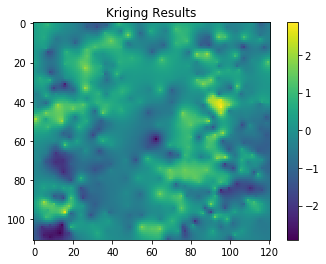

C:\Users\saryz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


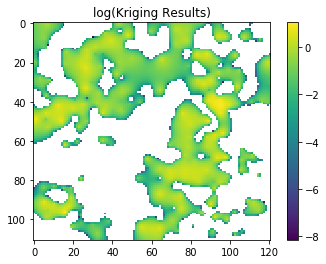

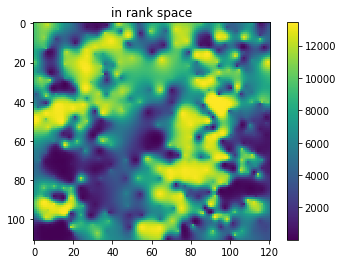

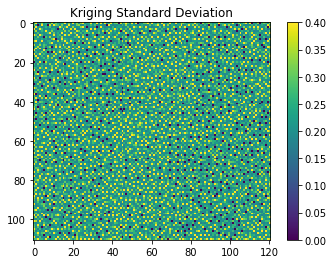

In [42]:
plt.title('Kriging Results')
plt.imshow(interpolation_sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('log(Kriging Results)')
plt.imshow(np.log(interpolation_sgs),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('in rank space')
plt.imshow(sst.rankdata(interpolation_sgs.flatten()).reshape(Z.shape[0], Z.shape[1]),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(std_sgs,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Kriging standar deviation map.png', dpi=300) #save a nice .png of this map.
plt.show()